# Endotype Classification

## General Information
_**Author**_: Jamie Scheper <br>
_**Date**_: 24-01-2024 <br>
_**Version**_: v1.0 <br>
_**Contact**_: j.s.c.scheper@st.hanze.nl, j.s.c.scheper@umcg.nl, jscscheper@gmail.com

## Table of Contents
---
* [Overview](#overview)
* [Setup](#setup)
* [Baseline Performance](#baseline)
     * [Predicting Cluster](#baseline_cluster)
     * [Predicting Severity Status](#baseline_severity)
     * [Predicting Extreme Phenotypes](#baseline_extreme)
* [Feature Selection](#feature_selection)
     * [RFECV](#rfecv)
     * [Own Functions](#own_functions)   
* [After Feature Selection](#after_feature_selection)
* [Optimalization of Three Models](#optimalization)
* [ICU Validation](#icu_validation)
* [Feature Extraction](#feature_extraction)
---

## <a id='overview'>Overview</a>

In this log, we want to establish a prediction model to classify the endotype group from the ER and ICU cohorts. The ER cohort was used as a training and test set (using `train_test_split`). We considered 25% of the total ER cohorts as our test population. We validated our findings on the ICU cohort as an additional measurement of generalization. Additionally, to evaluate the performance of our models, we cross-validate with `StratifiedKfold` with _k_ = 5 and, where appropriate, with a leave-one-out approach (`LeaveOneOut`). We used the machine learning model `sklearn` to accomplish our goals.

To do this, we examined five different models, compared their baseline performance, and thereafter tried feature selection with various techniques. These techniques included using Recurvise Feature Selection with Cross-validation (`RFECV`) and our functions. The results of these two methods were hard to assess, mainly regarding `RFECV` since this method did not yield any "optimal" solution. `RFECV` named gene sets with varying sizes are the optimal solution, ranging from 200 to just five genes. This randomness made us look for more model-dependent solutions such as `L1` and `L2` regularization. Still, we also considered the `mutual_information` metric, which helps to identify the most relevant features for predicting a variable.

This resulted in three different gene sets overlapping (see `differences_genes.Rmd`). These gene sets were used and compared on three optimized models: `LogisticRegression` with `L1`, `LogisticRegression` with `L2`, and `SVC`, also known as Support Vector Machine (SVM). We named `SVC` as our preferred model in the end. This choice was made not only on performance but also on model-specific advantages aligning with our data.

## <a id='setup'>Setup</a>

We start by importing some libraries that are used in this log. We also import our own script, which includes functions for training, cross-validation, and visualizations (see `scripts/training_and_evaluate.py`). We also specify some settings to align visualizations.

In [50]:
import os
os.chdir("C:\\Users\\Jamie\\Desktop\\internship\\scripts")

In [51]:
# Imports
import numpy as np
import pandas as pd
import warnings
import train_and_evaluate as te
import matplotlib.pyplot as plt

from IPython.core.display import HTML

# Some settings - execute to move figures to the middle and have them nicely aligned
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2
%matplotlib inline

HTML("""
<style>
.output_png {
    display: block;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

We first import all of the data regarding ER cohorts: `counts` has all the RNA-Seq data, and `meta_data` ER-specific clinical data, including the class variables.

In [52]:
# Set working directory
os.chdir("C:\\Users\\Jamie\\Desktop\\internship")
counts = pd.read_csv('data/degs/all_degs.csv', index_col = 0).transpose().rename_axis('sample_identifier')
meta_data = pd.read_csv('data/clustering/er_clusters.csv')

In [53]:
meta_data.head()

cluster sepsis_severity sample_identifier
0     one            High         sepcol001
1     one    Intermediate         sepcol002
2     one    Intermediate         sepcol003
3     two             Low         sepcol004
4     two             Low         sepcol005

Let us look at the distribution of essential variables before we go on to assess the baseline performance of models. We do this by using the `te.visualize_features` function that can be used to plot various visualizations.

Below, we see the distribution of sepsis severity with the endotype groups or clusters. `two` is the milder variant and contains more samples, whereas `one` is more severe (more High) and has fewer samples. Additionally, the High class has a severe imbalance with the other courses.

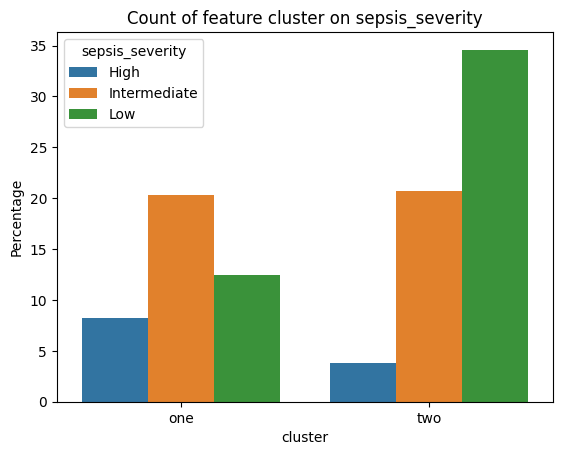

In [54]:
te.visualize_features(data=meta_data, hue='sepsis_severity')

The boxplots below depict the distribution of SOFA scores per class. `one`/severe exhibits higher SOFA scores than `two`/mild.

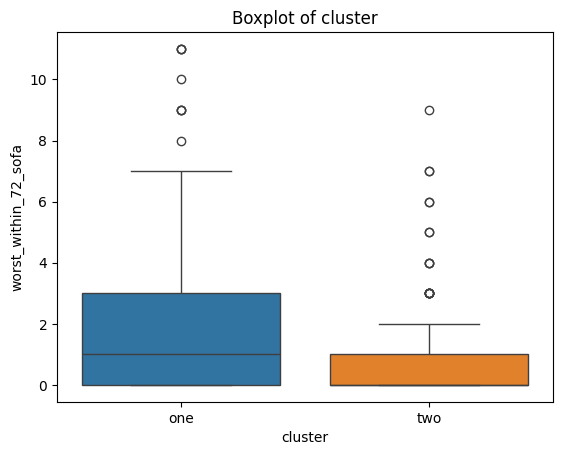

In [33]:
te.visualize_features(data=meta_data, feature_name="cluster", y="worst_within_72_sofa", hue="cluster", method="boxplot")

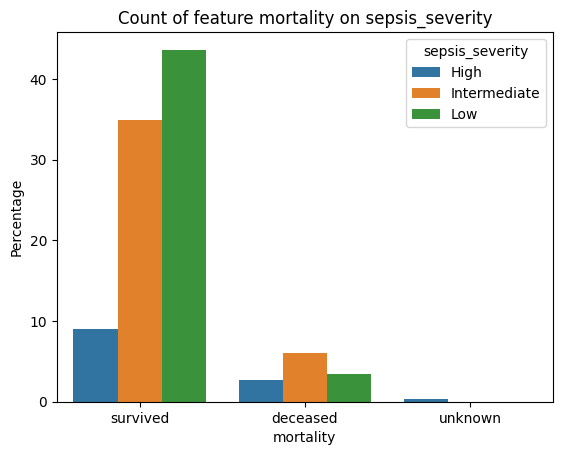

In [23]:
te.visualize_features(meta_data, feature_name='mortality', hue = 'sepsis_severity')

Interestingly, the more severe cluster (`one`) has patients slightly older than in `two` for every level of severity!

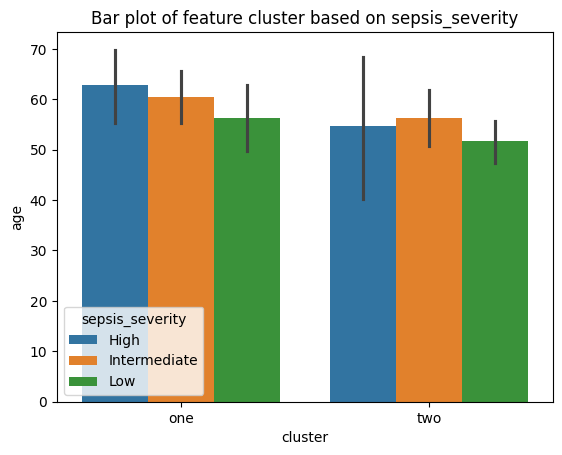

In [34]:
te.visualize_features(data=meta_data, method='bar', feature_name='cluster', y='age', hue='sepsis_severity')

## <a id='baseline'>Baseline Performance</a>

In this section, we will explore how classification models react to predicting `cluster`, `severity_status`, and a distinction between High + Intermediate vs. Low to account for the class imbalance with High. We expect to see overfitting in our results since we are working with 202 different genes or features. A feature selection or extraction might be a logical next step.

We will first start with selecting some models. We decided to go with five different models with different capabilities and weaknesses. These are:
* Support Vector Machine (SVM) or, in Sklearn's vocabulary, `SVC`;
* Naive Bayes (`MultinomialNB`);
* Random Forest (`RandomForestClassifier`);
* Logistic Regression with built-in LASSO regularization (`LogisticRegression(penalty='l1')`); and
* Logistic Regression with built-in Ridge regularization (`LogisticRegression(penalty='l2')`).

We will use standard parameter values for now. Optimization of these models will become an important factor later on. Let us first import these models.

Some notes on the standard parameters:
* SVC: We use the `OneVsRestClassifier` to account for multi-class classification (and also use the `probability=True` parameter). SVC only compares between two classes.
* LogisticRegression: usage of the `multi_class` parameter is essential for multi-class classification. `solver=saga` is used since we use both L1 and L2 regularization.

In [55]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (recall_score, accuracy_score, precision_score, f1_score,
                             roc_curve, auc, log_loss, brier_score_loss, 
                            roc_auc_score, mean_squared_error)

models = {"SVM":OneVsRestClassifier(SVC(probability=True)), 
          "NB": MultinomialNB(), 
          "RF": RandomForestClassifier(), 
          "LogRes_L1": LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga'), 
          "LogRes_L2": LogisticRegression(penalty='l2', multi_class='multinomial', solver='saga')}

We merge the counts and metadata datasets and introduce a binary distribution for High + Intermediate vs. Low.

In [56]:
merged_df = pd.merge(counts, meta_data[["cluster", "sepsis_severity", "sample_identifier"]], on="sample_identifier", how='inner').reset_index(drop=True)
merged_df['highint_low'] = merged_df['sepsis_severity'].apply(lambda x: "High-Int" if x in ['High', 'Intermediate'] else "Low")

We have out of the 266 ER samples, 157 belonging to `two` (mild) and 109 to `one` (severe). 

In [57]:
merged_df['cluster'].value_counts()

cluster
two    157
one    109
Name: count, dtype: int64

We have out of the 266 ER samples, 125 belonging to `Low`, 109 to `Intermediate`, and 32 to `High`. This gives the indication of a class imbalance between High and the other two levels.

In [58]:
merged_df['sepsis_severity'].value_counts()

sepsis_severity
Low             125
Intermediate    109
High             32
Name: count, dtype: int64

We now split the merged dataset into two:
* `X` holds all the count data
* `y` holds all class variables

After that, we split into training and test sets (75-25% split). We stratify based on sepsis severity to account for the class imbalance. A `random_state` is used for reproducibility. 

A `MinMaxScaler` is used on the counts, even though already normalized with VST; it might be beneficial for some of the models to have a min-max normalization. We use `fit_transform` on `X_train` and extend this to the test set. After that, we pack all training and test sets into one variable for convenience. After that, we pack everything into `train_test_data` for easy usage between different functions!

In [59]:
X = merged_df.drop(['cluster', 'sepsis_severity', 'highint_low', 'sample_identifier'], axis=1)
y = merged_df[['cluster', 'sepsis_severity', 'highint_low']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y['sepsis_severity'], random_state=200)

scaler = MinMaxScaler()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns) #retain gene names
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
train_test_data = X_train, X_test, y_train, y_test

Now, we are ready to perform the models on baseline parameter settings with all the DEG features.

### <a id='baseline_cluster'>Baseline Cluster/Endotype</a>

We will start by assessing how the models can predict the endotype group. As we observe below, the models can predict almost everything perfectly. This may be a sign of overfitting since we include all DEGs. A feature selection looks necessary. The test scores in the classification report show us that group `two` has better prediction scores than group `one`. For example, the recall score for group `one` for Random Forest is 0.86, and for `two` 0.97.

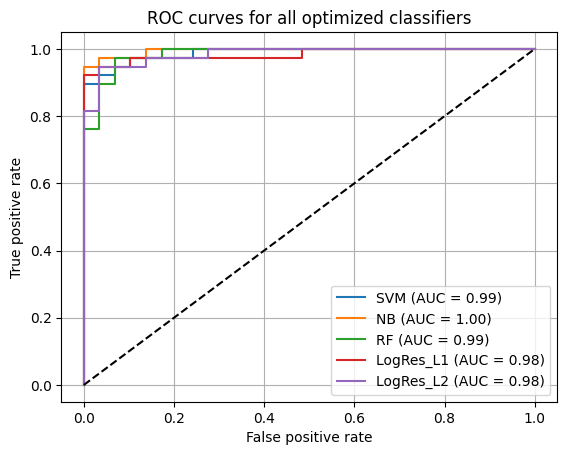

In [60]:
train_endo_all = {}
for name, model in models.items():
    train_endo_all[name] = te.train(train_test_data, model, plot=True)

te.roc_in_one(train_endo_all)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.96      0.86      0.91        29
         two       0.90      0.97      0.94        38

    accuracy                           0.93        67
   macro avg       0.93      0.92      0.92        67
weighted avg       0.93      0.93      0.92        67

The resulting classification report for NB 
               precision    recall  f1-score   support

         one       1.00      0.83      0.91        29
         two       0.88      1.00      0.94        38

    accuracy                           0.93        67
   macro avg       0.94      0.91      0.92        67
weighted avg       0.93      0.93      0.92        67

The resulting classification report for RF 
               precision    recall  f1-score   support

         one       0.96      0.86      0.91        29
         two       0.90      0.97      0.94        38

    accuracy                           0.93   

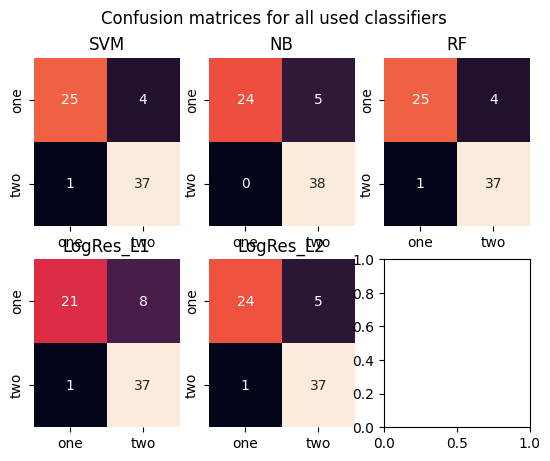

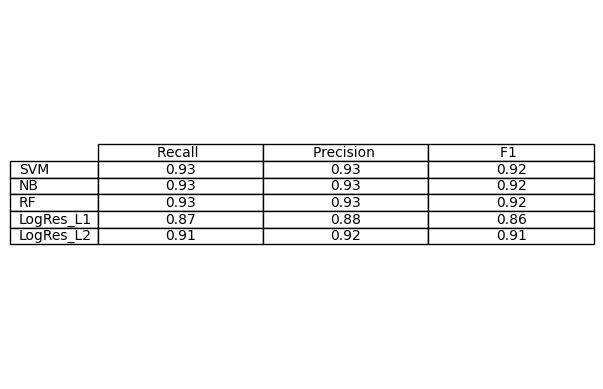

In [61]:
te.visualize_results(train_endo_all)

When we tried to cross-validate the training set with `StratifieldKFold` with _k_ = 5, we saw that the performance of all models was very good. For instance, the classification report shows that both groups have a recall score between 0.94 and 0.96.

SVM


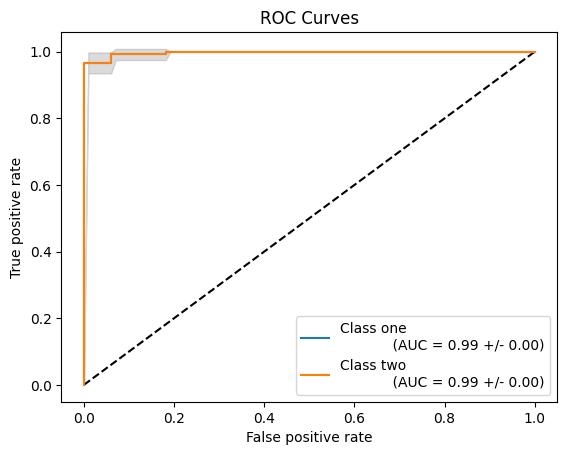

NB


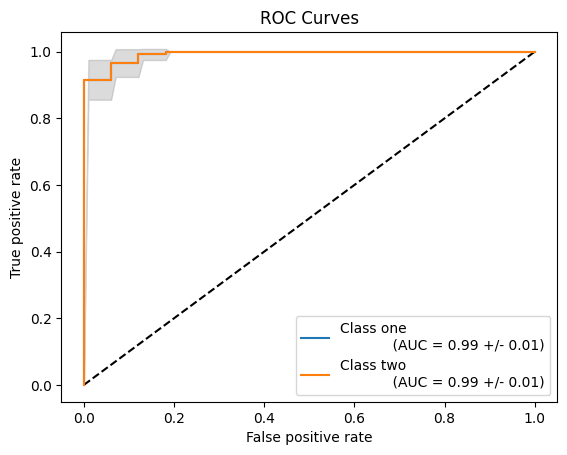

RF


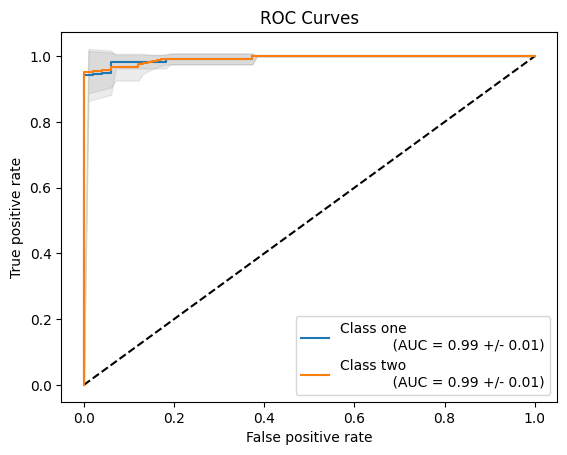

LogRes_L1


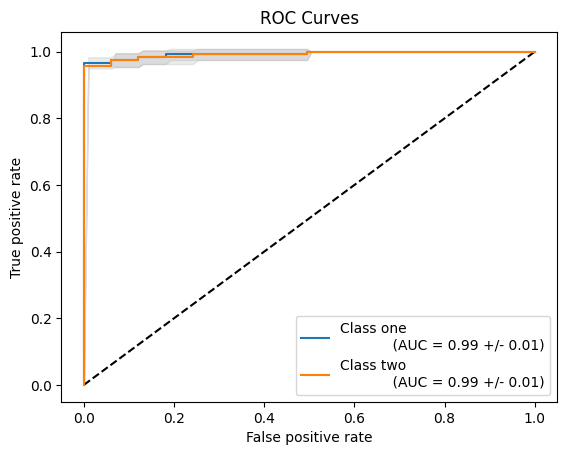

LogRes_L2


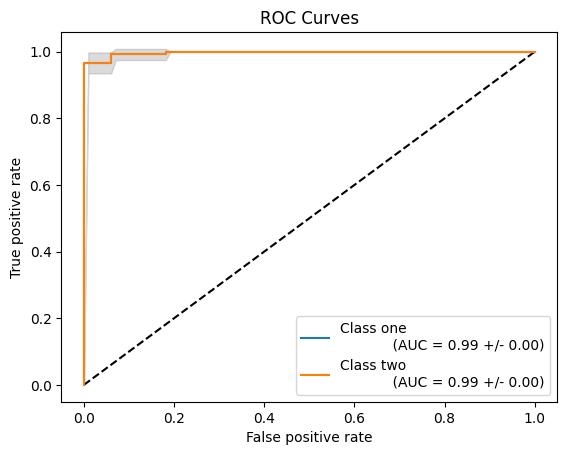

In [62]:
cross_endo_all = {}

for name, model in models.items():
    print(name)
    cross_endo_all[name] = te.cross_val(train_test_data, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.97      0.91      0.94        80
         two       0.94      0.98      0.96       119

    accuracy                           0.95       199
   macro avg       0.96      0.95      0.95       199
weighted avg       0.96      0.95      0.95       199

The resulting classification report for NB 
               precision    recall  f1-score   support

         one       0.97      0.88      0.92        80
         two       0.92      0.98      0.95       119

    accuracy                           0.94       199
   macro avg       0.95      0.93      0.94       199
weighted avg       0.94      0.94      0.94       199

The resulting classification report for RF 
               precision    recall  f1-score   support

         one       0.96      0.89      0.92        80
         two       0.93      0.97      0.95       119

    accuracy                           0.94   

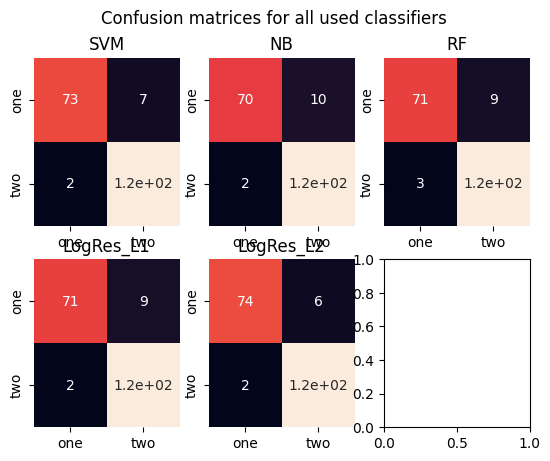

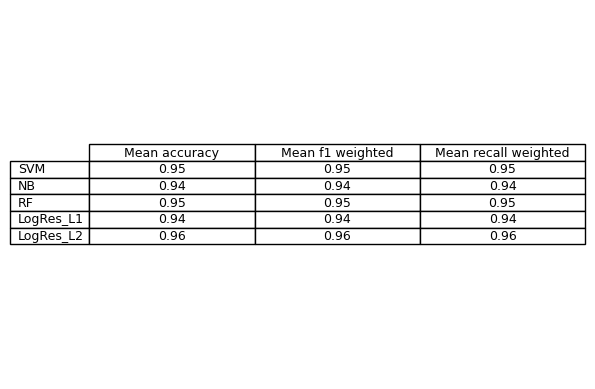

In [63]:
te.visualize_results(cross_endo_all)

Below, we use a function from the package `scikitplot`. This is a way to validate our own findings. This function only needs the training data and then trains and cross-validates with it. We understand that most training scores are perfect, whereas the cross-validation scores are somewhat less. This is a sign of overfitting and requires us to take action in the form of a feature selection.

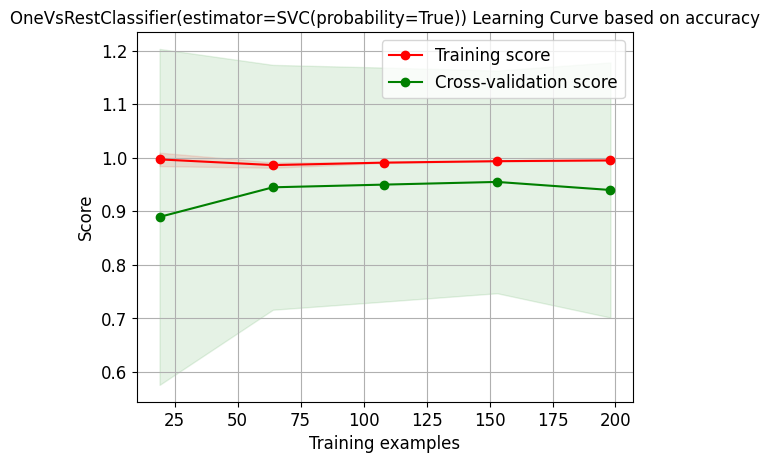

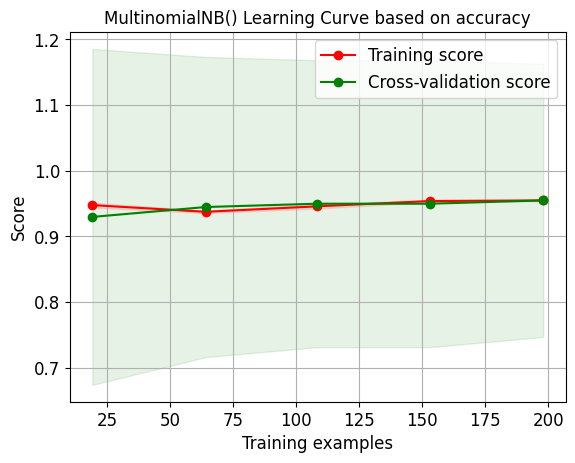

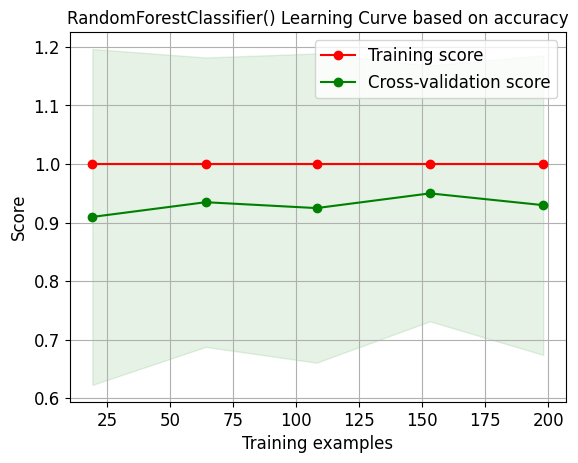

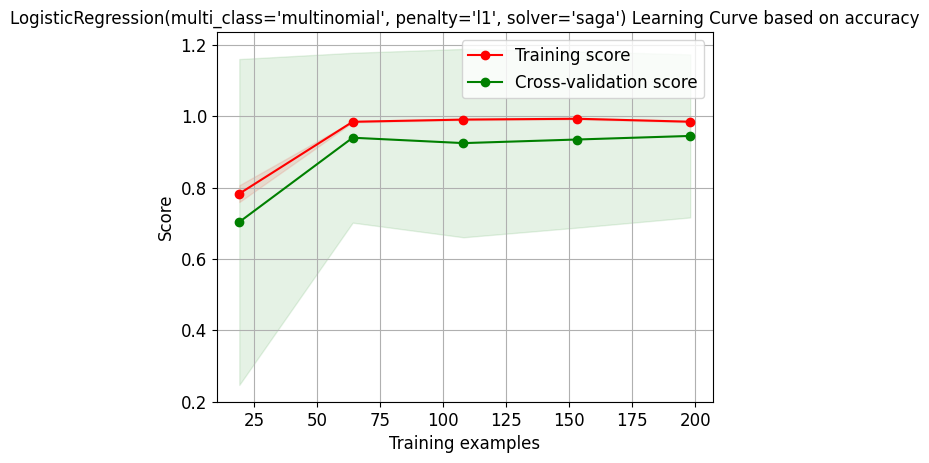

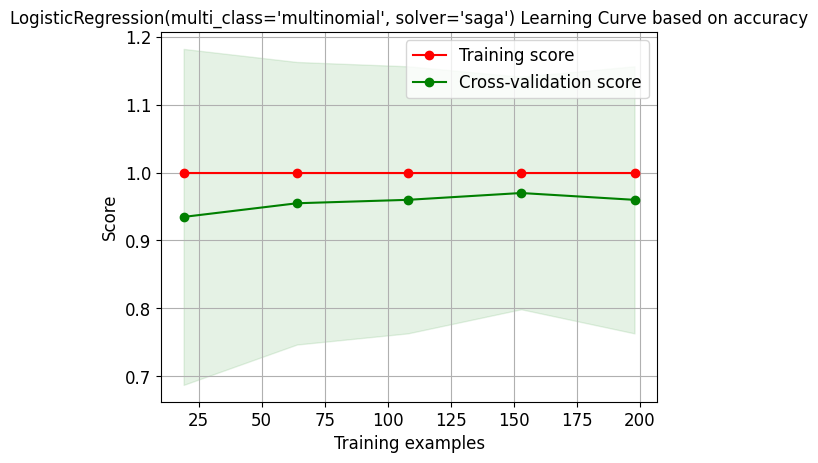

In [44]:
for name, model in models.items():
    te.train_and_cross(train_test_data, model)

### <a id='baseline_severity'>Baseline Severity</a>

Now, we turn to predicting the severity class. We expect some difficulties here since the class High only has 32 samples. In contrast, the other classes have 100+ samples, creating an imbalanced class variable. As we observe below, the models can severity with sufficient scores, but the scores are no longer perfect. However, the classification report shows that the High class has a precision, recall, and f1-score of 0.00 across almost all models! Only Naïve Bayes can recognize some samples. As we stated during the introduction, we will take a look at what happens when we merge the High with the Intermediate class to offset the class imbalance.

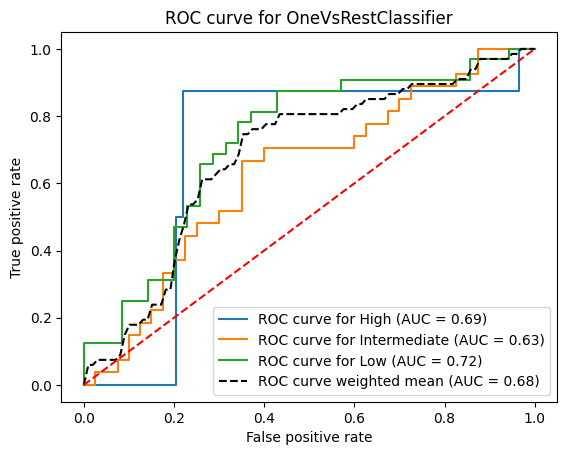

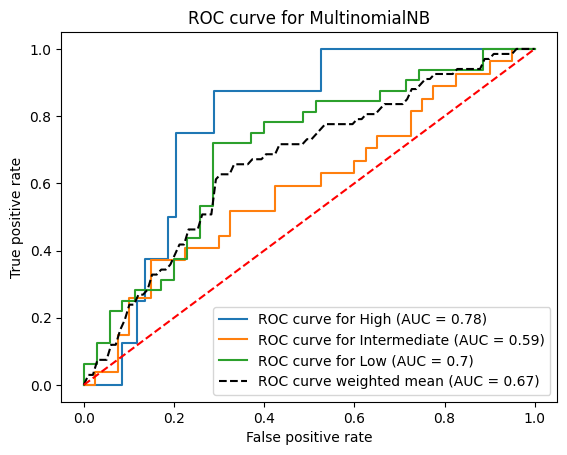

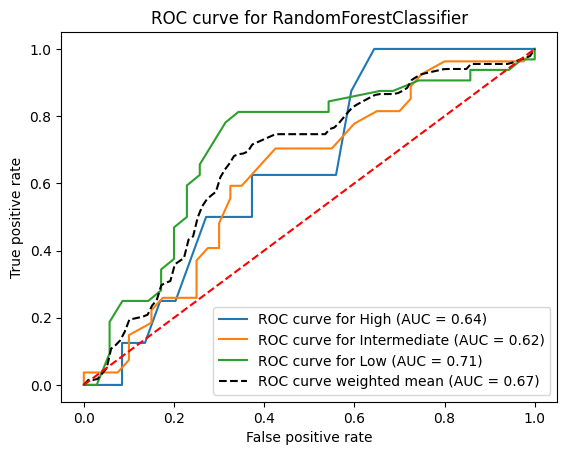

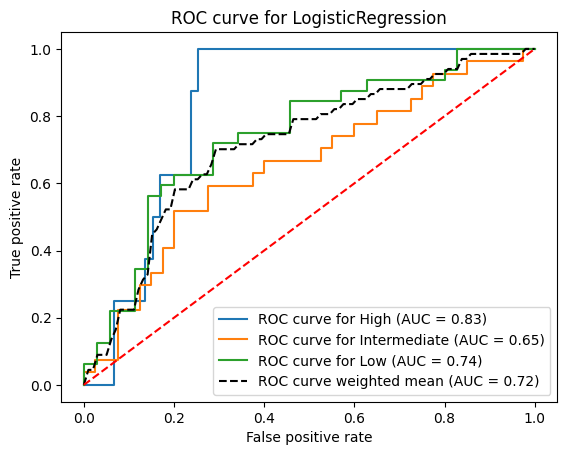

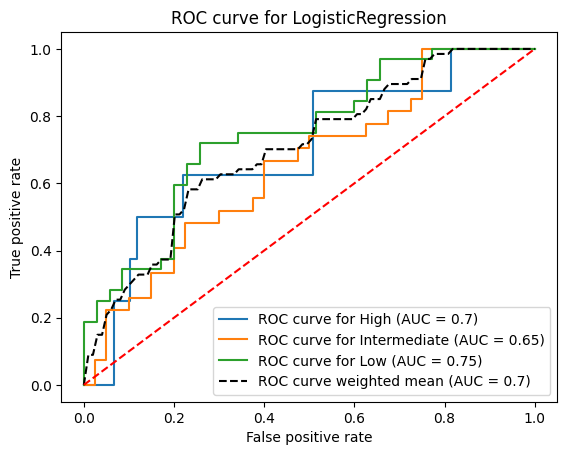

In [64]:
train_severity_all = {}

for name, model in models.items():
    train_severity_all[name] = te.train(train_test_data, model, cls="sepsis_severity", plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         8
Intermediate       0.56      0.52      0.54        27
         Low       0.67      0.88      0.76        32

    accuracy                           0.63        67
   macro avg       0.41      0.46      0.43        67
weighted avg       0.54      0.63      0.58        67

The resulting classification report for NB 
               precision    recall  f1-score   support

        High       0.14      0.12      0.13         8
Intermediate       0.50      0.37      0.43        27
         Low       0.62      0.78      0.69        32

    accuracy                           0.54        67
   macro avg       0.42      0.43      0.42        67
weighted avg       0.52      0.54      0.52        67

The resulting classification report for RF 
               precision    recall  f1-score   support

        High       0.00      0.00      0.00    

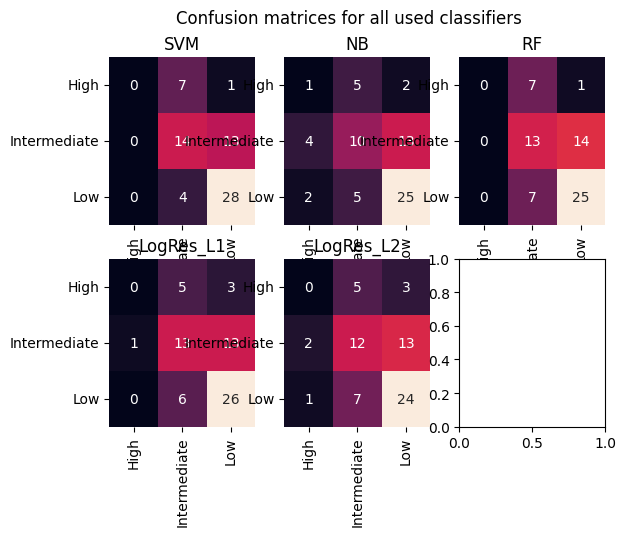

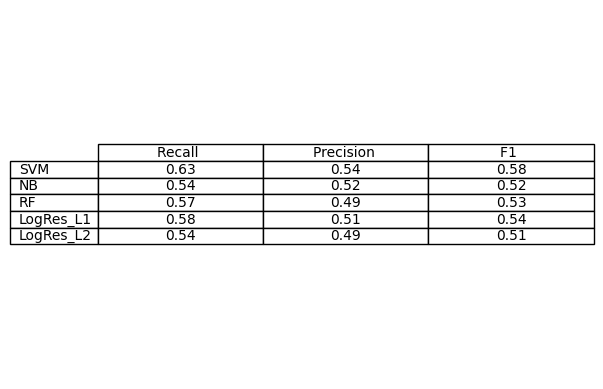

In [65]:
te.visualize_results(train_severity_all)

When cross-validating on the severity class, all scores match the ROC curves we saw with the test set. However, the standard deviation is high, especially for the High class, with a standard deviation 0.19 for SVM. With already low scores, this might not be sufficient to accurately predict the severity class, even after a feature selection. The classification report also shows low accuracy, f1, and recall scores for all models.

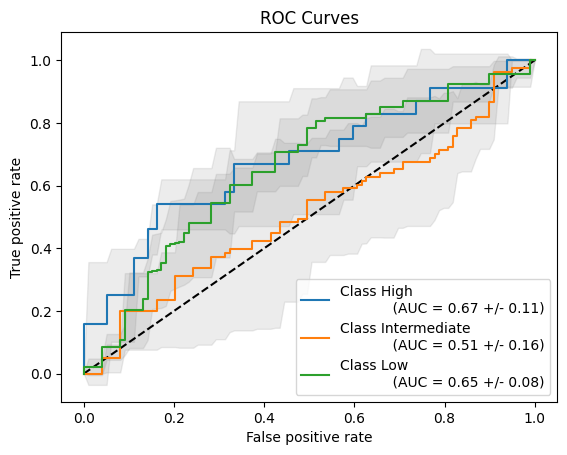

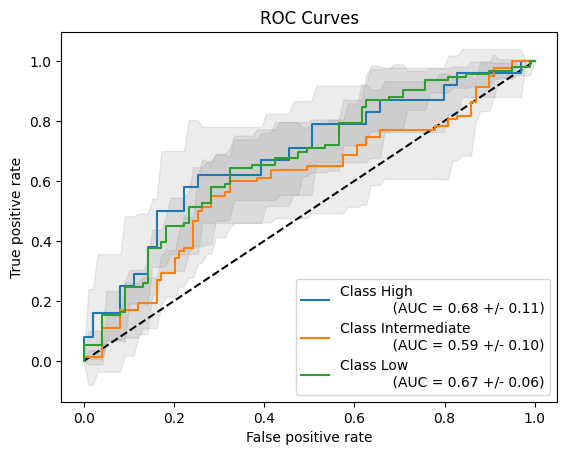

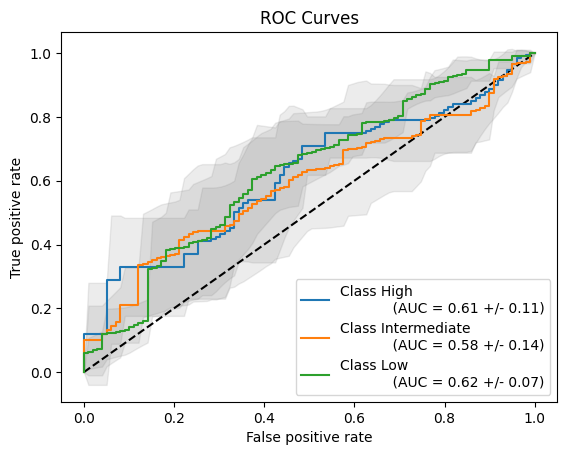

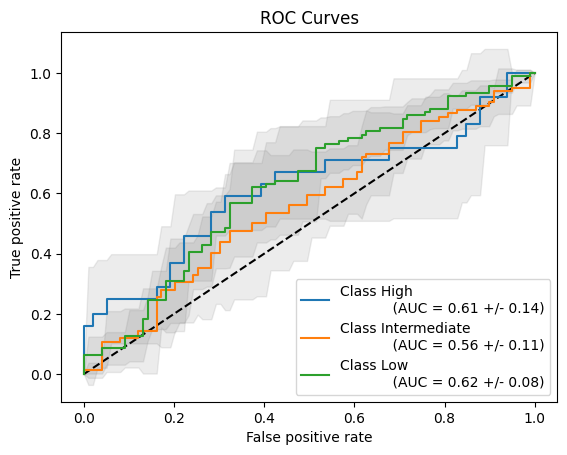

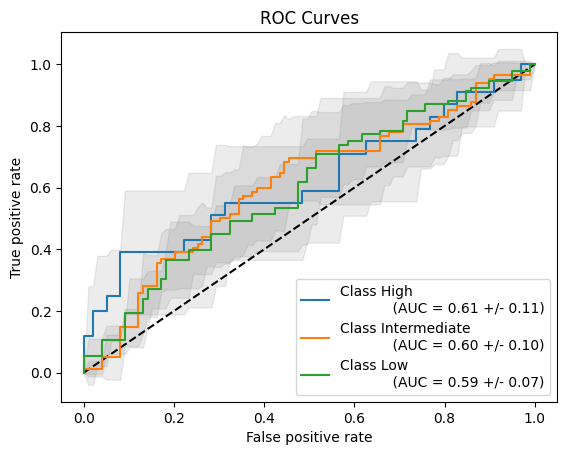

In [66]:
cross_severity_all = {}

for name, model in models.items():
    cross_severity_all[name] = te.cross_val(train_test_data, model, cls='sepsis_severity', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        24
Intermediate       0.56      0.49      0.52        82
         Low       0.59      0.81      0.68        93

    accuracy                           0.58       199
   macro avg       0.38      0.43      0.40       199
weighted avg       0.50      0.58      0.53       199

The resulting classification report for NB 
               precision    recall  f1-score   support

        High       0.26      0.29      0.27        24
Intermediate       0.55      0.37      0.44        82
         Low       0.59      0.74      0.66        93

    accuracy                           0.53       199
   macro avg       0.46      0.47      0.46       199
weighted avg       0.53      0.53      0.52       199

The resulting classification report for RF 
               precision    recall  f1-score   support

        High       0.00      0.00      0.00    

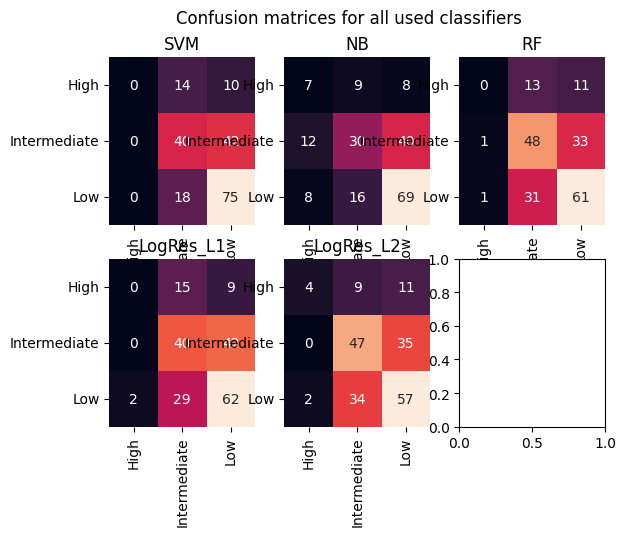

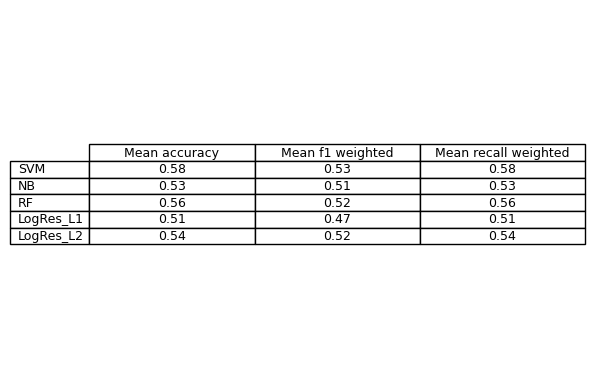

In [48]:
te.visualize_results(cross_severity_all)

When performing on the external function from `scikitplot`, we see that the training set scores high. It is so high that in the case of random forest, it is always a perfect 1.00, whereas cross-validation scores depict a somewhat different picture; scores here are between 0.40 and 0.60 for all models. This again shows us that our models are overfitted.

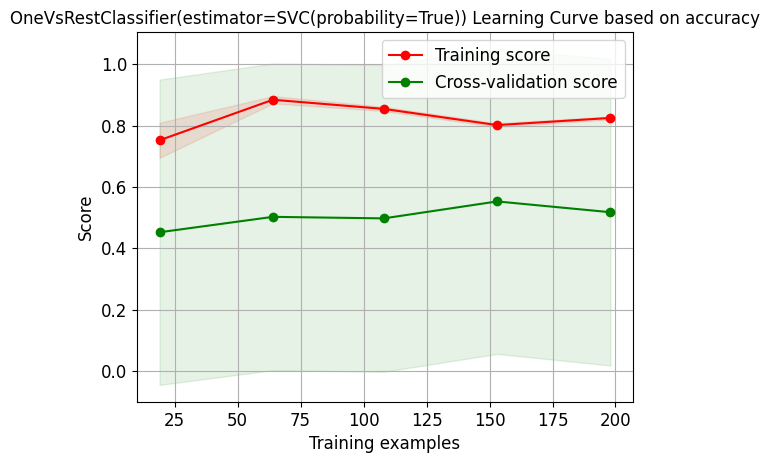

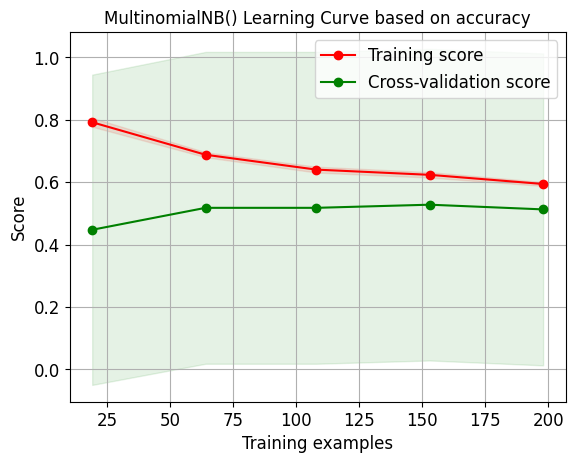

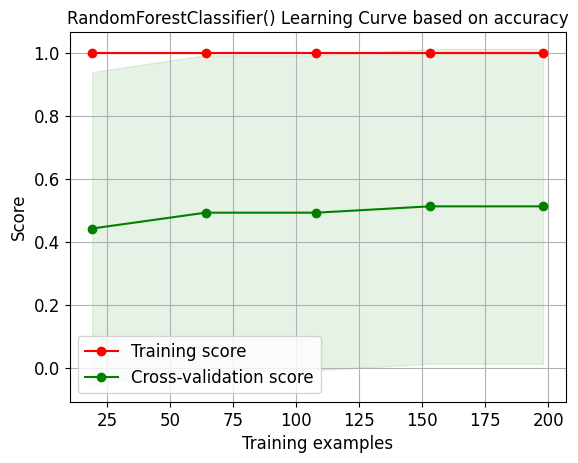

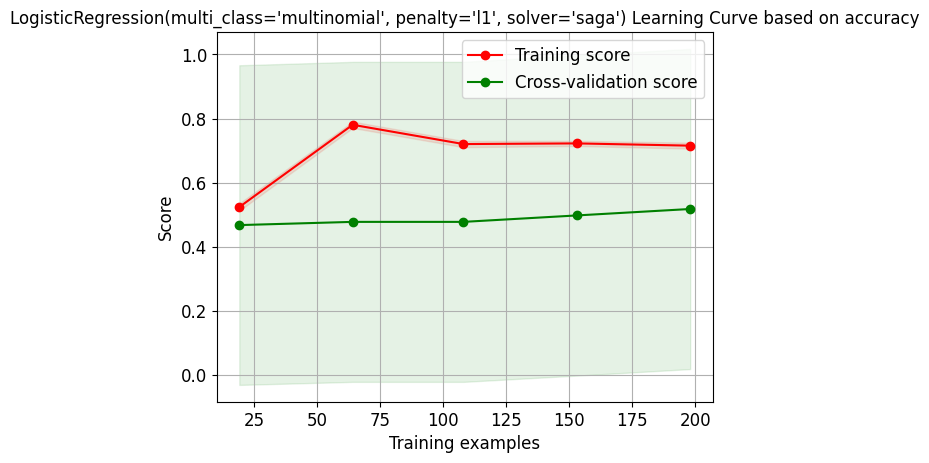

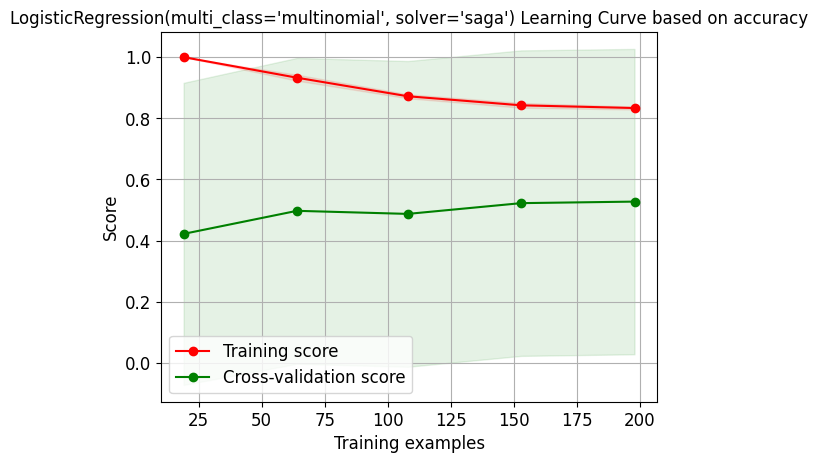

In [49]:
for name, model in models.items():
    te.train_and_cross(train_test_data, model, cls = 'sepsis_severity')

### <a id='baseline_extreme'>Baseline Extreme Phenotypes</a>

Now, we turn to predicting the combined class of `HighInt_Low`, representing the High + Intermediate vs. Low class.

As we observe below, the models can severity with sufficient scores, but the scores are no longer perfect. When looking at the classification report, we see that the High + Int. class has a precision, recall, and f1-score of around 0.70 across almost all models! The class imbalance is no longer an issue. But this means that the distinction between High and Intermediate might be somewhat unrecognizable for the model.

The ROC curves for the test are between 0.72 for SVM and 0.74 for logistic regression with L2 regularization. The classification seems to favor predicting the Low class more sufficiently for Naïve Baye but is on par with High-Int in other models.

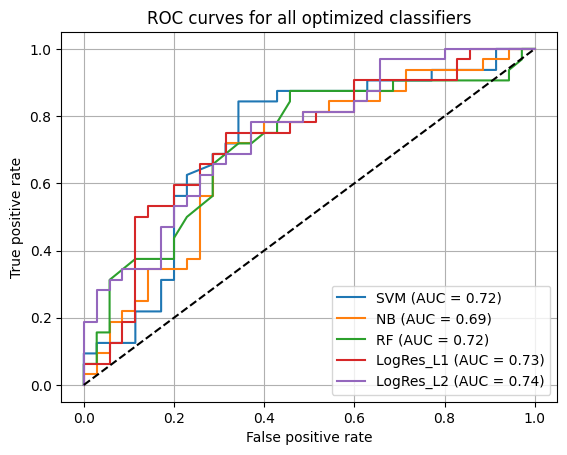

In [67]:
train_pheno_all = {}

for name, model in models.items():
    train_pheno_all[name] = te.train(train_test_data, model, cls="highint_low", plot=True)

te.roc_in_one(train_pheno_all)

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.71      0.69      0.70        35
         Low       0.67      0.69      0.68        32

    accuracy                           0.69        67
   macro avg       0.69      0.69      0.69        67
weighted avg       0.69      0.69      0.69        67

The resulting classification report for NB 
               precision    recall  f1-score   support

    High-Int       0.72      0.60      0.66        35
         Low       0.63      0.75      0.69        32

    accuracy                           0.67        67
   macro avg       0.68      0.68      0.67        67
weighted avg       0.68      0.67      0.67        67

The resulting classification report for RF 
               precision    recall  f1-score   support

    High-Int       0.71      0.69      0.70        35
         Low       0.67      0.69      0.68        32

    accuracy                           0.69   

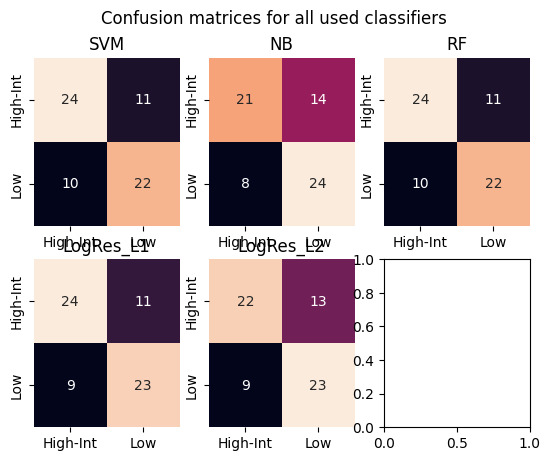

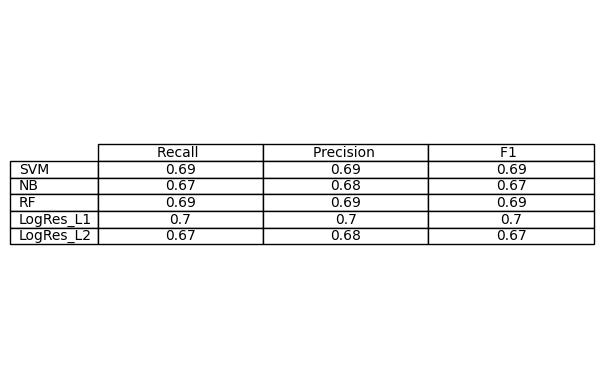

In [68]:
te.visualize_results(train_pheno_all)

When cross-validating both classes, we see no major distinction between classes in terms of prediction capabilities. Both classes are predicted with an accuracy of around 0.60-0.65 in all models. Naïve Bayes has the best scores, and logistic regression with L2 has the worst. The latter comes from the fact that Low is being predicted with a recall of 0.52 and High-Int 0.65 (see classification report).

SVM


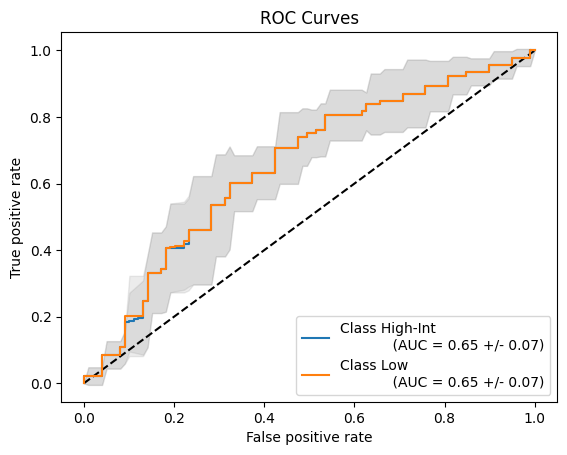

NB


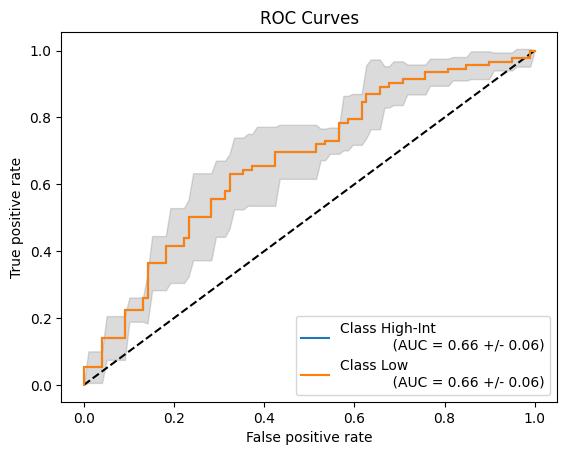

RF


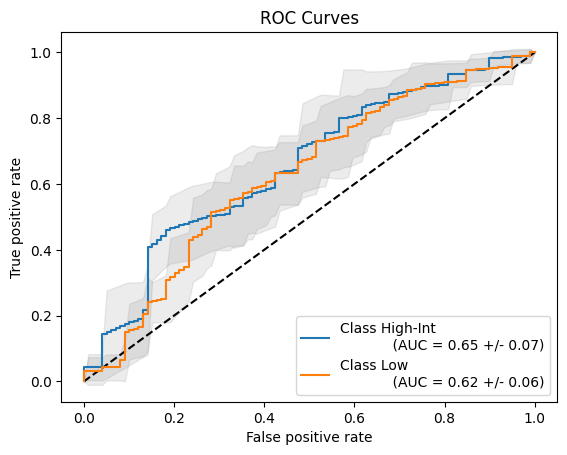

LogRes_L1


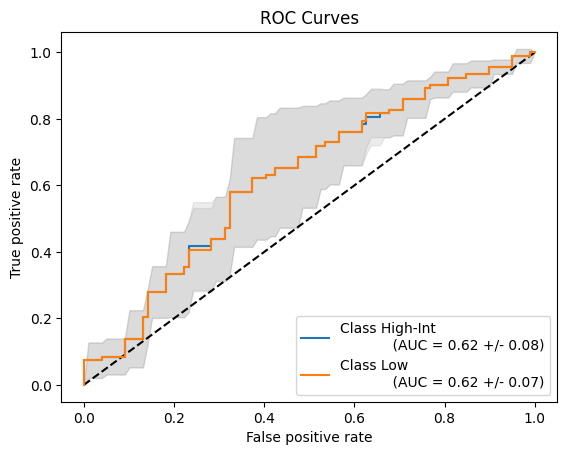

LogRes_L2


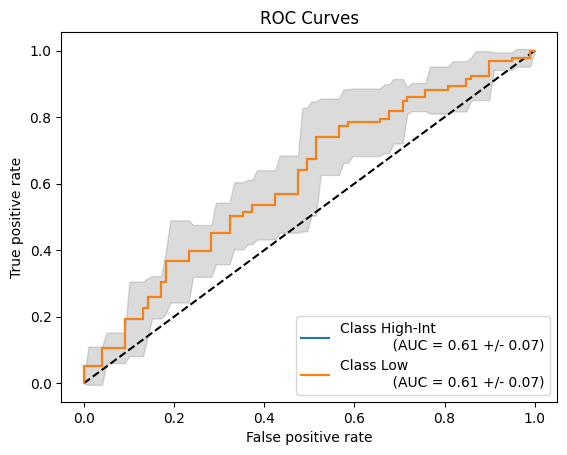

In [52]:
cross_pheno_all = {}

for name, model in models.items():
    print(name)
    cross_pheno_all[name] = te.cross_val(train_test_data, model, cls='highint_low', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.63      0.65      0.64       106
         Low       0.58      0.56      0.57        93

    accuracy                           0.61       199
   macro avg       0.61      0.61      0.61       199
weighted avg       0.61      0.61      0.61       199

The resulting classification report for NB 
               precision    recall  f1-score   support

    High-Int       0.68      0.58      0.63       106
         Low       0.59      0.69      0.64        93

    accuracy                           0.63       199
   macro avg       0.64      0.64      0.63       199
weighted avg       0.64      0.63      0.63       199

The resulting classification report for RF 
               precision    recall  f1-score   support

    High-Int       0.60      0.66      0.63       106
         Low       0.56      0.49      0.53        93

    accuracy                           0.58   

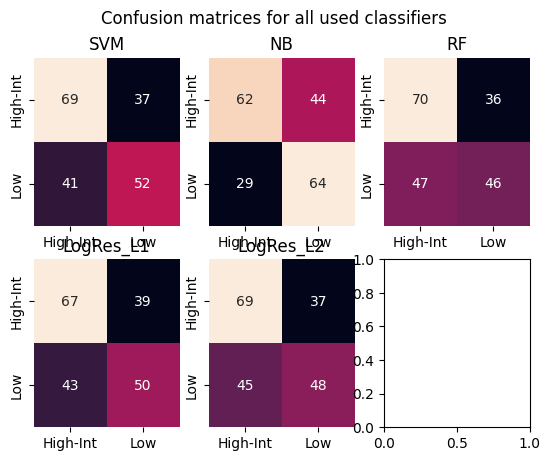

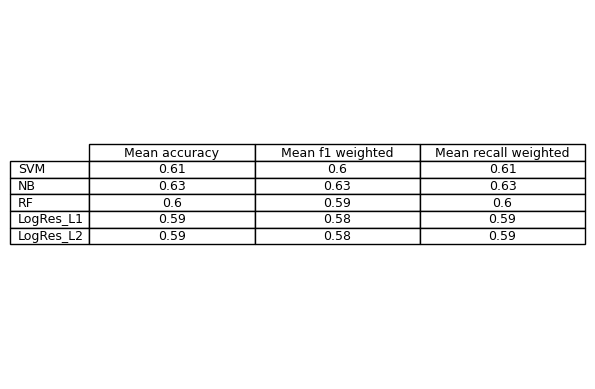

In [53]:
te.visualize_results(cross_pheno_all)

When we turn to `scikitplot` again, we see that the difference between some of the training and cross-validation scores is also high here. Random Forest is still severely overfitted, but others are somewhat less than when comparing them to predicting the endotype group. Still, we can conclude that the models are also overfitted for this classification problem. A feature selection is necessary.

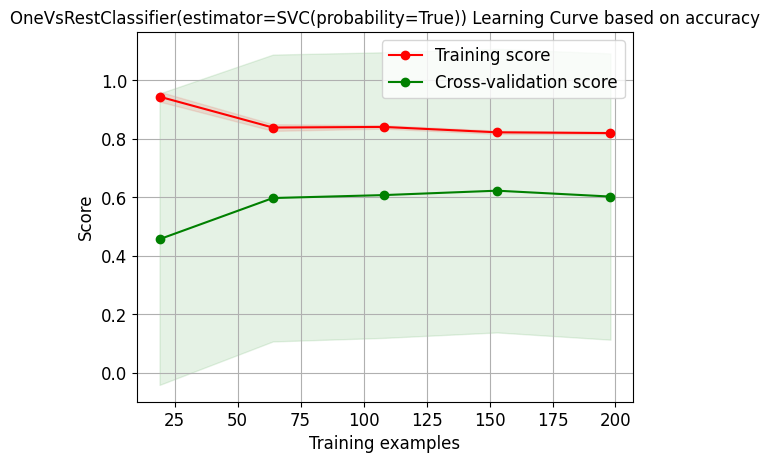

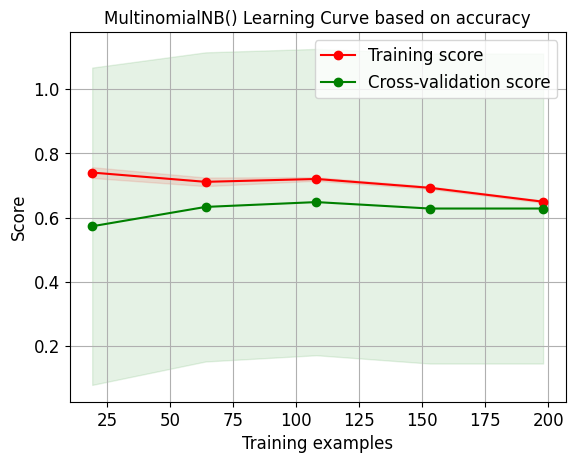

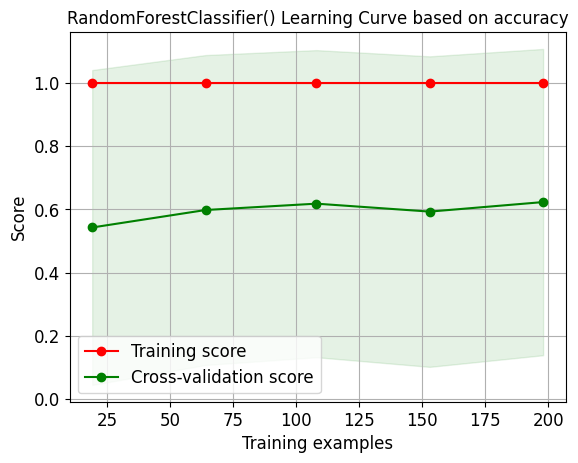

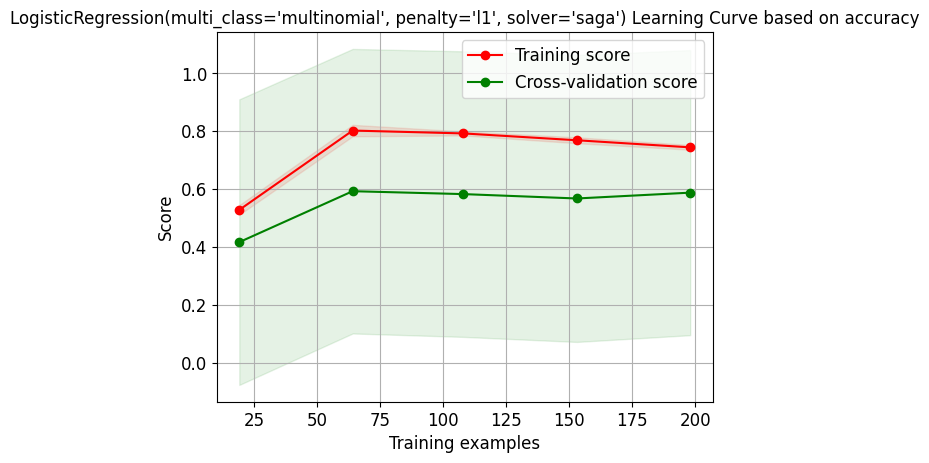

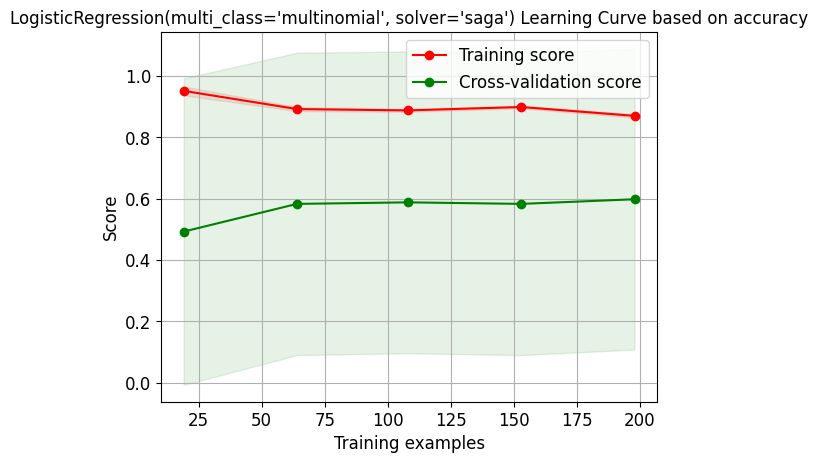

In [54]:
for name, model in models.items():
    te.train_and_cross(train_test_data, model, cls = 'highint_low')

## <a id='feature_selection'>Feature Selection</a>

We have 201 genes or features. Searching for the most optimal solution would require using the `ExhaustiveFeatureSelector` from `mlxtend`. However, this would take a very long time since the number of features it needs to consider is fairly large. In fact, this number is so large that it might not even be feasible to even think about getting the most optimal feature set. This number is `3213876088517980551083924184682325205044405987565585670602751`. So, we will not get the most optimal feature set, but we will try to extract a good set using `RFECV` and other functions.

In [71]:
from mlxtend.math import num_combinations

# calculate all possible combinations
all_combinations = np.sum([num_combinations(201, k=index) for index in range(1, 202)])

print(all_combinations)

3213876088517980551083924184682325205044405987565585670602751


In [ ]:
# we are not going to use this!
ex = ExhaustiveFeatureSelector(
    RandomForestClassifier(),
    min_features=10,
    max_features=50,
    scoring='accuracy',
    print_progress=True,
    cv=5
)

Since we can only perform feature selection on models that have either a `feature_importances_` or `coef_` attribute, we consider three models:

In [72]:
models_feature = {"RF": RandomForestClassifier(), 
          "LogRes_L1": LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga'), 
          "LogRes_L2": LogisticRegression(penalty='l2', multi_class='multinomial', solver='saga')}

### <a id='rfecv'>Feature Selection: RFECV</a>

We are going to perform feature selection with `RFECV` first. We do this by using the function `select_features_cv`, which allows us to customize our selection. Some parameters include specifying the class variable and the model we are using. We will consider two class variables (`cluster` and `highint_low`). We will first take a look at the cluster or the endotype group!

The function `retain_features` is used to retain some features that have been selected.

In [73]:
def retain_features(list_features, data):
    """
    A simple function to slim down a given dataset with train and test sets
    based on a given list of features.

    Parameters:
        list_features (list) - a list of features that you want to retain
        data (tuple) - a tuple with a train and test set

    Returns:
        new_data - a slimmed down dataset with features you want to retain
    """
    x_train_, x_test_, y_train_, y_test_ = data
    x_train_ = x_train_[[column for column in x_train_.columns if column in list_features]]
    x_test_ = x_test_[[column for column in x_test_.columns if column in list_features]]

    new_dataset = x_train_, x_test_, y_train_, y_test_

    return new_dataset

The performance widely fluctuates when selecting features on Random Forest, giving us a best-performing set of 84 features. This number, when looking at the graph, seems rather arbitrary. Additionally, the two outcomes for L1 and L2 seem to stall after a number of features, extracting 97 and 78 as the most optimal set. 

Optimal number of features 84


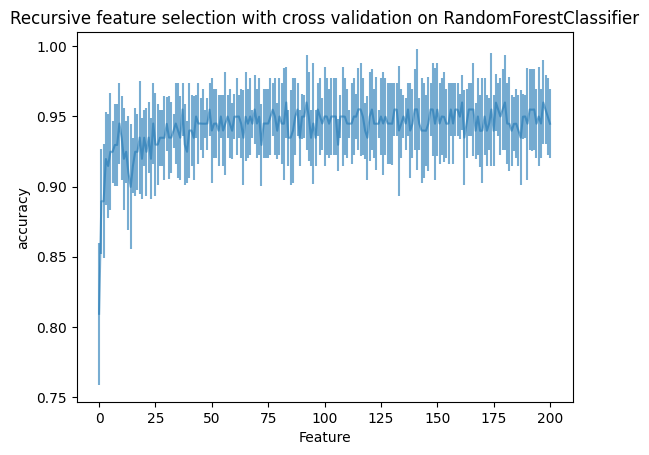

Optimal number of features 97


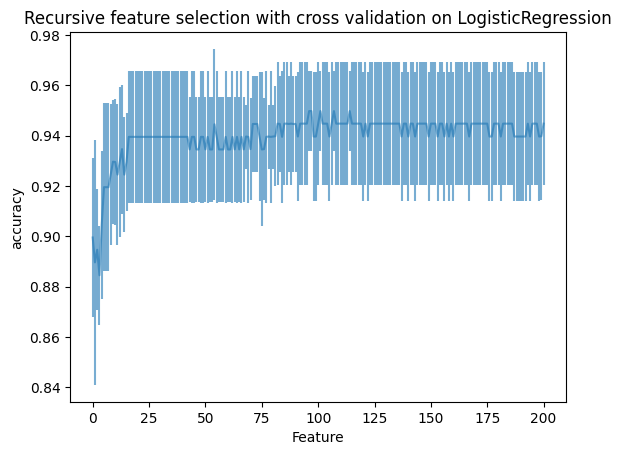

Optimal number of features 78


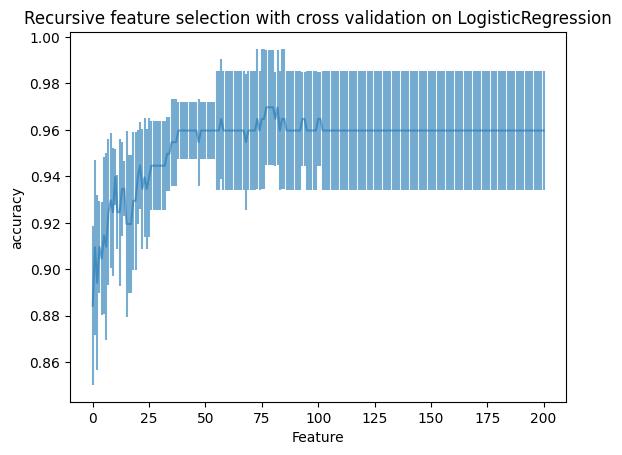

In [74]:
res_rfe_cluster = [te.select_features_cv(train_test_data, model, 'cluster') 
                    for name, model in models_feature.items()]

When considering how the features overlap between the different ways of selecting, we see that most overlap with the RF feature selection.

The way scores are for endotype classification gives us a reason to pursue a different way of selecting features, as they already seem very high. Predicting with severity was not as good and exhibited overfitting in addition. Therefore, it seems to be better to select features on the `highint_low` variable as a specific set of genes could improve the prediction capabilities regarding severity and still be excellent in predicting the endotype. 

Index(['CHDH', 'G0S2', 'VPS54', 'UCP2', 'PACS2', 'FGR', 'SARM1', 'JARID2',
       'FYN', 'KIF1B', 'ADCK1', 'OAT', 'CRLS1', 'TFAP4', 'PDPR', 'POLRMT',
       'TSPO', 'RAB5IF', 'NTSR1', 'SNPH', 'BMF', 'MRPL51', 'COX7A2', 'PECR',
       'MTARC2', 'RAB32', 'ARG1', 'SIRT5', 'ROMO1', 'POR', 'RAC2', 'MRPS25',
       'MCCC2', 'ENOSF1', 'COQ10A', 'IER3', 'CYP1B1', 'SORD', 'BCL2A1', 'TP53',
       'SLC27A3', 'SFXN5', 'STOM', 'PDSS1', 'FEZ1', 'TIMM8B', 'CYP2U1',
       'ATP5MJ', 'HKDC1', 'TOMM40L', 'THEM4', 'RDH13', 'HK3', 'SLC25A45',
       'UQCRQ', 'MMADHC', 'MFF', 'FAM110B', 'CA5B', 'GIMAP8', 'UCP3', 'TMEM70',
       'MSRA', 'TDRKH', 'AIFM3', 'ANKRD37', 'FHIT', 'PTPN1', 'SDHAF3',
       'METTL9', 'SRC', 'SYNJ2BP', 'DDAH2', 'CEBPZOS', 'EPHA4', 'SGK1',
       'GRPEL2', 'FAM210A'],
      dtype='object')

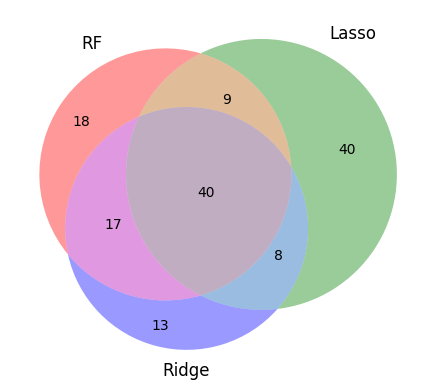

In [79]:
from matplotlib_venn import venn3

clust_rf = train_test_data[0].loc[:, res_rfe_cluster[0][1]].columns
clust_lasso = train_test_data[0].loc[:, res_rfe_cluster[1][1]].columns
clust_ridge = train_test_data[0].loc[:, res_rfe_cluster[2][1]].columns

venn3([set(clust_rf), set(clust_lasso), set(clust_ridge)], ("RF",  "Lasso", 'Ridge'))

clust_ridge

We will now perform feature selection based on the `highint_low` class variable with `RFECV`. We observe that the selection based on Random Forest seems again very random. It advises a feature set of 94 as the most optimal, which is quite a large set, considering we start off with 201 features.


The other two methods, just like with `cluster`, flatline after some early peeks, especially with L1. L1 establishes a set of 97, and L2 78 features are the most optimal set. Both are also high, stopping earlier might be better since all score platue.

Optimal number of features 94


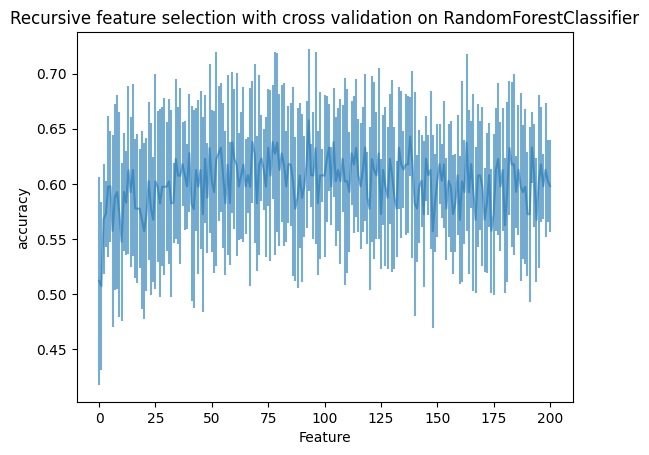

Optimal number of features 6


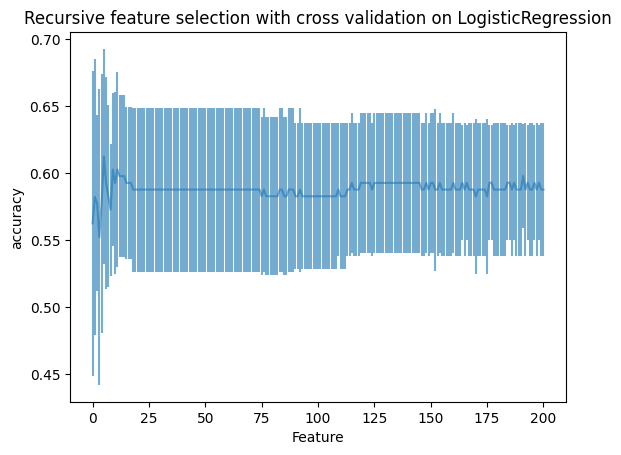

Optimal number of features 35


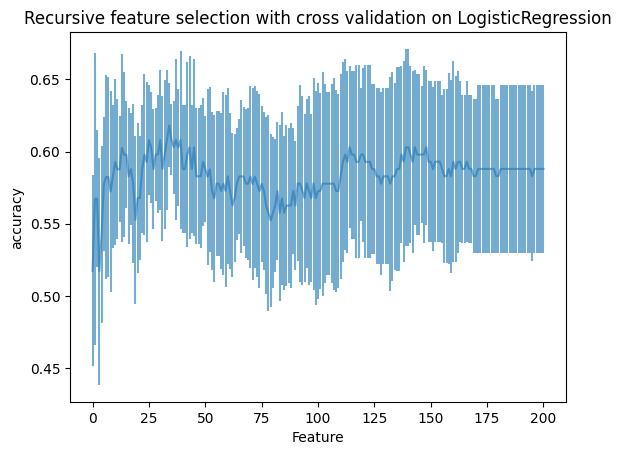

In [76]:
res_rfe_highint = [te.select_features_cv(train_test_data, model, 'highint_low')
                   for name, model in models_feature.items()]

Since the Random Forest set is so large, there is a lot of overlap between the two logistic regression sets. The L1 and L2 sets also have a lot of overlap, which is interesting since they have small sets of features. Lasso has one unique feature, and so does Ridge. This might be a reason to go with other features from L1 or L2. Since L1 has a smaller set, we will consider this set and test with it.

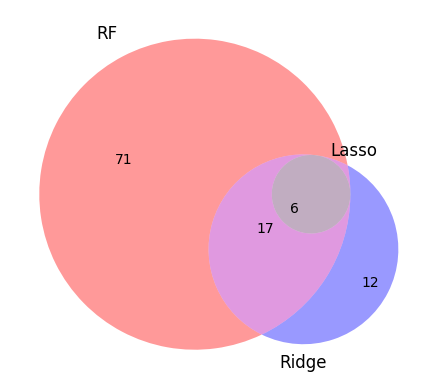

In [77]:
from matplotlib_venn import venn3

pheno_rf = train_test_data[0].loc[:, res_rfe_highint[0][1]].columns
pheno_lasso = train_test_data[0].loc[:, res_rfe_highint[1][1]].columns
pheno_ridge = train_test_data[0].loc[:, res_rfe_highint[2][1]].columns

venn3([set(pheno_rf), set(pheno_lasso), set(pheno_ridge)], ("RF",  "Lasso", 'Ridge'))

In [78]:
pheno_lasso

Index(['SORD', 'CYP2U1', 'THEM4', 'UCP3', 'KIF28P', 'FAM210A'], dtype='object')

We will now test with the smallest set of features established with both feature selection methods. The cluster set has twelve features and pheno ("extreme phenotypes") set consists of five. We use the `retain_features` functions to establish the appropriate datasets.

In [83]:
cluster_set = ['CHDH', 'G0S2', 'VPS54', 'UCP2', 'PACS2', 'FGR', 'SARM1', 'JARID2',
       'FYN', 'KIF1B', 'ADCK1', 'OAT', 'CRLS1', 'TFAP4', 'PDPR', 'POLRMT',
       'TSPO', 'RAB5IF', 'NTSR1', 'SNPH', 'BMF', 'MRPL51', 'COX7A2', 'PECR',
       'MTARC2', 'RAB32', 'ARG1', 'SIRT5', 'ROMO1', 'POR', 'RAC2', 'MRPS25',
       'MCCC2', 'ENOSF1', 'COQ10A', 'IER3', 'CYP1B1', 'SORD', 'BCL2A1', 'TP53',
       'SLC27A3', 'SFXN5', 'STOM', 'PDSS1', 'FEZ1', 'TIMM8B', 'CYP2U1',
       'ATP5MJ', 'HKDC1', 'TOMM40L', 'THEM4', 'RDH13', 'HK3', 'SLC25A45',
       'UQCRQ', 'MMADHC', 'MFF', 'FAM110B', 'CA5B', 'GIMAP8', 'UCP3', 'TMEM70',
       'MSRA', 'TDRKH', 'AIFM3', 'ANKRD37', 'FHIT', 'PTPN1', 'SDHAF3',
       'METTL9', 'SRC', 'SYNJ2BP', 'DDAH2', 'CEBPZOS', 'EPHA4', 'SGK1',
       'GRPEL2', 'FAM210A']
pheno_set = ['SORD', 'CYP2U1', 'THEM4', 'UCP3', 'KIF28P', 'FAM210A']

cluster_train = retain_features(cluster_set, train_test_data)
pheno_train = retain_features(pheno_set, train_test_data)

The training on the cluster set good scores, almost perfect for all models. This could suggest overfitting, especially in the `two` class. This class has more samples and is the milder endotype. The `two` class has almost perfect recall, and `one` is around 0.83. Interestingly, naïve Bayes can predict `two` perfectly but has trouble with `one` (recall is just 0,17).

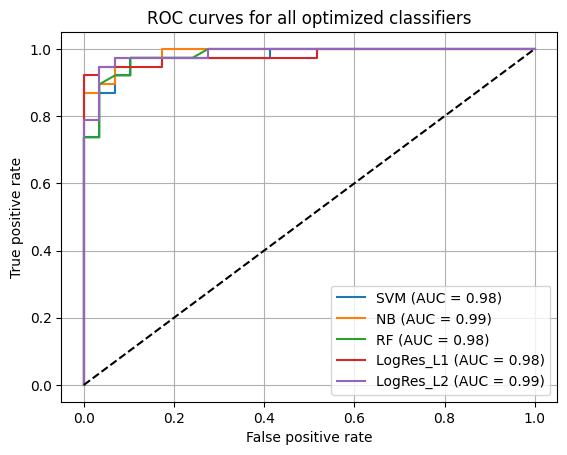

In [84]:
train_cluster_red = {}

for name, model in models.items():
    train_cluster_red[name] = te.train(cluster_train, model, cls="cluster", plot=True)

te.roc_in_one(train_cluster_red)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.96      0.90      0.93        29
         two       0.93      0.97      0.95        38

    accuracy                           0.94        67
   macro avg       0.94      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67

The resulting classification report for NB 
               precision    recall  f1-score   support

         one       1.00      0.79      0.88        29
         two       0.86      1.00      0.93        38

    accuracy                           0.91        67
   macro avg       0.93      0.90      0.91        67
weighted avg       0.92      0.91      0.91        67

The resulting classification report for RF 
               precision    recall  f1-score   support

         one       0.96      0.83      0.89        29
         two       0.88      0.97      0.93        38

    accuracy                           0.91   

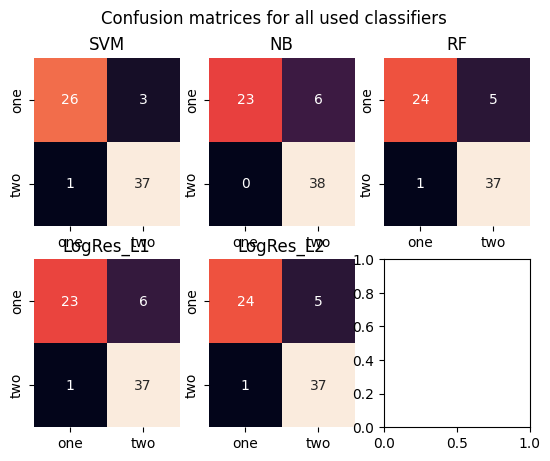

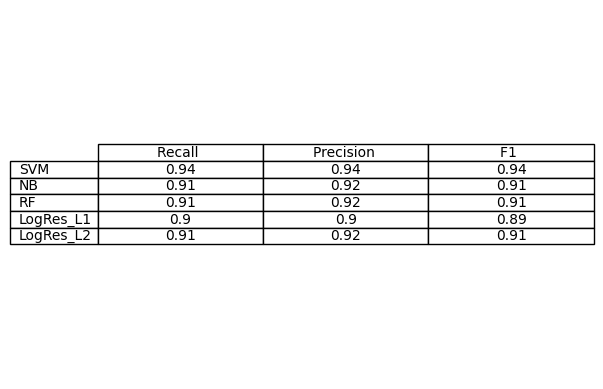

In [85]:
te.visualize_results(train_cluster_red)

Cross-validation paints a similar picture: perfect scores all around, which might be because of overfitting. Furthermore, again with naïve Bayes: excellent scores in predicting `two` and very bad prediction capabilities with `one`. 

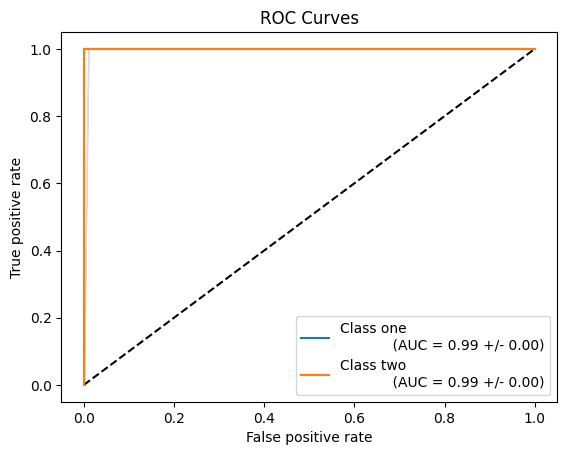

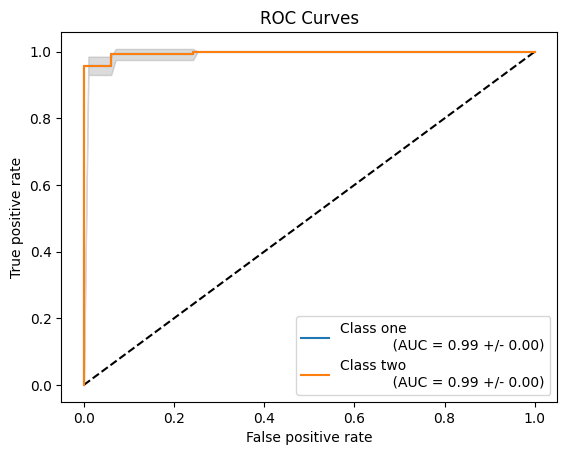

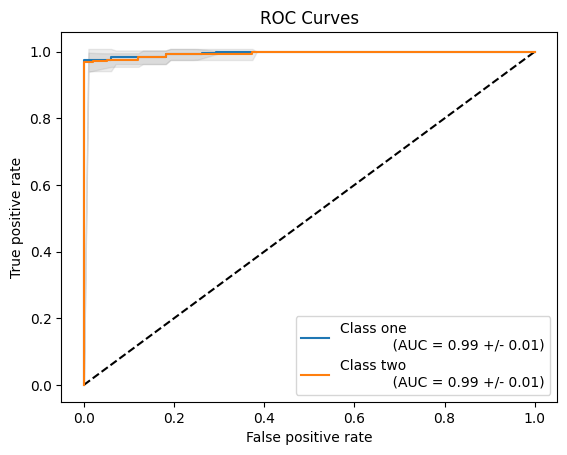

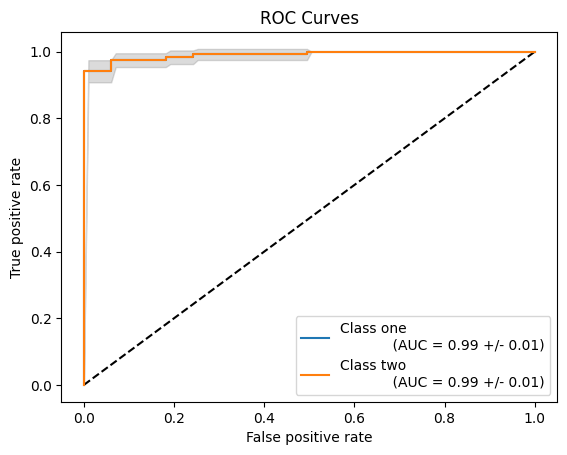

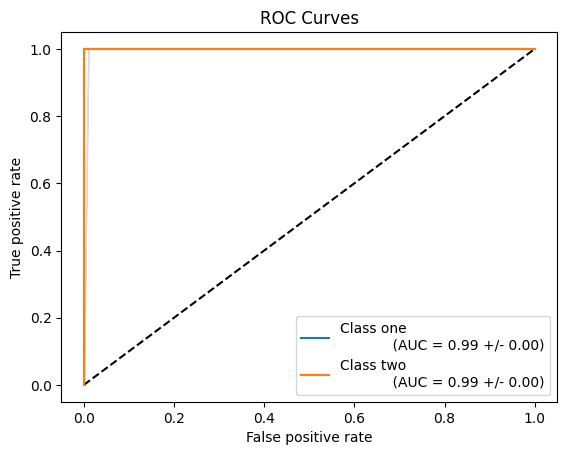

In [86]:
cross_cluster_red = {}

for name, model in models.items():
    cross_cluster_red[name] = te.cross_val(cluster_train, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       1.00      0.96      0.98        80
         two       0.98      1.00      0.99       119

    accuracy                           0.98       199
   macro avg       0.99      0.98      0.98       199
weighted avg       0.99      0.98      0.98       199

The resulting classification report for NB 
               precision    recall  f1-score   support

         one       0.99      0.90      0.94        80
         two       0.94      0.99      0.96       119

    accuracy                           0.95       199
   macro avg       0.96      0.95      0.95       199
weighted avg       0.96      0.95      0.95       199

The resulting classification report for RF 
               precision    recall  f1-score   support

         one       0.95      0.94      0.94        80
         two       0.96      0.97      0.96       119

    accuracy                           0.95   

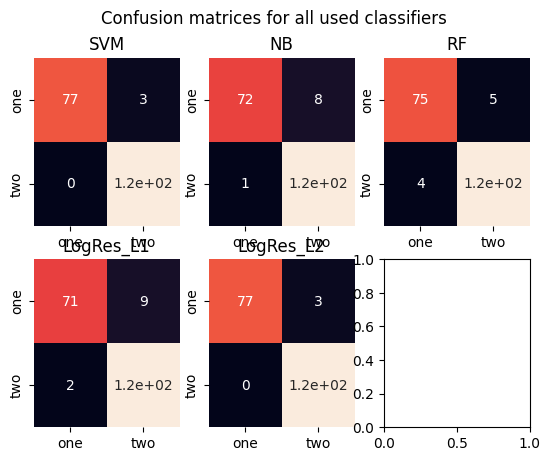

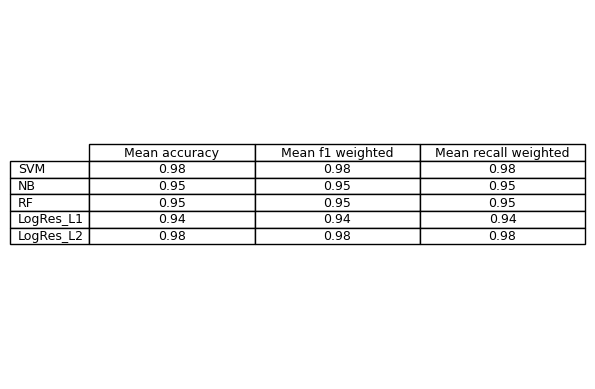

In [87]:
te.visualize_results(cross_cluster_red)

Most classifiers do a good job in predicting the endotype group, with having similar test and cross-validation scores, reflecting that there is no overfitting. However, there are some noteworthy findings. Random Forest and SVM are already at a perfect score of 1.0 at the very beginning; others start at a lower point and increase to around 1.00 later on. Naïve Bayes has lower scores, around 0.80, but the training and cross-validation scores seem to be in line.

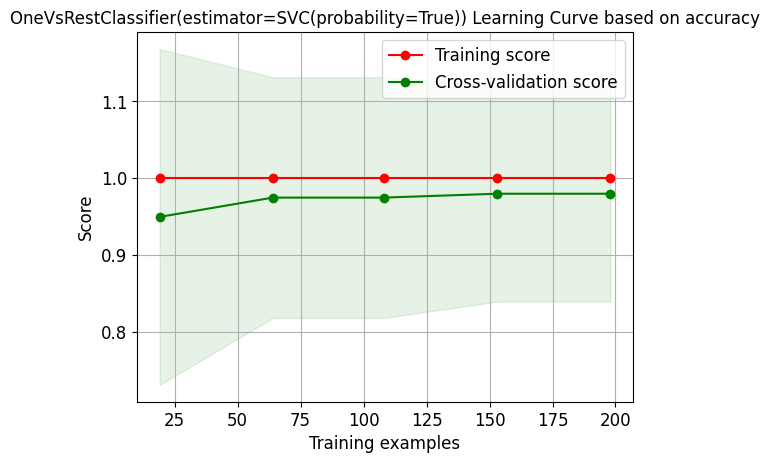

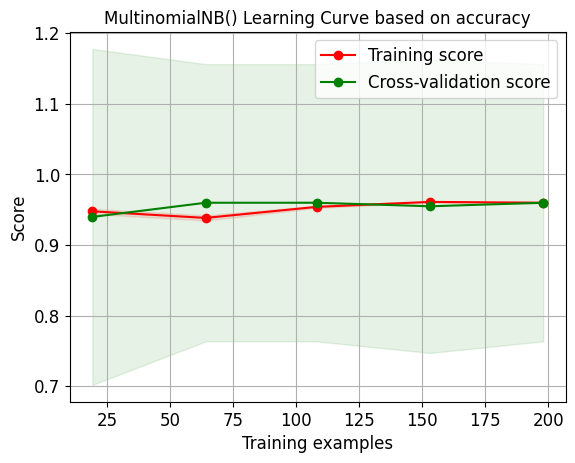

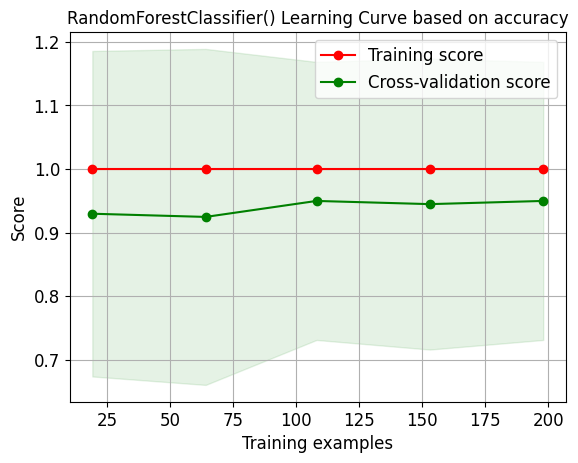

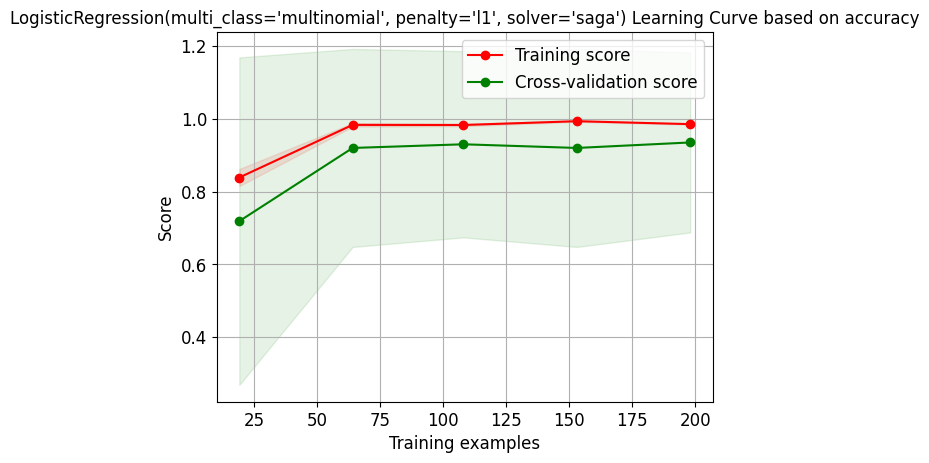

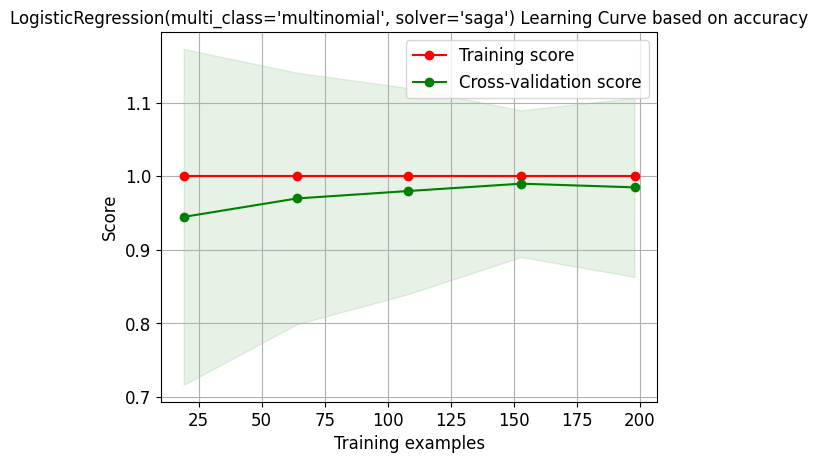

In [66]:
for name, model in models.items():
    te.train_and_cross(cluster_train, model, cls = 'cluster')

Now, we take a look at the feature set established for the `highint_low` variable.

The results here are somewhat worse than when using all DEGs. For instance, Logistic regression with L1 and L2 decreased from 0.74 to 0.71 and 0.71, respectively. Others experienced a similar downgrade in AUC. Naïve Bayes cannot distinguish between High-Int (recall score of 1.00) and Low (recall score of 0.00) very well.

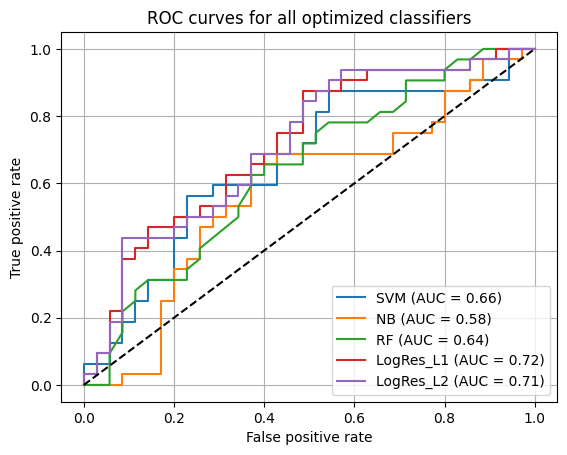

In [88]:
train_highint_red = {}

for name, model in models.items():
    train_highint_red[name] = te.train(pheno_train, model, cls="highint_low", plot=True)

te.roc_in_one(train_highint_red)

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.65      0.57      0.61        35
         Low       0.58      0.66      0.62        32

    accuracy                           0.61        67
   macro avg       0.61      0.61      0.61        67
weighted avg       0.62      0.61      0.61        67

The resulting classification report for NB 
               precision    recall  f1-score   support

    High-Int       0.52      1.00      0.69        35
         Low       0.00      0.00      0.00        32

    accuracy                           0.52        67
   macro avg       0.26      0.50      0.34        67
weighted avg       0.27      0.52      0.36        67

The resulting classification report for RF 
               precision    recall  f1-score   support

    High-Int       0.63      0.54      0.58        35
         Low       0.57      0.66      0.61        32

    accuracy                           0.60   

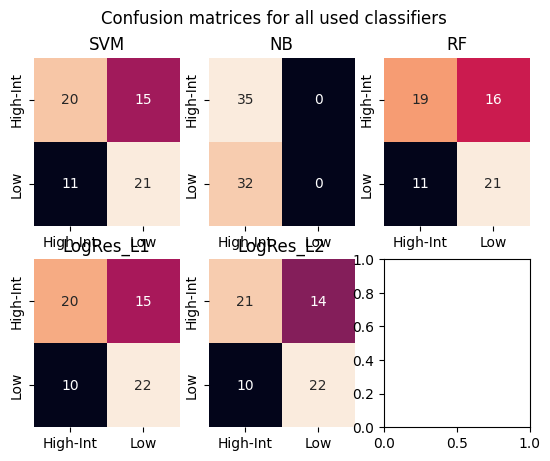

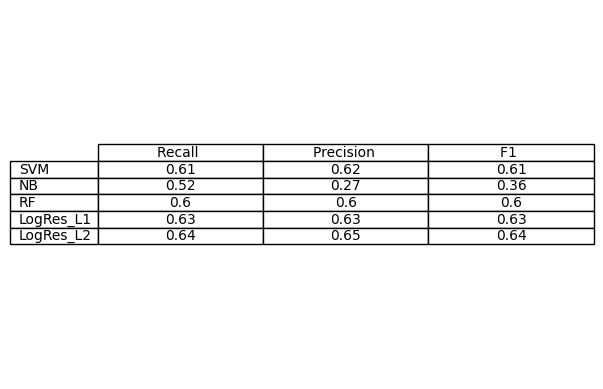

In [89]:
te.visualize_results(train_highint_red)

Cross-validation scores seem okay. The best-scoring model is L2 - scoring an accuracy of 0.75 with a standard deviation of 0.08. Naïve Bayes still has trouble with the distinction between High-int (recall score of 1) and Low (recall score of 0.00).

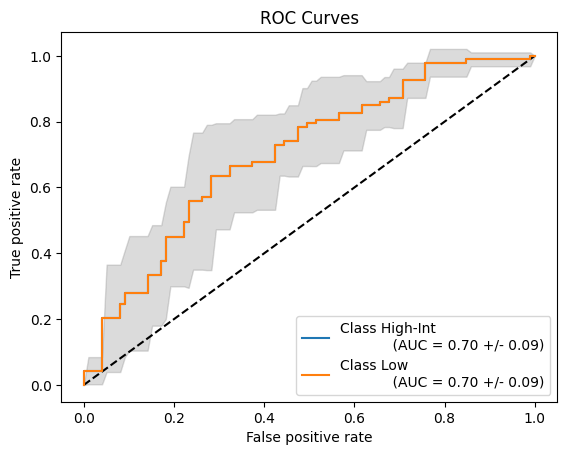

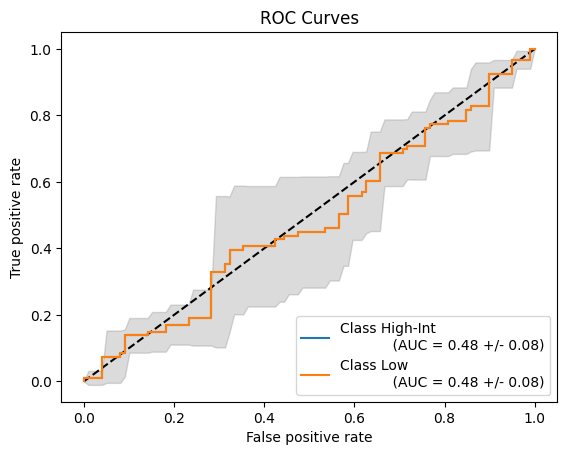

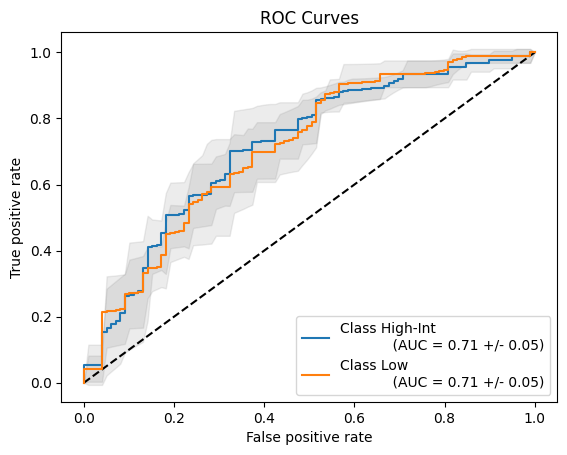

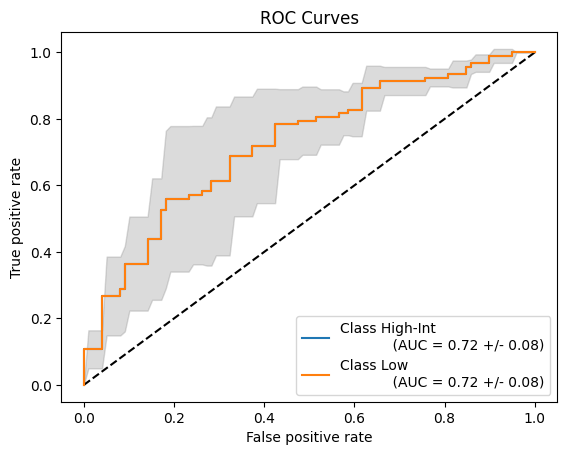

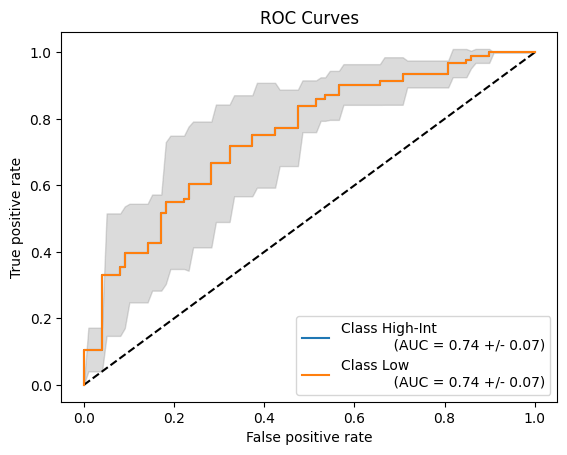

In [90]:
cross_highint_red = {}

for name, model in models.items():
    cross_highint_red[name] = te.cross_val(pheno_train, model, cls='highint_low', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.68      0.63      0.65       106
         Low       0.61      0.66      0.63        93

    accuracy                           0.64       199
   macro avg       0.64      0.64      0.64       199
weighted avg       0.65      0.64      0.64       199

The resulting classification report for NB 
               precision    recall  f1-score   support

    High-Int       0.53      1.00      0.70       106
         Low       0.00      0.00      0.00        93

    accuracy                           0.53       199
   macro avg       0.27      0.50      0.35       199
weighted avg       0.28      0.53      0.37       199

The resulting classification report for RF 
               precision    recall  f1-score   support

    High-Int       0.68      0.71      0.69       106
         Low       0.65      0.62      0.64        93

    accuracy                           0.67   

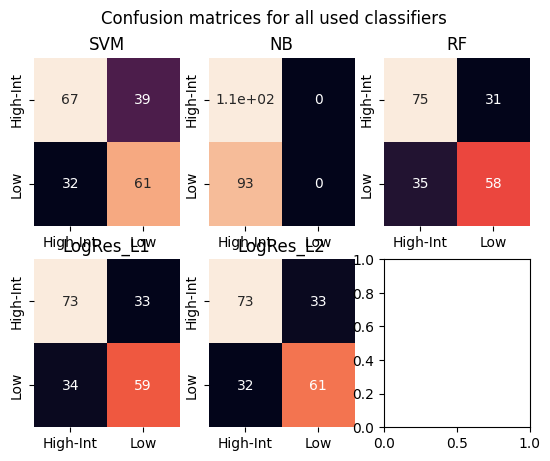

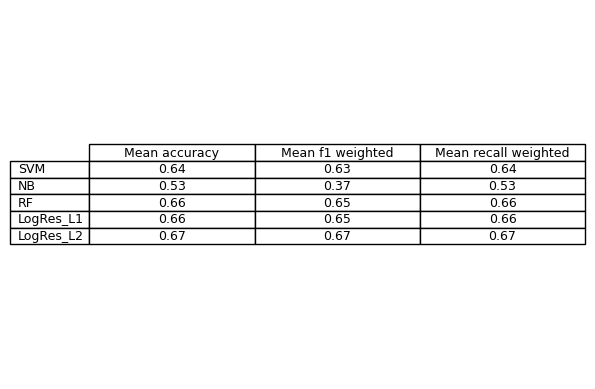

In [91]:
te.visualize_results(cross_highint_red)

Overfitting seems to be gone in most models when working with this reduced gene set. However, Random Forest is still severely overfitted, as its training accuracy is never lower than 1.0. The rest of the models have training and cross-validation scores between 0.60 and 0.80, but Naïve Bayes is slightly lower at 0.40 and 0.60. The naïve Bayes and Random Forest models might have to be retired.

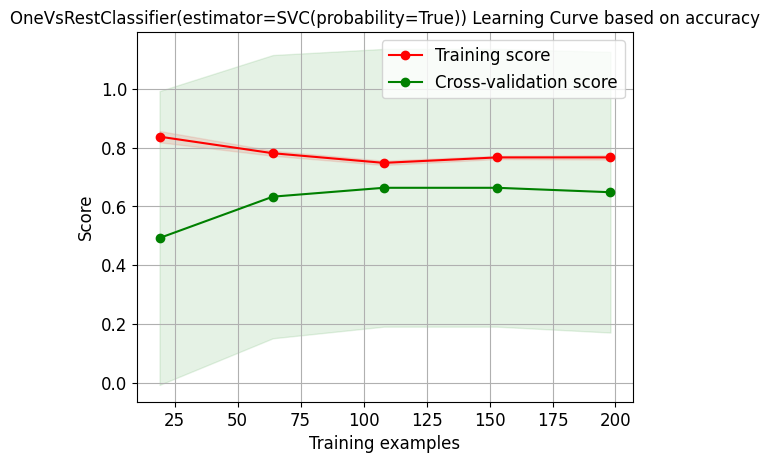

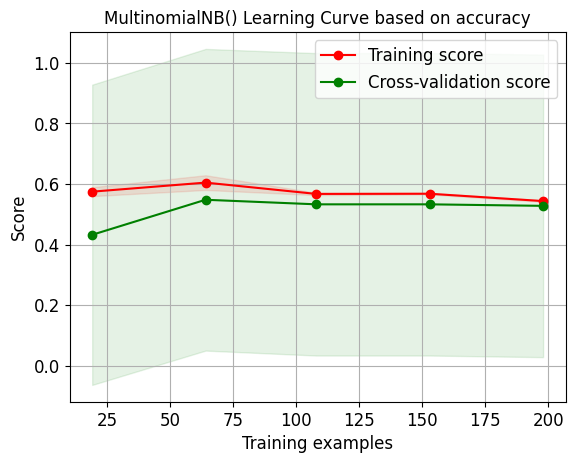

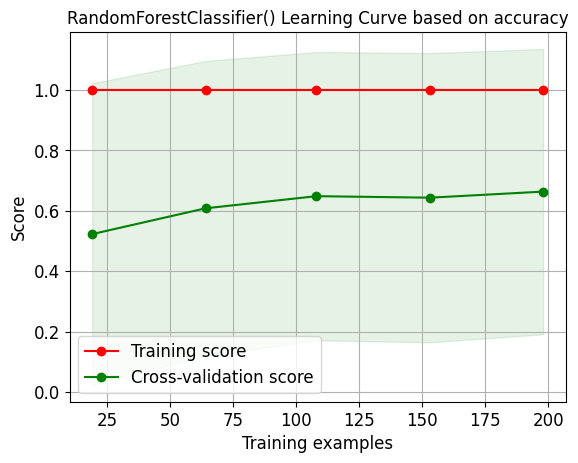

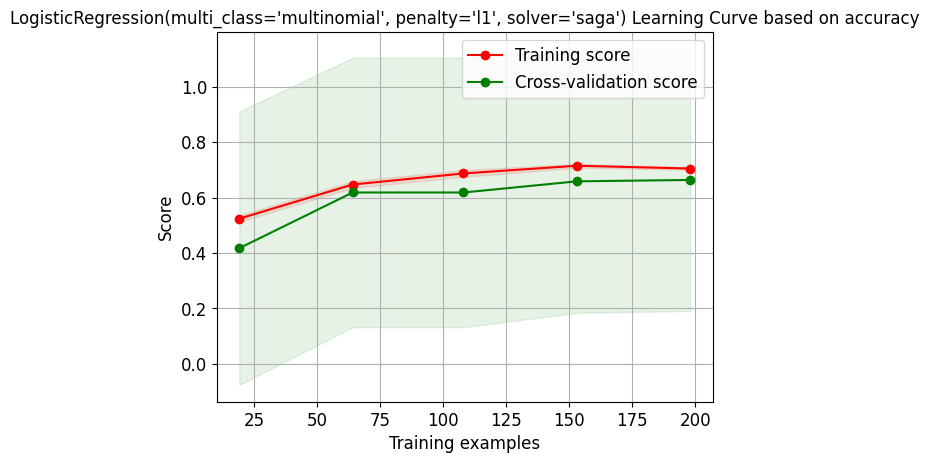

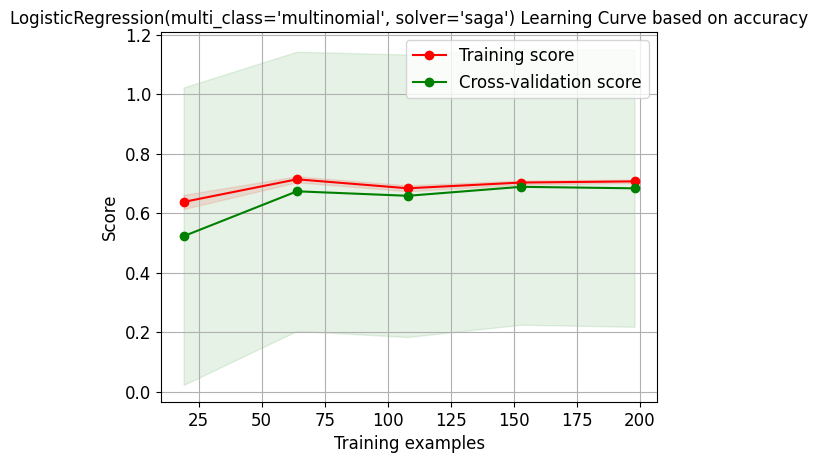

In [289]:
for name, model in models.items():
    te.train_and_cross(pheno_train, model, cls = 'highint_low')

### <a id='own_functions'>Feature Selection: Own Functions</a>

The reason for us to go for our own implementation of feature selection is to have an alternative way of discovering the best feature set. `RFECV` seems to be a good way of selecting features, as the problem of overfitting was solved in most models after using the `pheno_set`, consisting of six genes.

We have seen that RandomForestClassifier is still severely overfitted, and that is why we will no longer consider it as a model. Naïve Bayes has the worst performance of all models and is, of course, a rather simple model and does not have the capability to be used on our data. Therefore, we will remove this model as well. Now, we consider only three models from now on: `SVM`, `LogisticRegression` with LASSO (L1) and `LogisticRegression` with Ridge (L2). 

In [92]:
models = {"SVM":OneVsRestClassifier(SVC(probability=True)), 
          "LogRes_L2": LogisticRegression(penalty='l2', multi_class='multinomial', solver='saga'),
          "LogRes_L1": LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')}

The `assess_feature_importances` assesses features based on either a `importance_features_` or `coef_` attribute. These attributes are, therefore, model-dependent. This function uses either a logistic regression or a random forest as a selector to rank genes. These ranked genes are then used and evaluated in batches that the user specifies; for instance, we use a batch size of one here and set the stop parameter to 30. This implies that the function assesses thirty different gene sets by adding the most important ranked gene during each loop until the size of the gene set is equal to 30. We will start feature selection on `highint_low` again. 

We consider five different feature selections here:
* Random Forest
* Mutual information (non-model dependent)
* LASSO (L1)
* ElasticNet (uses a L1/L2 ratio)
* Ridge (L2)

Let us start with Random Forest; even though it was overfitted, it still might be beneficial to see which gene sets it comes up with:

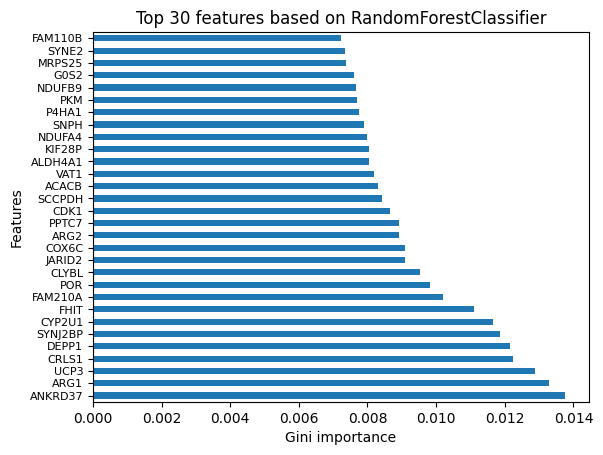

In [93]:
rf = te.assess_feature_importances(train_test_data, models, plot=True, batch_size=1, stop=30, cls='highint_low')

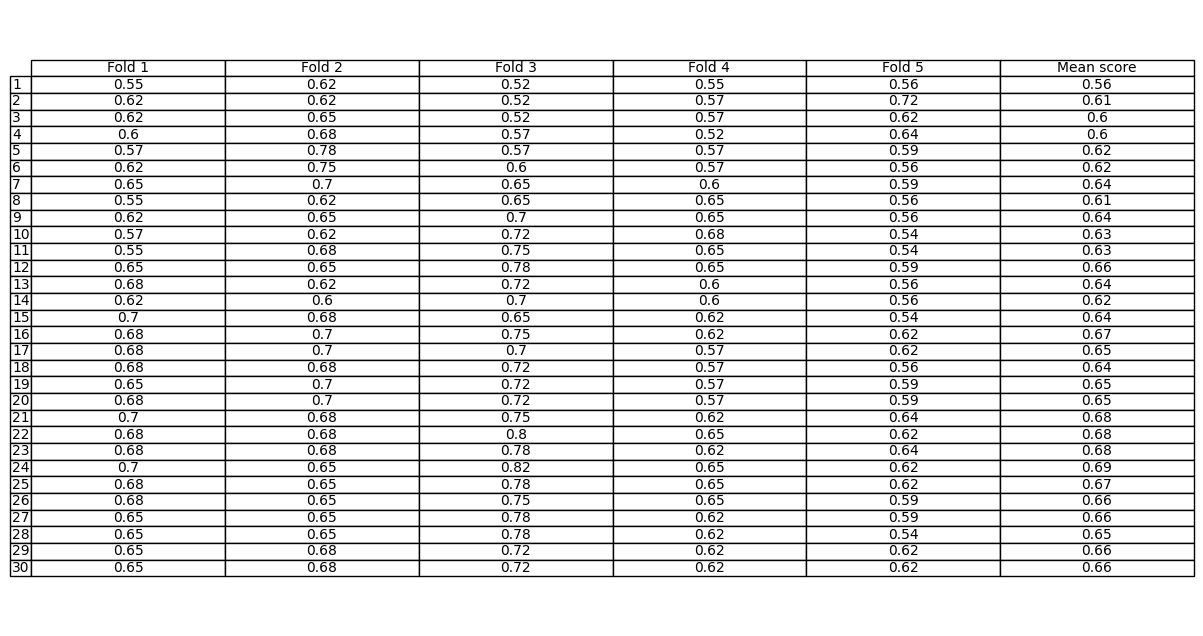

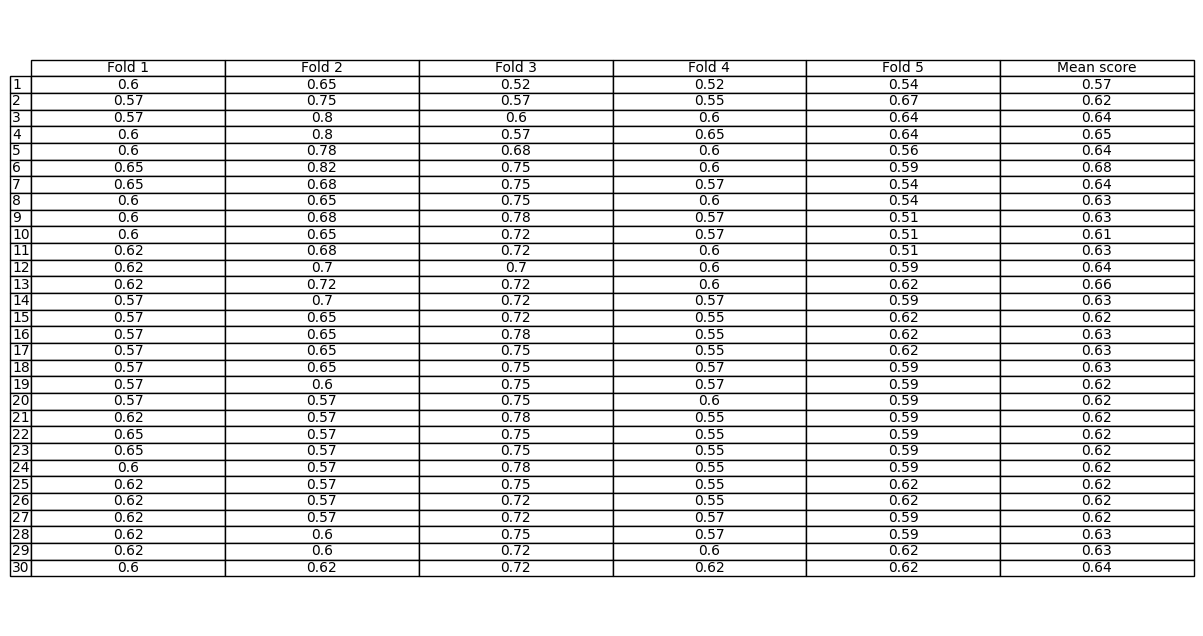

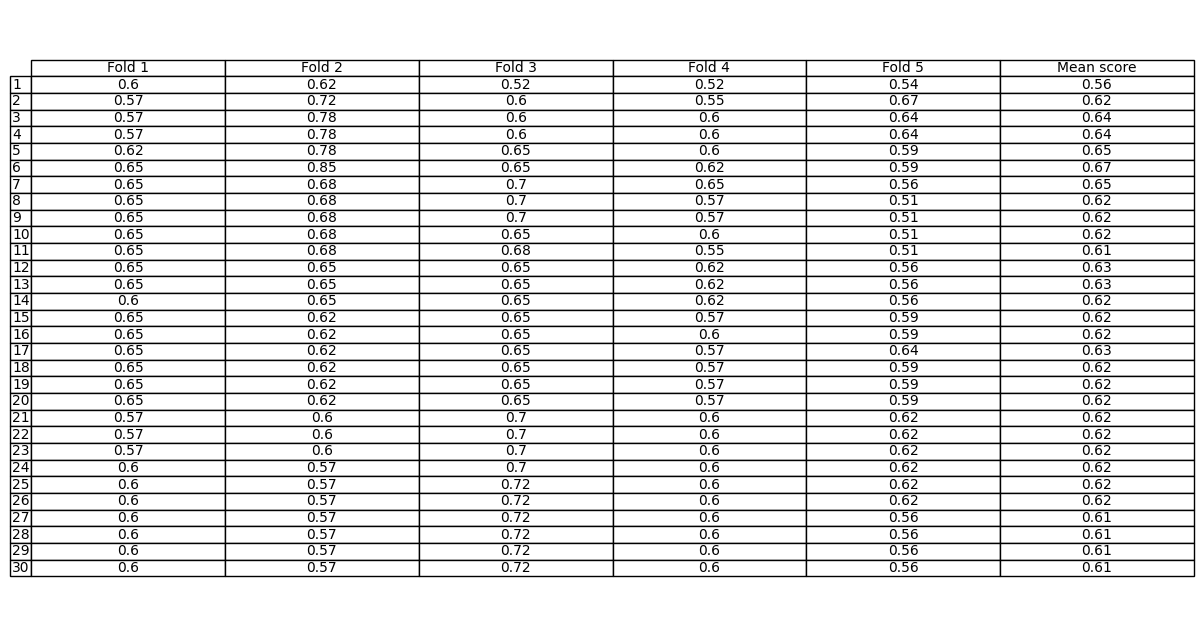

In [94]:
for i, scene in enumerate(rf[1]):
    te.plot_table(scene[1])

The scores here start to fluctuate between scores, which is a sign of overfitting. This means that to prevent overfitting, we will select the highest earliest-scoring gene set and stop there. If we would continue to add more, the diminishing returns might suggest that the most impactful genes are included in the set. For a model based on Random Forest, this would be at four genes. All models support this conclusion:
* SVM: mean score of 0.72
* L1: mean score of 0.65
* L2: mean score of 0.64, even though a three gene set had similar score

Since RF was overfitted, we will not consider this gene set.

The next method we will try is mutual information - a model-independent way to assess dependency between variables (it quantifies the amount of information obtained about one variable through another).

In [95]:
mutual_info = te.assess_feature_importances(train_test_data, models, selector=None, batch_size=1, stop=30, cls='highint_low')

In [21]:
mutual_info_[0]

Index(['CHDH', 'SLC44A1', 'ARG2', 'ACOD1', 'OLFM4', 'MLYCD', 'ABCB6', 'ADPRS',
       'G0S2', 'IQCN',
       ...
       'GPER1', 'DEPP1', 'IFI27', 'GPT2', 'BCL2', 'TOMM5', 'MTX3', 'FAM210A',
       'ACADSB', 'VPS13A'],
      dtype='object', length=201)

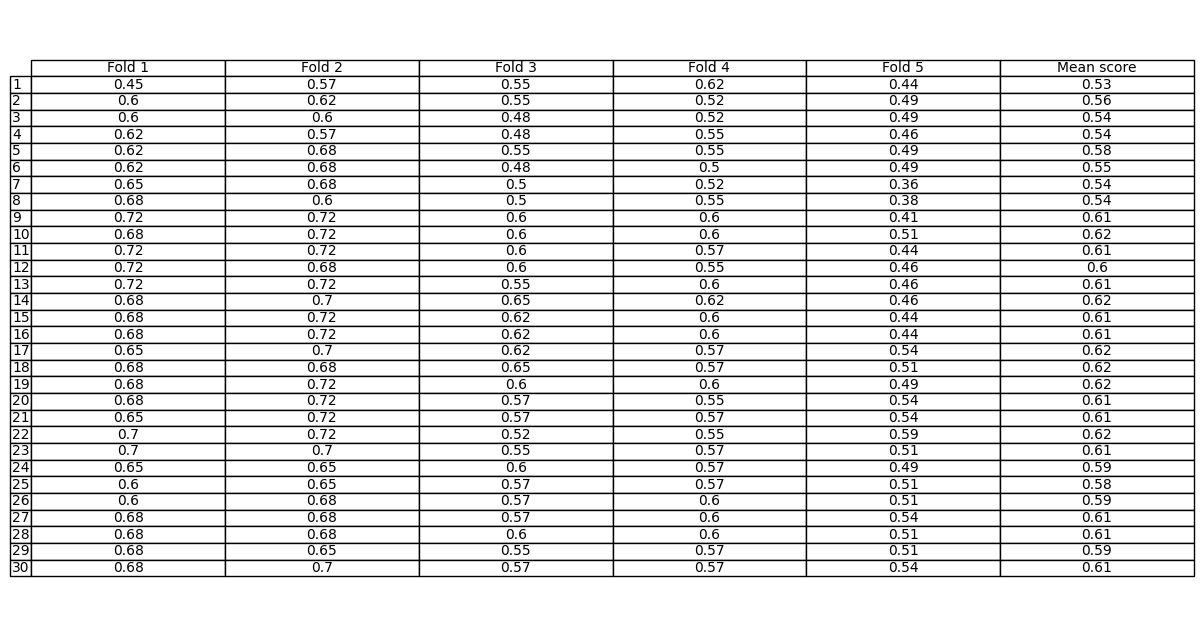

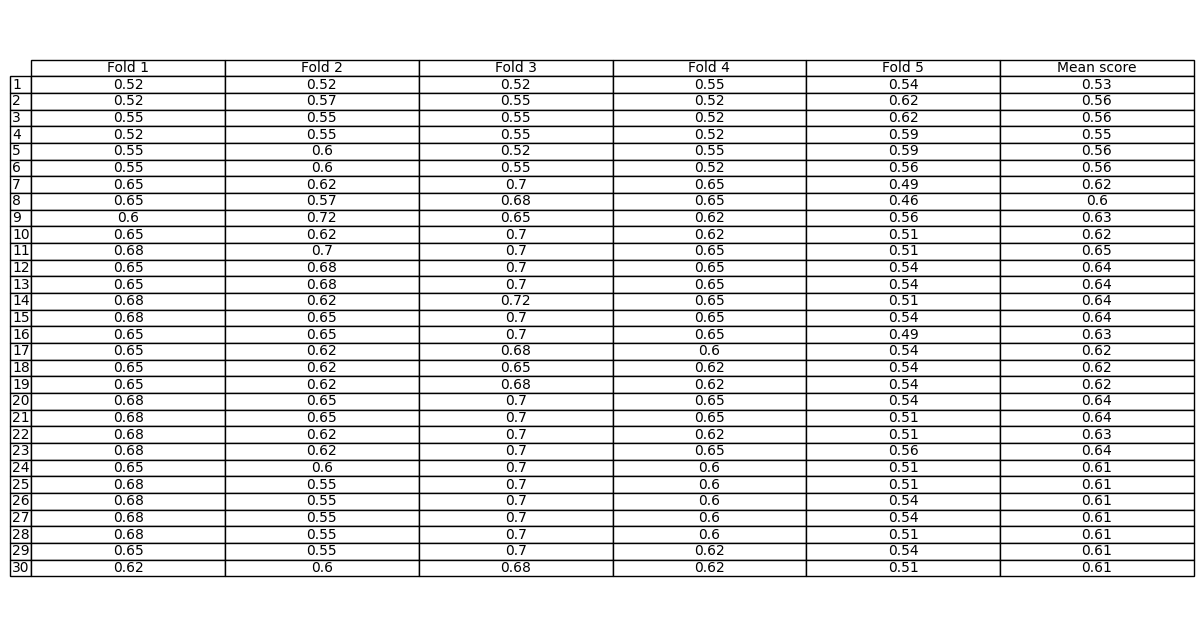

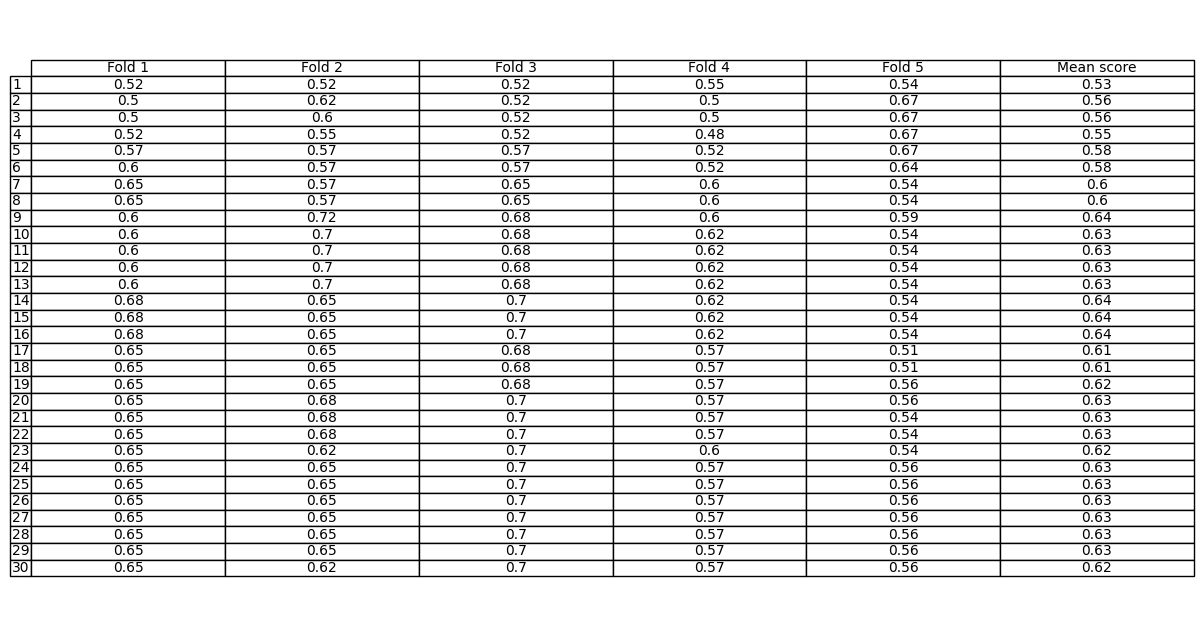

In [96]:
for i, scene in enumerate(mutual_info[1]):
    te.plot_table(scene[1])

The scores here start to fluctuate between scores, which is a sign of overfitting. For a model based on feature selection on mutual information, this would be at nine genes. Most models support this conclusion, as their peak is on nine genes and begin to dwindle after that:
* SVM: mean score of 0.61
* L1: mean score of 0.63
* L2: mean score of 0.64

[autoreload of train_and_evaluate failed: Traceback (most recent call last):
  File "C:\Users\Jamie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Jamie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'train_and_evaluate'
]
[autoreload of train_and_evaluate failed: Traceback (most recent call last):
  File "C:\Users\Jamie\App

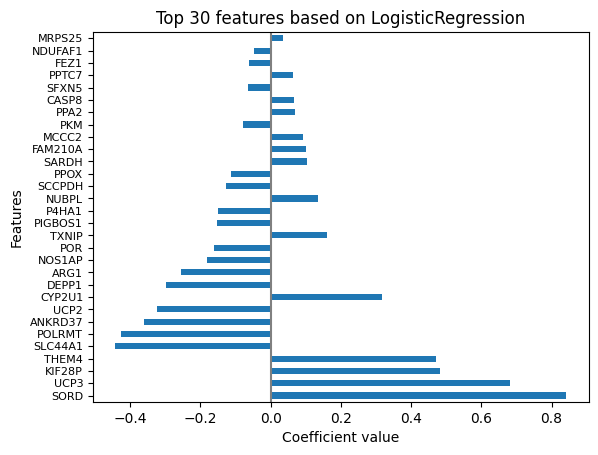

In [174]:
lasso_res = te.assess_feature_importances(train_test_data, models, 
                                          selector=LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga'), 
                                          plot=True, batch_size=1, stop=30, cls='highint_low')

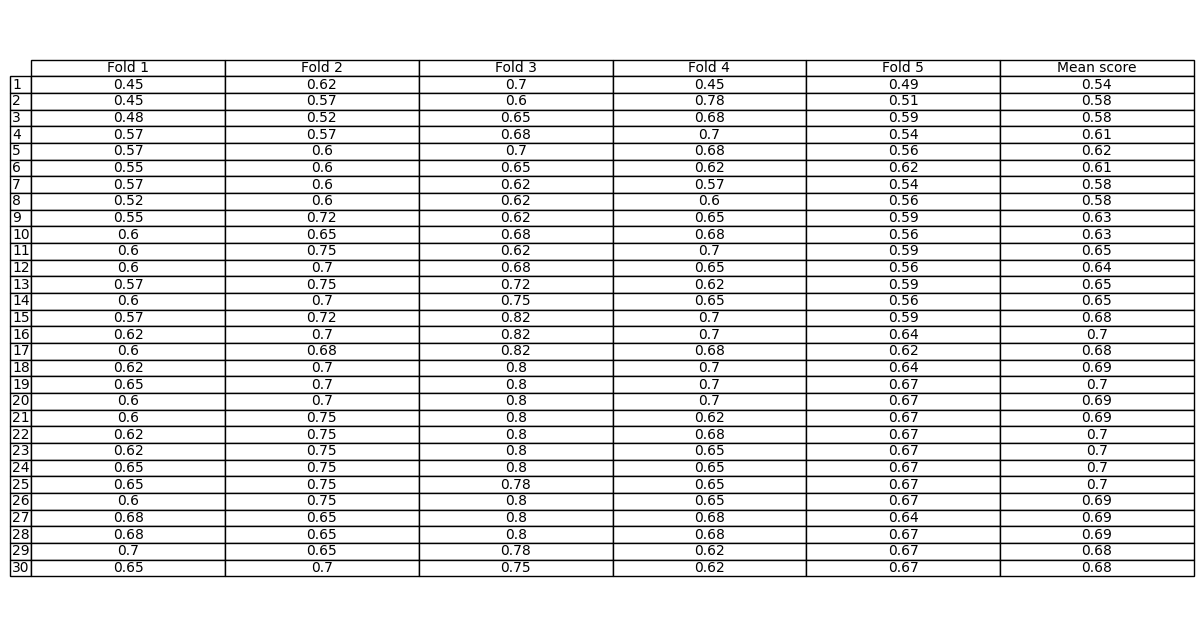

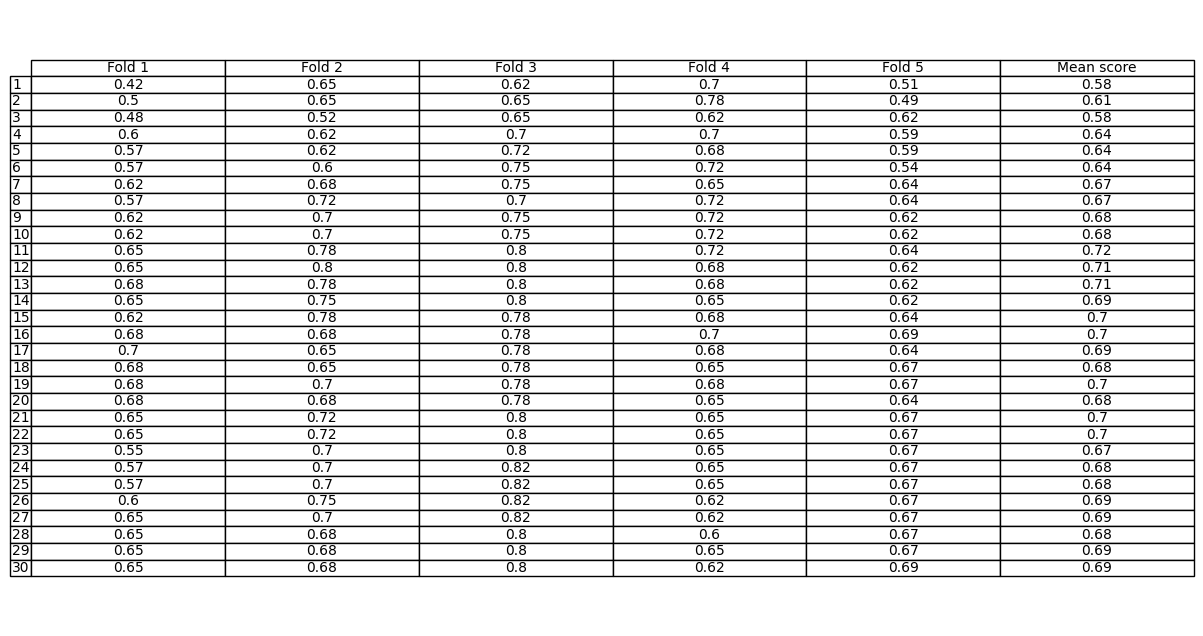

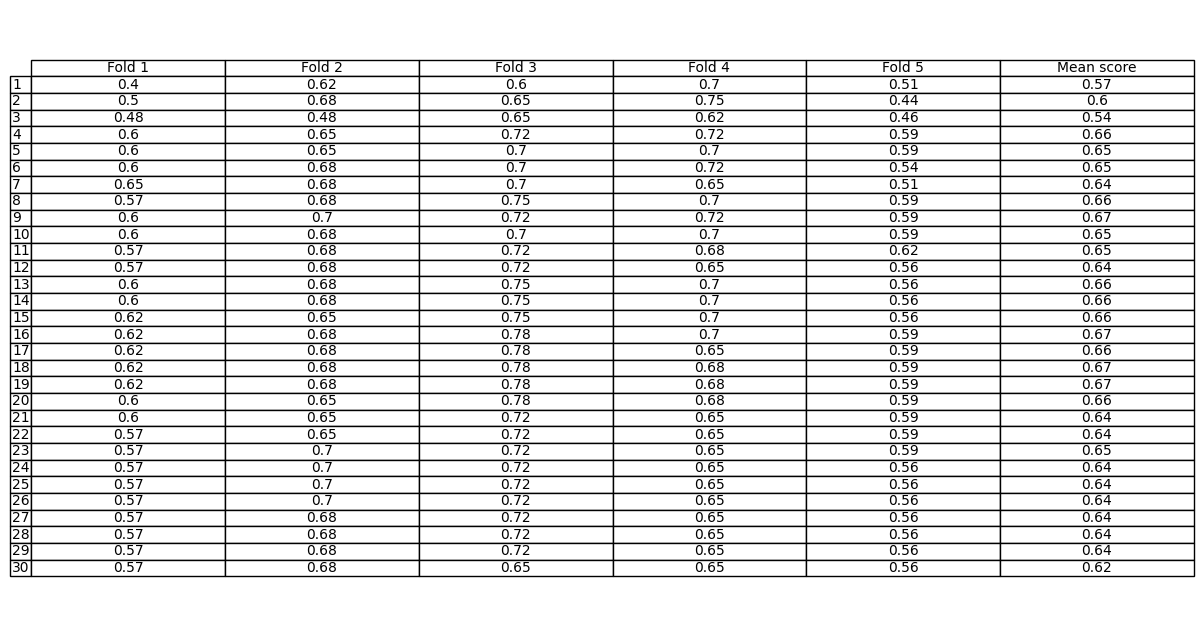

In [98]:
for i, scene in enumerate(lasso_res[1]):
    te.plot_table(scene[1])

The scores here fluctuate between scores, which is a sign of overfitting. For a model based on feature selection on L1, this would be at ten genes. Most models support this conclusion, as their peak is on eleven genes and begin to dwindle after that:
* SVM: mean score of 0.63
* L1: mean score of 0.68
* L2: mean score of 0.65, even though nine had a score of 0.67

This gene set is tailored for L1, so it might be beneficial for this gene set to be considered for this model.

Next, we consider a feature selection based on ElasticNet, which has a ratio between L1 and L2 regularization. We will not consider the final gene set in this method, but observing overlap between essential genes might be a good reason to consider this method.

In [99]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

x_train, _, y_train, _ = train_test_data
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train['highint_low'])

selector = ElasticNet()

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 5, 10],
    'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
}

grid_search = GridSearchCV(estimator=selector, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}


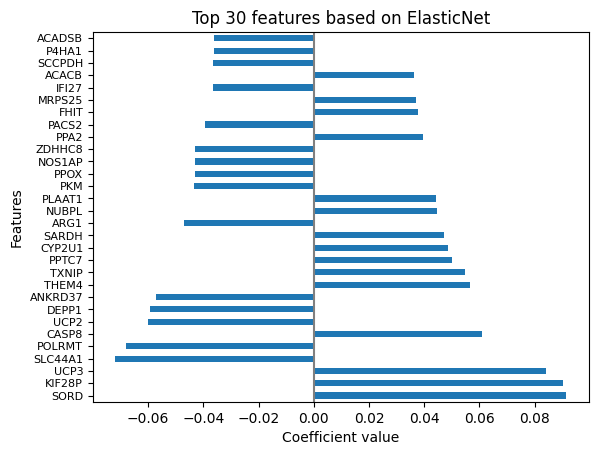

In [100]:
elastic_res = te.assess_feature_importances(train_test_data, models, 
                                          selector=ElasticNet(alpha=0.1, l1_ratio=0.01), 
                                          plot=True, batch_size=1, stop=30, cls='highint_low')

Genes like _SORD_, _KIF28P_, and _UCP3_ are also in logistic regression with L1 and L2.

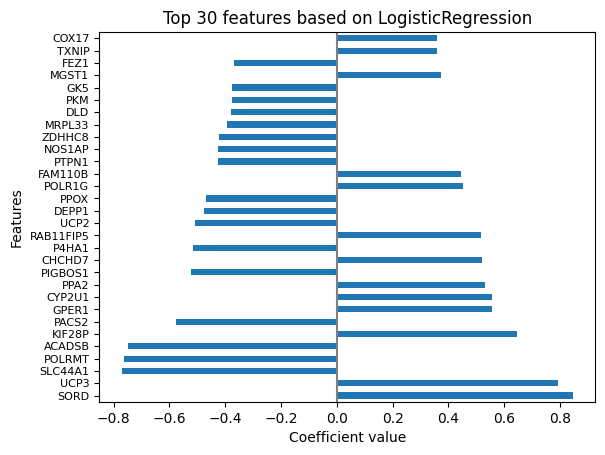

In [175]:
ridge_res = te.assess_feature_importances(train_test_data, models,
                                          selector=LogisticRegression(penalty='l2', multi_class='multinomial', solver='saga'), 
                                          plot=True, batch_size=1, stop=30, cls='highint_low')

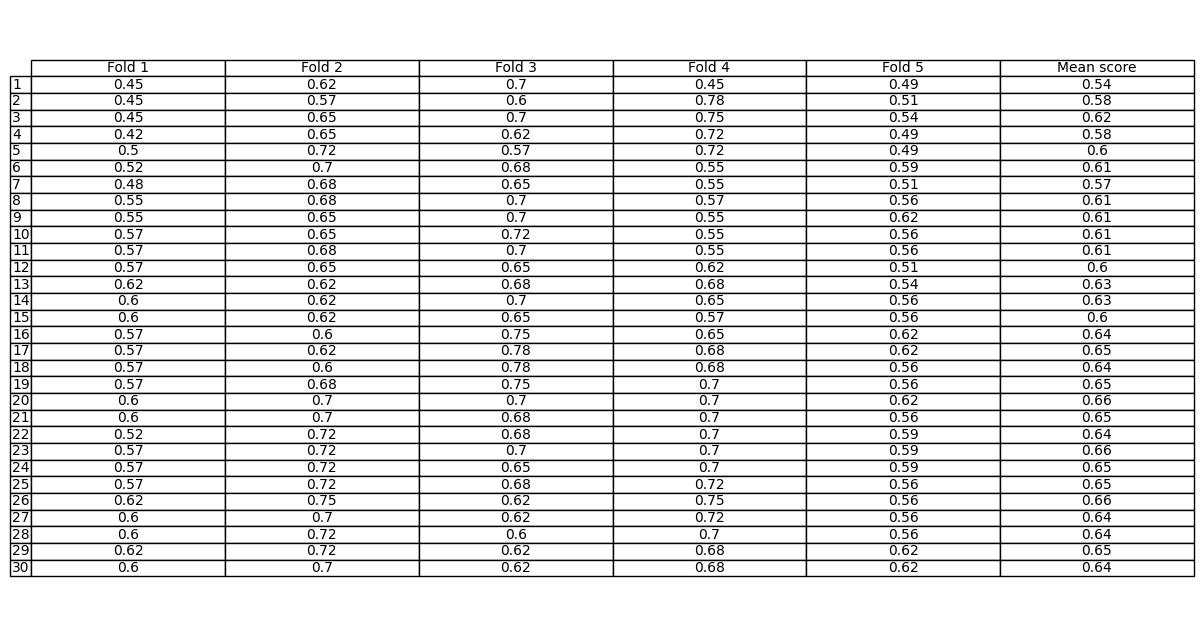

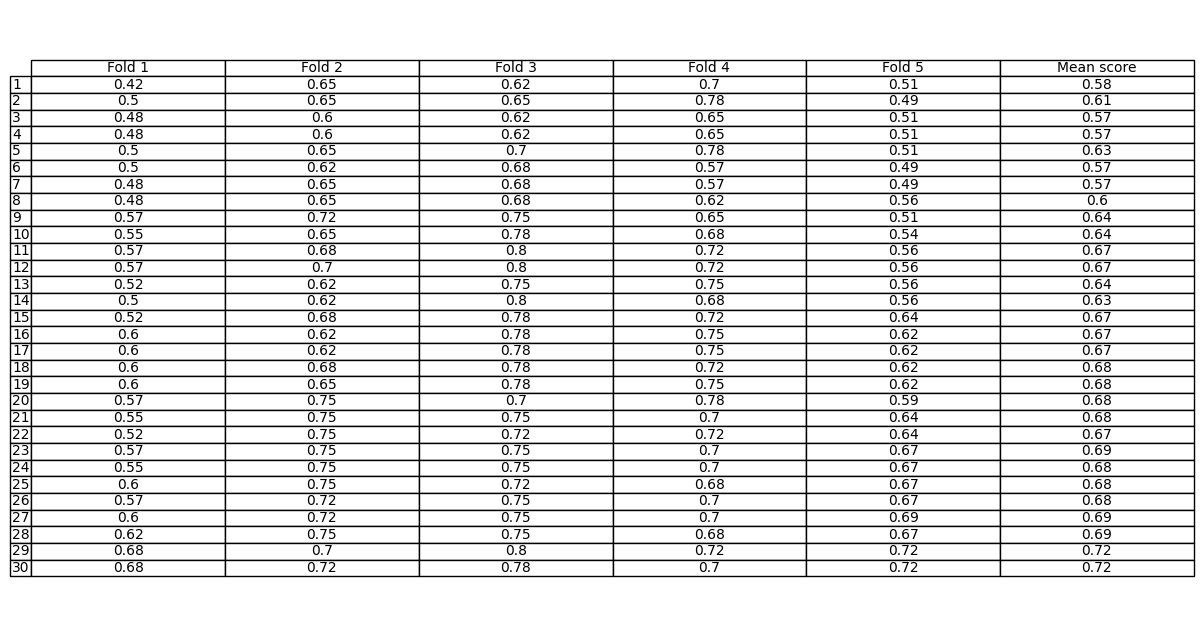

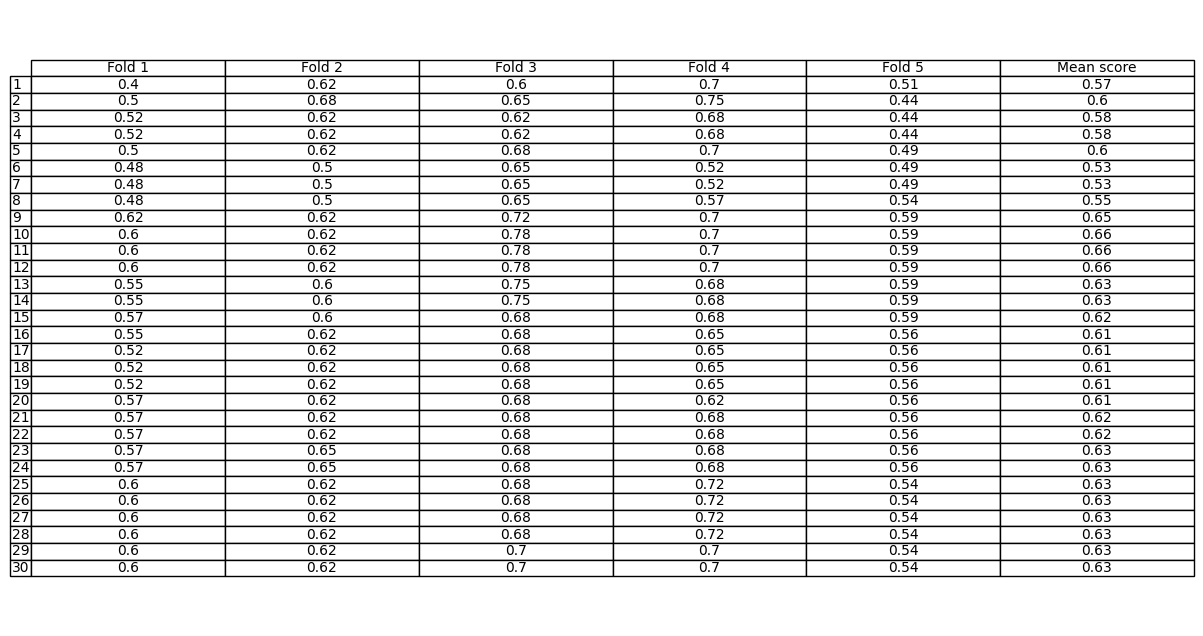

In [102]:
for i, scene in enumerate(ridge_res[1]):
    te.plot_table(scene[1])

The scores here fluctuate between scores, which is a sign of overfitting. For a model based on feature selection on L2 regularization, this would be at five genes. Most models support this conclusion, as their peak is on eleven genes and begin to dwindle after that:
* SVM: mean score of 0.60, even though three had the same score
* L1: mean score of 0.63
* L2: mean score of 0.60

This gene set is tailored for L2, so it is beneficial for this gene set to be considered for this model.

## <a id='after_feature_selection'>After Feature Selection<a/>

We have now established three gene sets, each from a different feature selection method.

A Venn diagram is available of these gene sets and how they overlap in the Rmarkdown `differences_genes.Rmd`

We will take a look at how these gene sets predict the different class variables (`cluster` and `highint_low`).

In [113]:
nine = ['P2RY1', 'OAT', 'RAB5IF', 'TSPO', 'SARM1', 'CLYBL', 'TMEM70', 'CYP1B1', 'DEPP1']
five = ['SORD', 'UCP3', 'SLC44A1', 'POLRMT', 'ACADSB']
eleven = ['SORD', 'UCP3', 'KIF28P', 'THEM4', 'SLC44A1', 'POLRMT', 'ANKRD37', 'UCP2', 'CYP2U1', 'DEPP1', 'ARG1']
    
five_genes = retain_features(five, train_test_data)
nine_genes = retain_features(nine, train_test_data)
eleven_genes = retain_features(eleven, train_test_data)

Even though the gene set is not tailored to clustering specifically, it still predicts rather well, scoring over 0.90 in AUC for all three models.

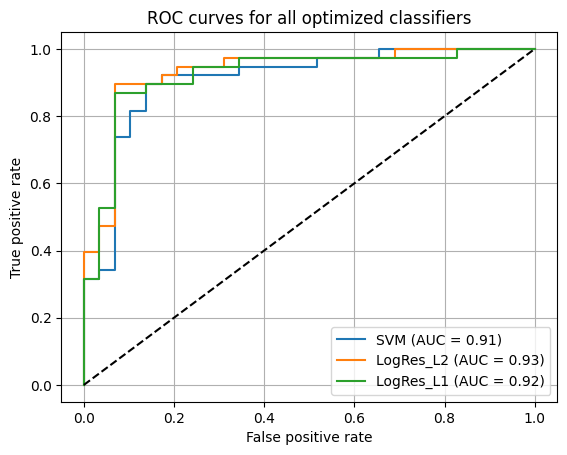

In [117]:
train_five_cluster = {}

for name, model in models.items():
    train_five_cluster[name] = te.train(five_genes, model, cls="cluster", plot=True)

te.roc_in_one(train_five_cluster)

The models seem to be biased towards the majority class (milder severity) when comparing precision and recall scores. The recall score, for example, is for SVM 0.76 for one and 0.92 for two.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.88      0.76      0.81        29
         two       0.83      0.92      0.88        38

    accuracy                           0.85        67
   macro avg       0.86      0.84      0.84        67
weighted avg       0.85      0.85      0.85        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.91      0.69      0.78        29
         two       0.80      0.95      0.87        38

    accuracy                           0.84        67
   macro avg       0.85      0.82      0.83        67
weighted avg       0.85      0.84      0.83        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.85      0.76      0.80        29
         two       0.83      0.89      0.86        38

    accuracy                    

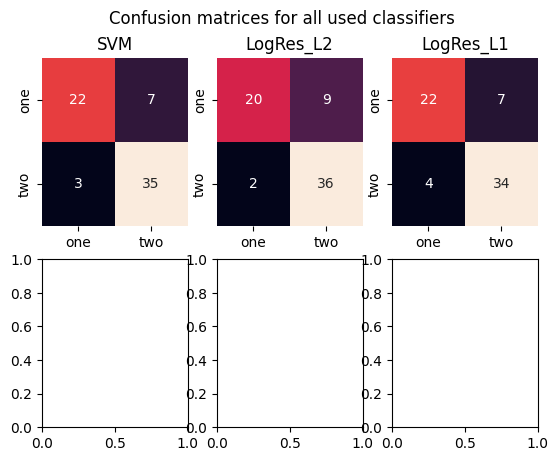

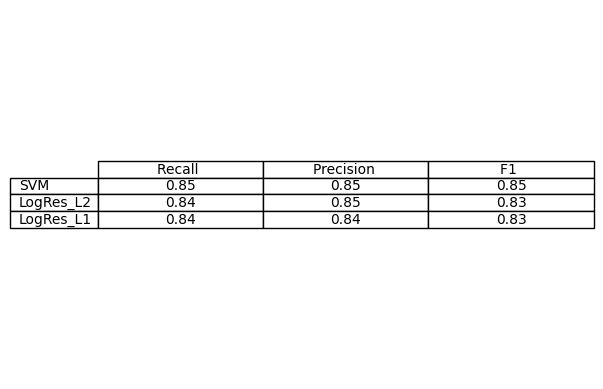

In [118]:
te.visualize_results(train_five_cluster)

AUC curves are the same for classes `one` and `two`, being above 0.87 with a standard deviation of +/- 0.05.

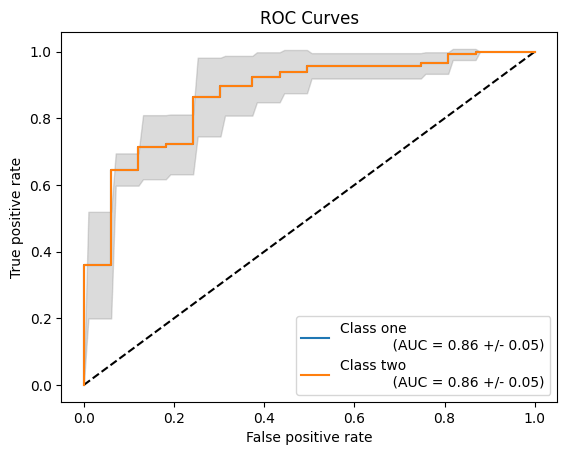

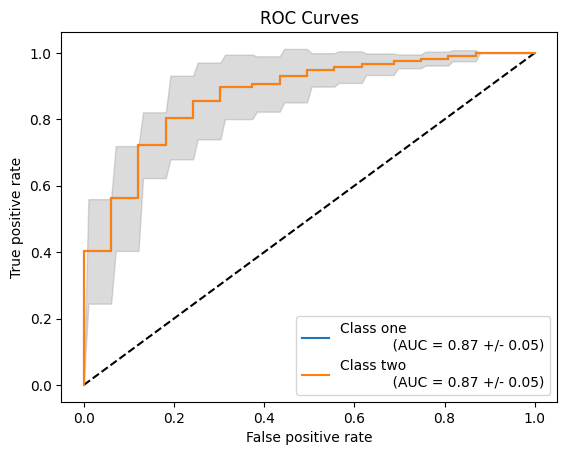

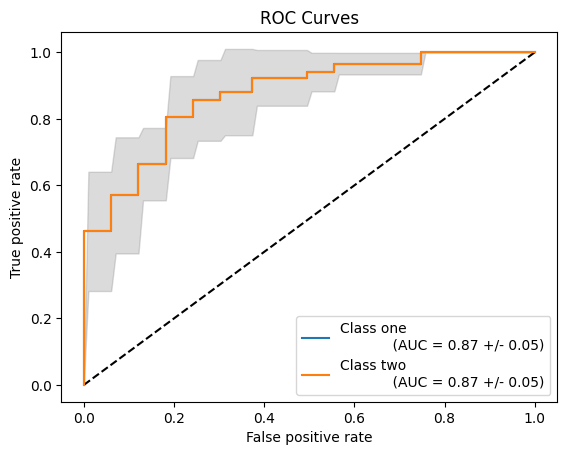

In [119]:
cross_five_cluster = {}

for name, model in models.items():
    cross_five_cluster[name] = te.cross_val(five_genes, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The bias here may be less extreme than we saw in the test set. However, scores still differ: `one` has lower recall (sensitivity) and is set at 0.66, whereas the `two` score is 0.87 for SVM.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.77      0.66      0.71        80
         two       0.79      0.87      0.83       119

    accuracy                           0.78       199
   macro avg       0.78      0.76      0.77       199
weighted avg       0.78      0.78      0.78       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.84      0.72      0.78        80
         two       0.83      0.91      0.87       119

    accuracy                           0.83       199
   macro avg       0.84      0.82      0.82       199
weighted avg       0.83      0.83      0.83       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.80      0.70      0.75        80
         two       0.81      0.88      0.85       119

    accuracy                    

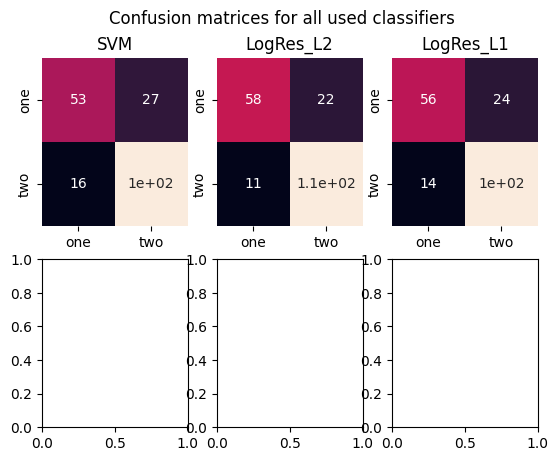

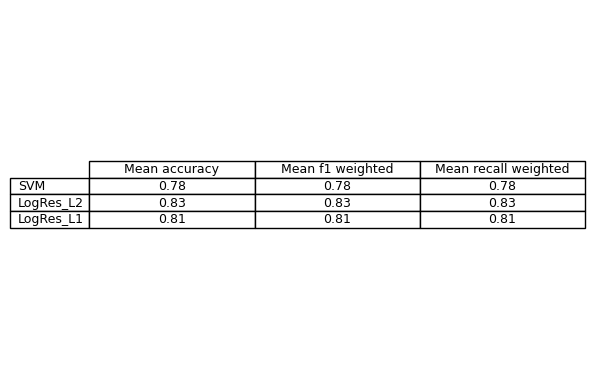

In [120]:
te.visualize_results(cross_five_cluster)

Now, we will look at the seven gene sets in predicting the `highint_low` class. The seven-gene set, coming from logistic regression with L2 regularization, has been selected to improve the prediction capabilities regarding this class variable.

We see that AUCs are somewhat lower than predicted on all DEGs. For instance, L2 had an AUC of 0.76 and now one of 0.65. However, we experienced overfitting with such a large amount of features.

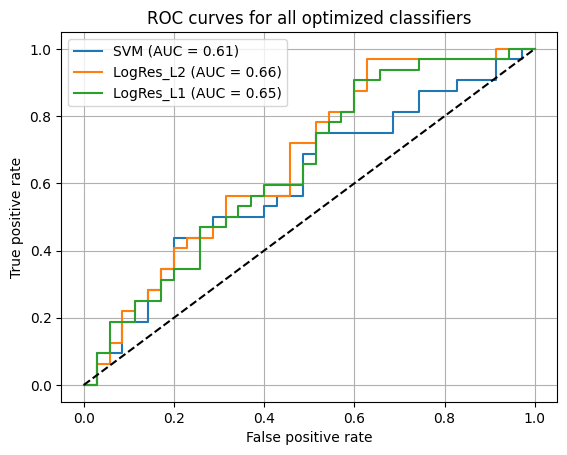

In [121]:
train_five_pheno = {}

for name, model in models.items():
    train_five_pheno[name] = te.train(five_genes, model, cls="highint_low", plot=True)

te.roc_in_one(train_five_pheno)

There is no large class bias when predicting severity: recall scores are fairly the same between classes, although on the lower end.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.57      0.57      0.57        35
         Low       0.53      0.53      0.53        32

    accuracy                           0.55        67
   macro avg       0.55      0.55      0.55        67
weighted avg       0.55      0.55      0.55        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.61      0.63      0.62        35
         Low       0.58      0.56      0.57        32

    accuracy                           0.60        67
   macro avg       0.60      0.60      0.60        67
weighted avg       0.60      0.60      0.60        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.61      0.66      0.63        35
         Low       0.59      0.53      0.56        32

    accuracy                    

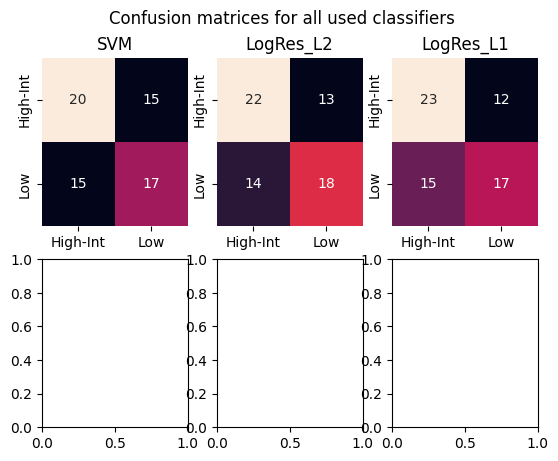

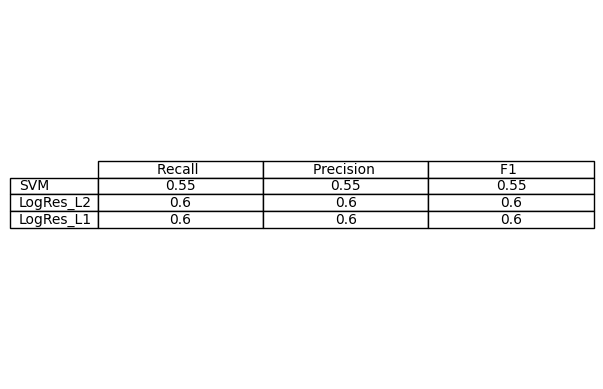

In [123]:
te.visualize_results(train_five_pheno)

Cross-validation results are similar between models and classes but have a high standard deviation of 0.10 for SVM and L1 and an even higher 0.12 for L2.

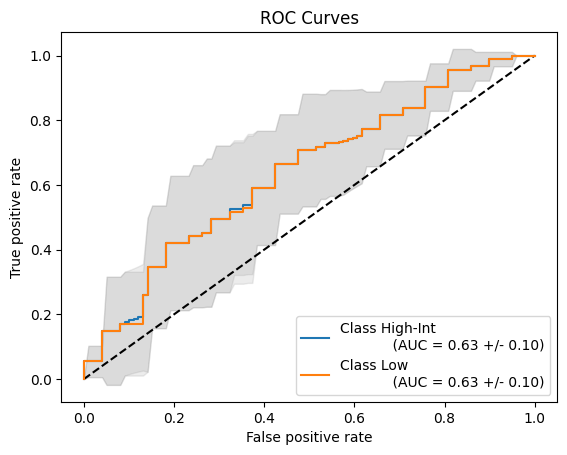

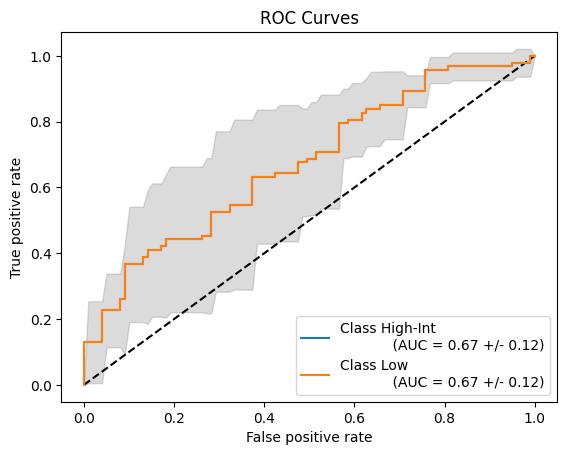

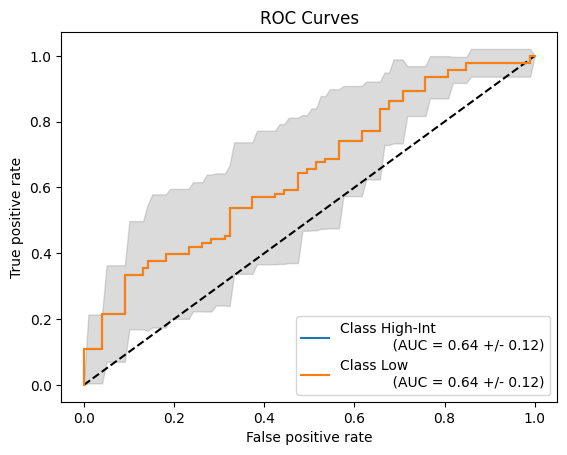

In [124]:
cross_five_pheno = {}

for name, model in models.items():
    cross_five_pheno[name] = te.cross_val(five_genes, model, cls='highint_low', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

Cross-validation results are fairly higher than the test results, maybe suggesting that the test set has a sample size that is too small.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.63      0.62      0.63       106
         Low       0.57      0.58      0.58        93

    accuracy                           0.60       199
   macro avg       0.60      0.60      0.60       199
weighted avg       0.60      0.60      0.60       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.65      0.64      0.65       106
         Low       0.60      0.61      0.61        93

    accuracy                           0.63       199
   macro avg       0.63      0.63      0.63       199
weighted avg       0.63      0.63      0.63       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.61      0.66      0.64       106
         Low       0.58      0.53      0.55        93

    accuracy                    

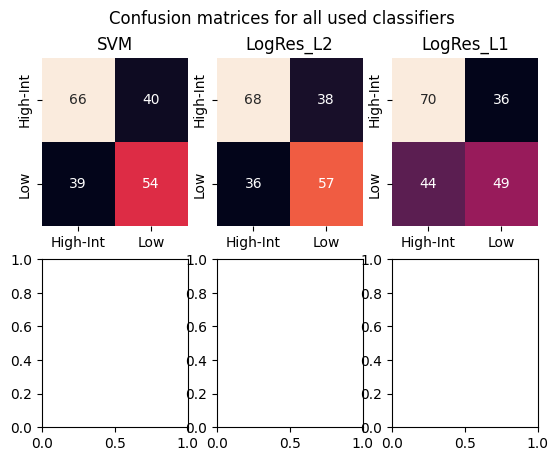

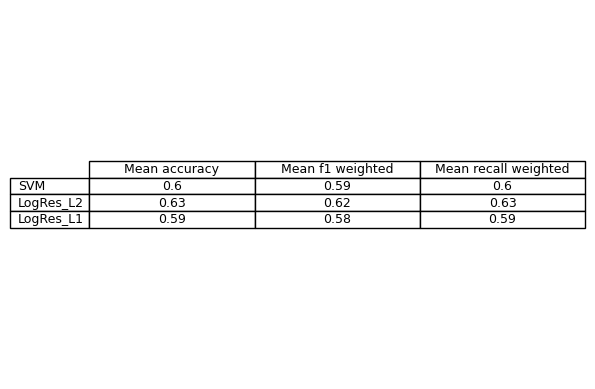

In [126]:
te.visualize_results(cross_five_pheno)

We move on to a new gene set established with mutual information.

We see that the AUC scores are still really high: all above 0.93.

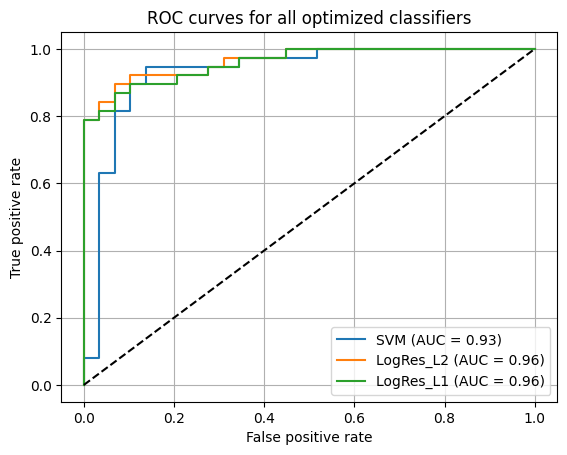

In [127]:
train_nine_cluster = {}

for name, model in models.items():
    train_nine_cluster[name] = te.train(nine_genes, model, cls="cluster", plot=True)

te.roc_in_one(train_nine_cluster)

The difference between recall scores is somewhat smaller for SVM (0.86 for `one` and 0.92 for `two`) and, therefore, less biased. However, the other two methods seem to be roughly the same as we saw with the seven-gene set.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.89      0.86      0.88        29
         two       0.90      0.92      0.91        38

    accuracy                           0.90        67
   macro avg       0.90      0.89      0.89        67
weighted avg       0.90      0.90      0.90        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.89      0.83      0.86        29
         two       0.88      0.92      0.90        38

    accuracy                           0.88        67
   macro avg       0.88      0.87      0.88        67
weighted avg       0.88      0.88      0.88        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.86      0.83      0.84        29
         two       0.87      0.89      0.88        38

    accuracy                    

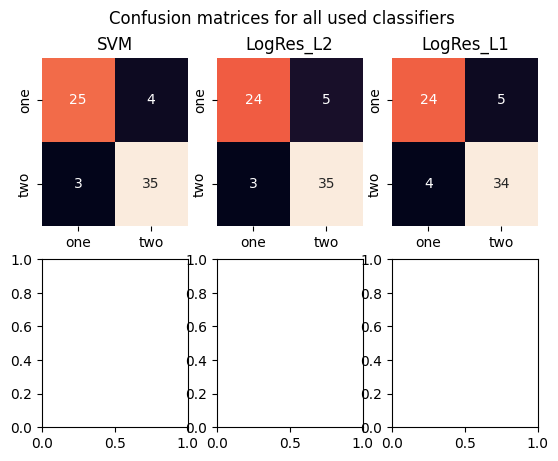

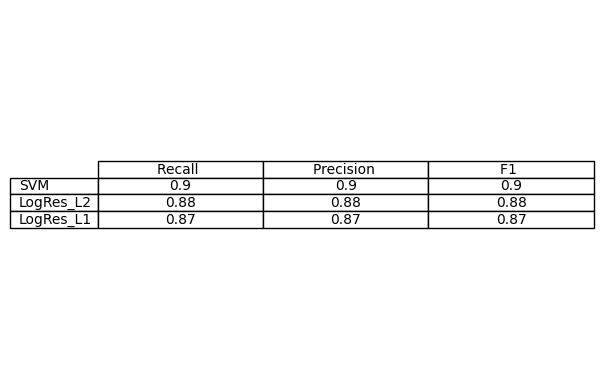

In [128]:
te.visualize_results(train_nine_cluster)

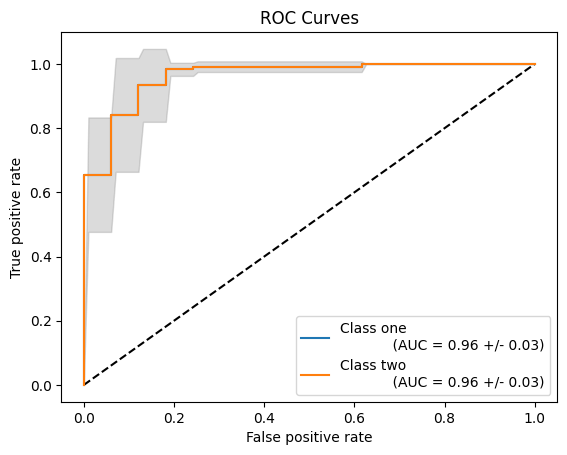

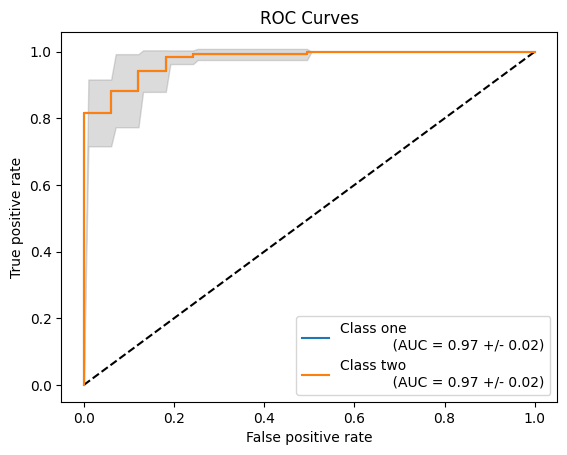

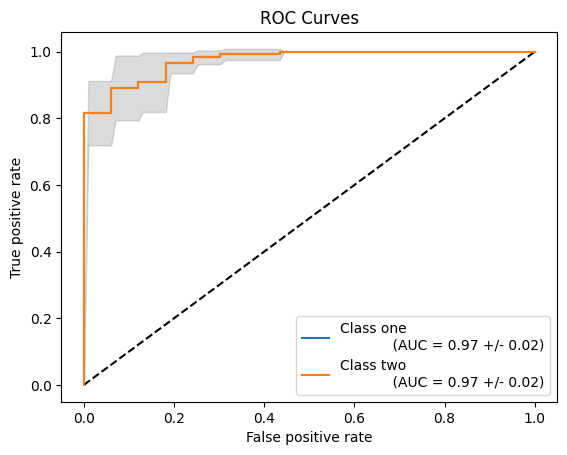

In [80]:
cross_nine_cluster = {}

for name, model in models.items():
    cross_nine_cluster[name] = te.cross_val(nine_genes, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

Cross-validation scores seem to be good in predicting both classes; `one` has a recall score of around 0.80 for all models and `two` all around 0.95, reflecting that this gene set is better at generalization than the seven-gene set.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.96      0.80      0.87        80
         two       0.88      0.97      0.92       119

    accuracy                           0.90       199
   macro avg       0.92      0.89      0.90       199
weighted avg       0.91      0.90      0.90       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.93      0.81      0.87        80
         two       0.88      0.96      0.92       119

    accuracy                           0.90       199
   macro avg       0.91      0.89      0.89       199
weighted avg       0.90      0.90      0.90       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.92      0.81      0.86        80
         two       0.88      0.95      0.91       119

    accuracy                    

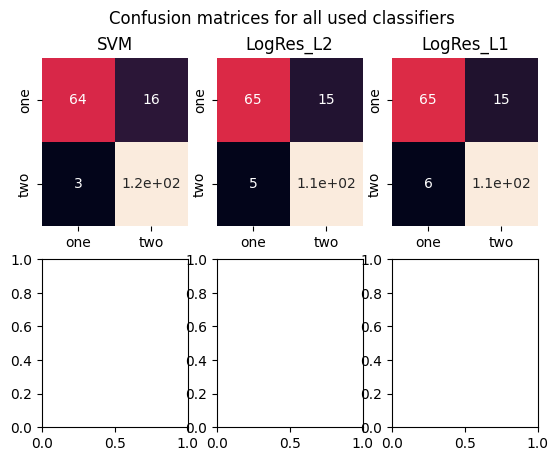

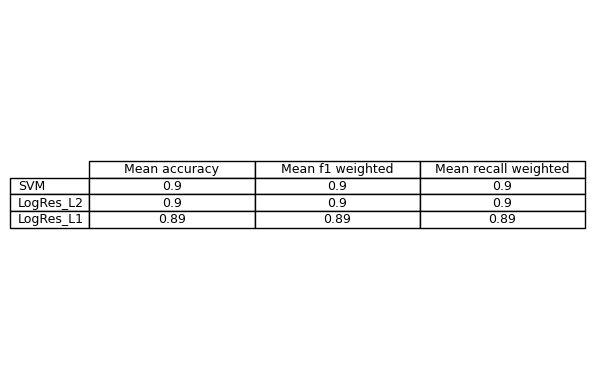

In [81]:
te.visualize_results(cross_nine_cluster)

Now, we move on to predicting the extreme phenotypes again. Here, we see somewhat improved scores in contrast to the four-gene set. For instance, we tailored this gene set based on L2 regularization, and this resulted in an AUC improvement of 0.65 to 0.68. It is not particularly major, but it signals that a large gene set may be beneficial here.

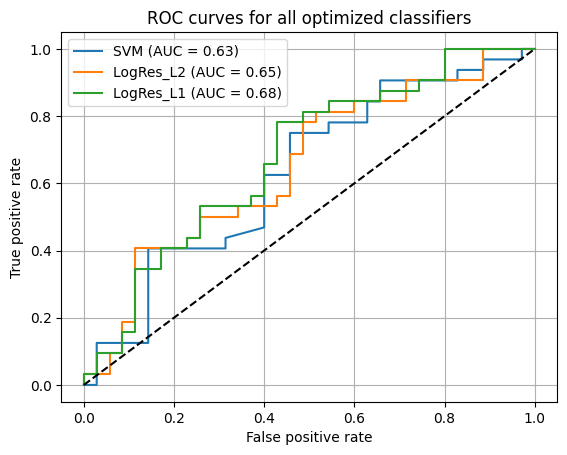

In [129]:
train_nine_pheno = {}

for name, model in models.items():
    train_nine_pheno[name] = te.train(nine_genes, model, cls="highint_low", plot=True)

te.roc_in_one(train_nine_pheno)

Other results suggest that the prediction capabilities are roughly the same here as well for both classes and across all models. However, recall is higher in L2 (0.61; see table) than for other methods.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.58      0.60      0.59        35
         Low       0.55      0.53      0.54        32

    accuracy                           0.57        67
   macro avg       0.57      0.57      0.57        67
weighted avg       0.57      0.57      0.57        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.58      0.54      0.56        35
         Low       0.53      0.56      0.55        32

    accuracy                           0.55        67
   macro avg       0.55      0.55      0.55        67
weighted avg       0.55      0.55      0.55        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.64      0.60      0.62        35
         Low       0.59      0.62      0.61        32

    accuracy                    

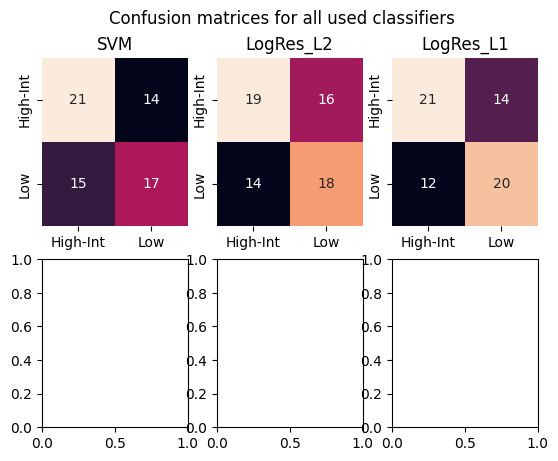

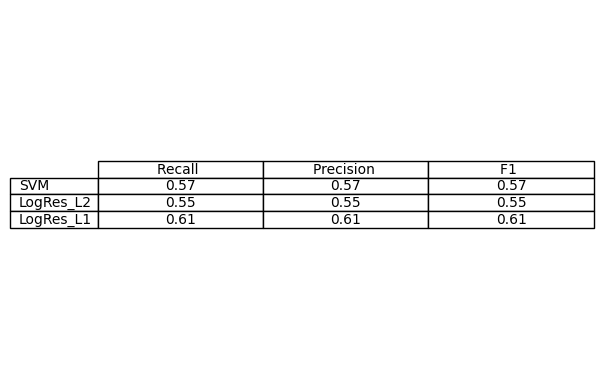

In [98]:
te.visualize_results(train_nine_pheno)

Cross-validation AUCs are now more in line with the test set, and standard deviations are lower as well. The highest scoring AUC is from SVM at 0.67 for both classes.

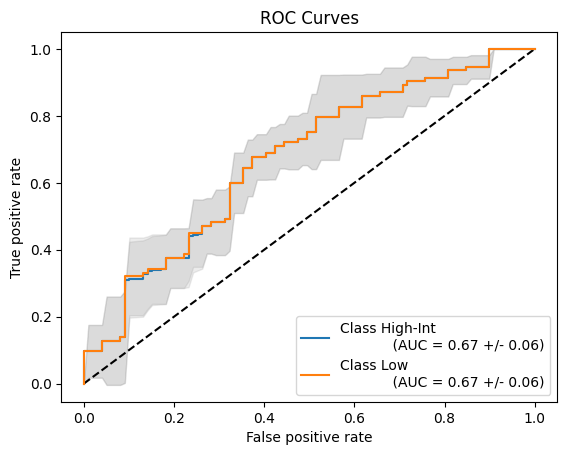

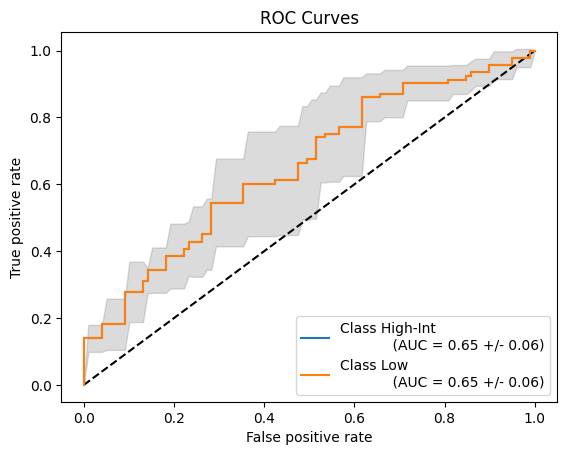

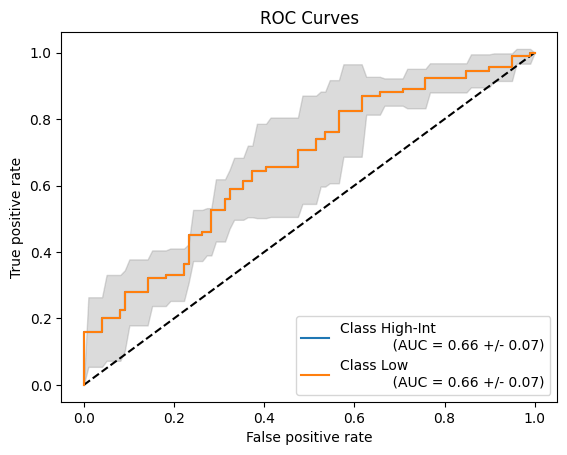

In [99]:
cross_nine_pheno = {}

for name, model in models.items():
    cross_nine_pheno[name] = te.cross_val(nine_genes, model, cls='highint_low', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The confusion matrix seems to paint a similar picture: improved metric scores in comparison with the four-gene set, recall scores that are similar between classes and models, and somewhat higher.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.66      0.63      0.64       106
         Low       0.60      0.62      0.61        93

    accuracy                           0.63       199
   macro avg       0.63      0.63      0.63       199
weighted avg       0.63      0.63      0.63       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.64      0.63      0.64       106
         Low       0.59      0.59      0.59        93

    accuracy                           0.61       199
   macro avg       0.61      0.61      0.61       199
weighted avg       0.61      0.61      0.61       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.64      0.64      0.64       106
         Low       0.59      0.59      0.59        93

    accuracy                    

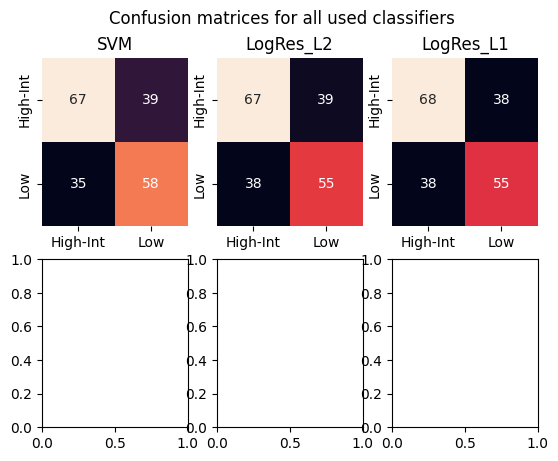

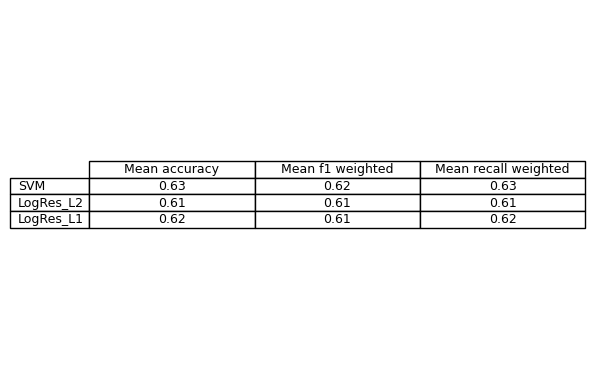

In [100]:
te.visualize_results(cross_nine_pheno)

Now, we are evaluating the final gene set: the eleven-sized gene set established with logistic regression with L1 regularization.

All models exhibit an AUC score of between 0.93 and 0.97, which is really high and might be a sign of overfitting.

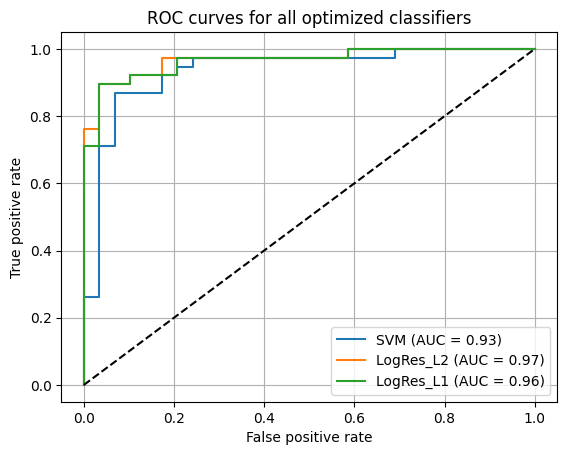

In [130]:
train_eleven_cluster = {}

for name, model in models.items():
    train_eleven_cluster[name] = te.train(eleven_genes, model, cls="cluster", plot=True)

te.roc_in_one(train_eleven_cluster)

However, when we compare the results between predicting classes `one` and `two`, the differences are less extreme than we saw with the five-gene set and have improved compared to the nine-gene set. The recall for `one` is the same for each model expect SVM: 0.79; `two` has more scores of 0.97, and 0.92.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.92      0.79      0.85        29
         two       0.86      0.95      0.90        38

    accuracy                           0.88        67
   macro avg       0.89      0.87      0.88        67
weighted avg       0.88      0.88      0.88        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.96      0.83      0.89        29
         two       0.88      0.97      0.93        38

    accuracy                           0.91        67
   macro avg       0.92      0.90      0.91        67
weighted avg       0.92      0.91      0.91        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.89      0.83      0.86        29
         two       0.88      0.92      0.90        38

    accuracy                    

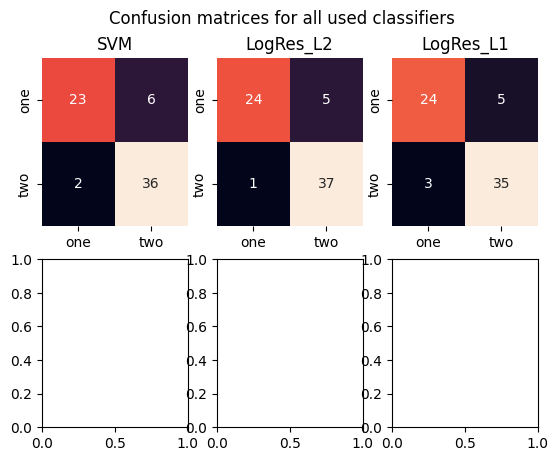

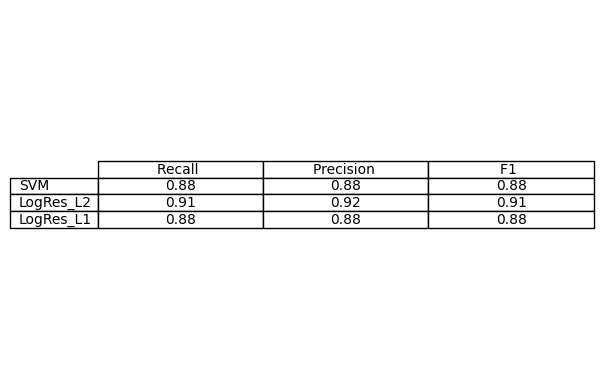

In [131]:
te.visualize_results(train_eleven_cluster)

Cross-validated ROCs and AUC are the same for each model: 0.96 with a standard deviation of 0.02 or 0.03.

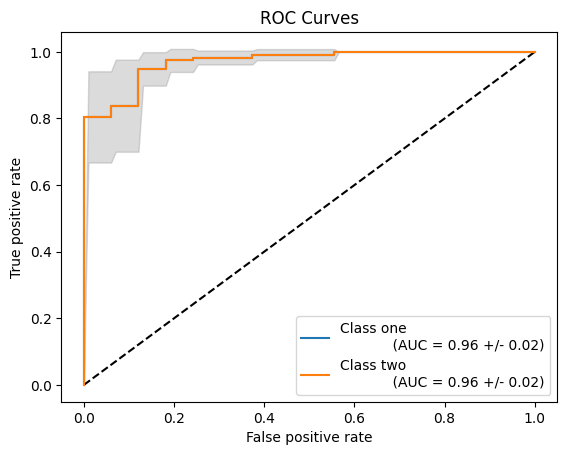

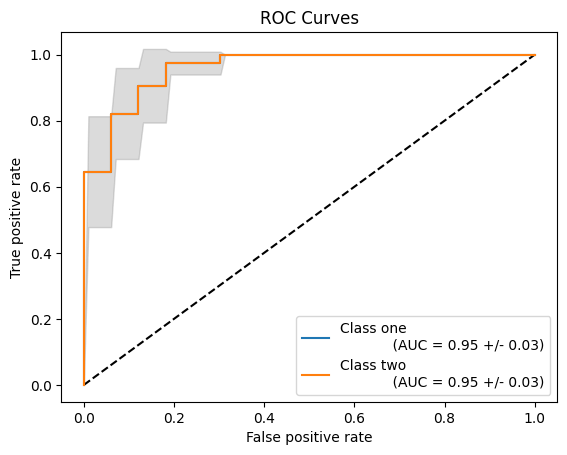

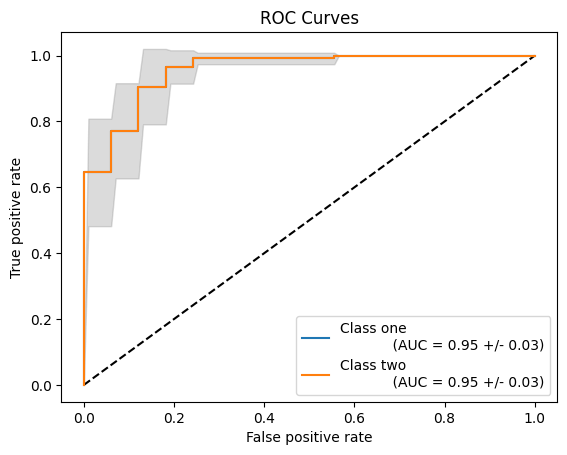

In [132]:
cross_eleven_cluster = {}

for name, model in models.items():
    cross_eleven_cluster[name] = te.cross_val(eleven_genes, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

Cross-validation seems to be in line with the metric scores of the test set: comparable recall for both the `one` and `two` classes and no major differences that seem to suggest overfitting.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.88      0.86      0.87        80
         two       0.91      0.92      0.92       119

    accuracy                           0.90       199
   macro avg       0.90      0.89      0.90       199
weighted avg       0.90      0.90      0.90       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.94      0.85      0.89        80
         two       0.91      0.97      0.93       119

    accuracy                           0.92       199
   macro avg       0.92      0.91      0.91       199
weighted avg       0.92      0.92      0.92       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.92      0.85      0.88        80
         two       0.90      0.95      0.93       119

    accuracy                    

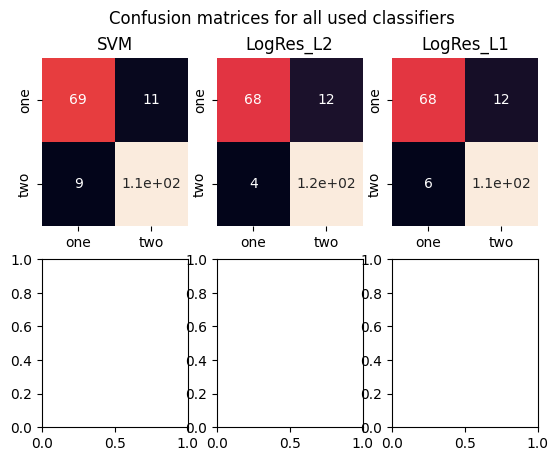

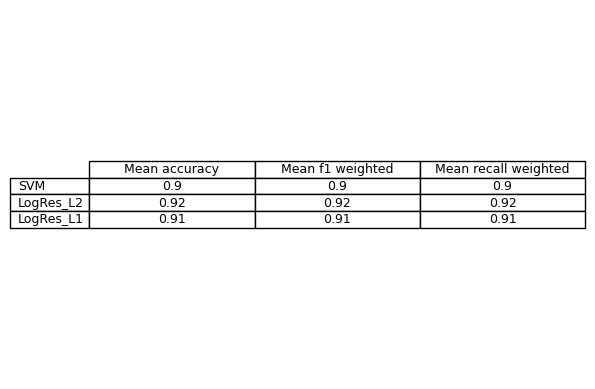

In [133]:
te.visualize_results(cross_eleven_cluster)

We will now evaluate the prediction capabilities of the eleven-gene set on `highint_low`. We tailored the gene set on L1, so we expect to see an improvement here compared to other gene sets. 

However, L1 and L2 have the second-best AUC score (0.72), and SVM is the best (0.73). Nevertheless, scores are much better than for the nine- and four-gene sets. All AUC scores were less than 0.70 for both, whereas here we see AUC for all models above 0.70!

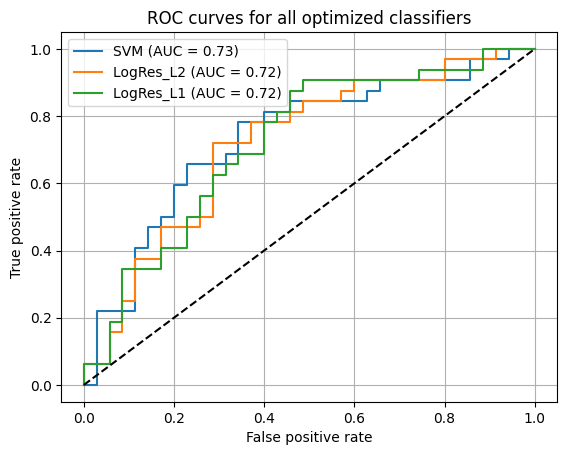

In [134]:
train_eleven_pheno = {}

for name, model in models.items():
    train_eleven_pheno[name] = te.train(eleven_genes, model, cls="highint_low", plot=True)

te.roc_in_one(train_eleven_pheno)

The recall scores are still comparable between classes or the same. Interestingly, SVM has the best scores for both classes (HighInt: 0.66, Low: 0.78), but the recall scores are the same for both classes in L1 (0.71) and L2 (0.62).

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.77      0.66      0.71        35
         Low       0.68      0.78      0.72        32

    accuracy                           0.72        67
   macro avg       0.72      0.72      0.72        67
weighted avg       0.72      0.72      0.72        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.68      0.71      0.69        35
         Low       0.67      0.62      0.65        32

    accuracy                           0.67        67
   macro avg       0.67      0.67      0.67        67
weighted avg       0.67      0.67      0.67        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.68      0.71      0.69        35
         Low       0.67      0.62      0.65        32

    accuracy                    

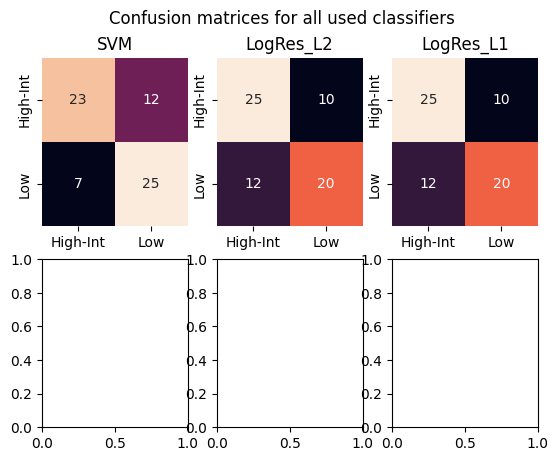

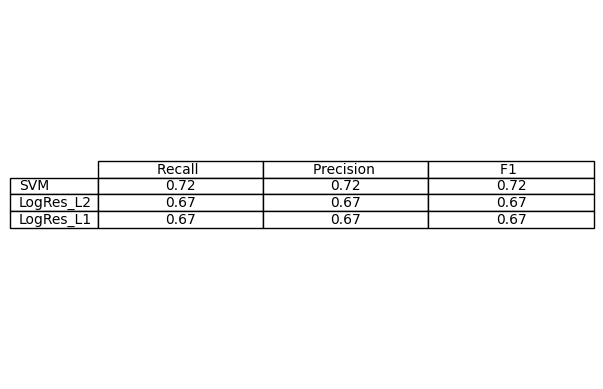

In [135]:
te.visualize_results(train_eleven_pheno)

Cross-validated AUCs are the best for L1 (0.78, with a standard deviation of 0.08), the regularization method used to get this particular gene set. 

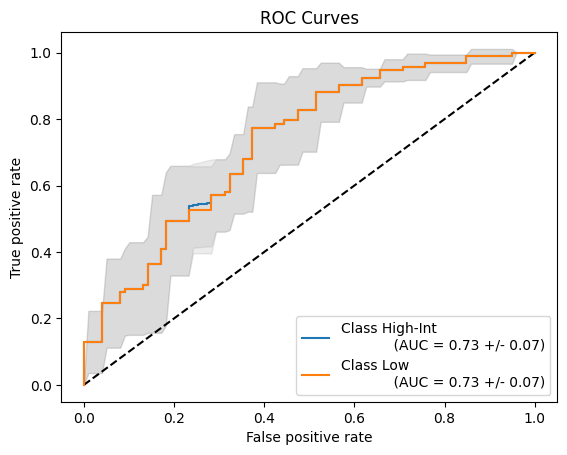

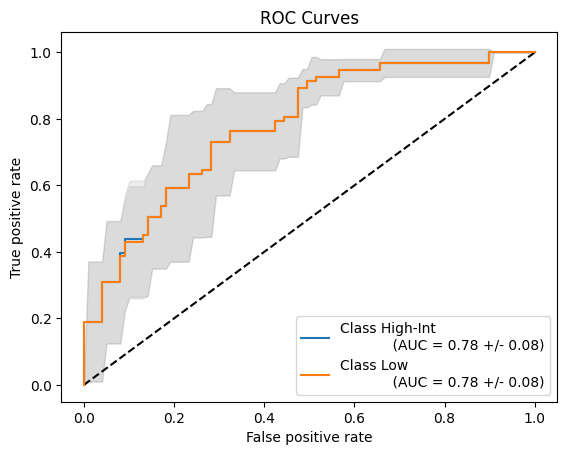

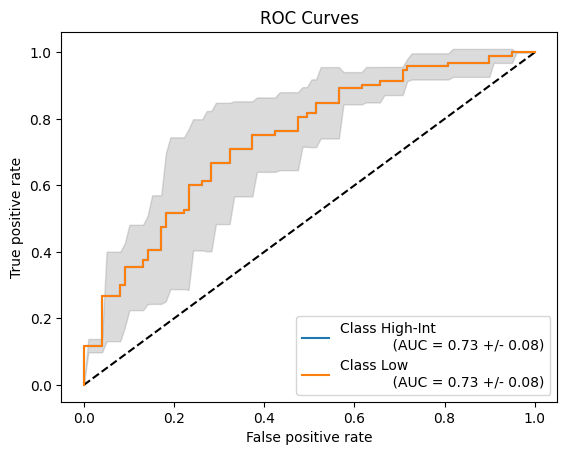

In [136]:
cross_eleven_pheno = {}

for name, model in models.items():
    cross_eleven_pheno[name] = te.cross_val(eleven_genes, model, cls='highint_low', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

Also, here, the best-scoring recall is for L2: `High-Int` (0.74) and `Low` (0.70). The prediction capabilities for L1 are slightly lower for the `Low` class (0.62) in comparison with the other models!

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.69      0.63      0.66       106
         Low       0.62      0.68      0.65        93

    accuracy                           0.65       199
   macro avg       0.65      0.65      0.65       199
weighted avg       0.66      0.65      0.65       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.74      0.74      0.74       106
         Low       0.70      0.70      0.70        93

    accuracy                           0.72       199
   macro avg       0.72      0.72      0.72       199
weighted avg       0.72      0.72      0.72       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.67      0.68      0.68       106
         Low       0.63      0.62      0.63        93

    accuracy                    

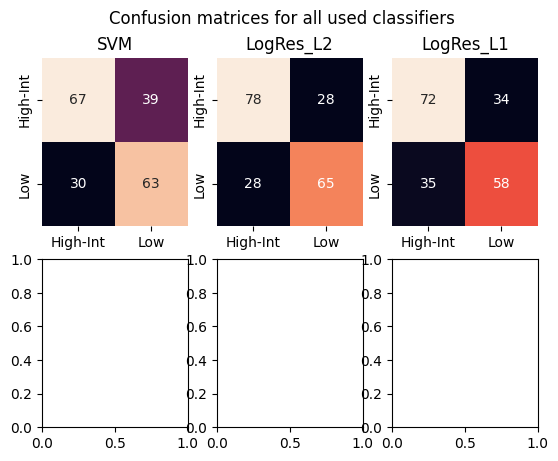

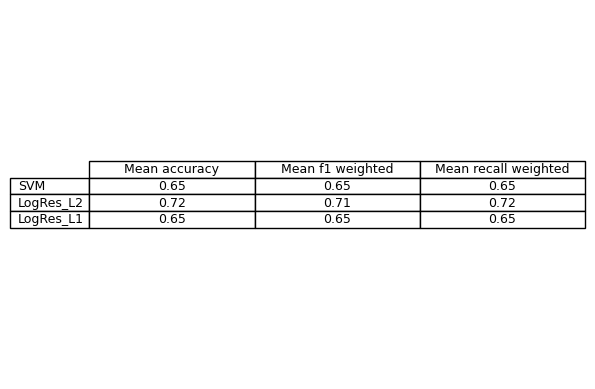

In [137]:
te.visualize_results(cross_eleven_pheno)

## <a id='optimalization'>Optimalization of Three Models<a/>

The eleven-gene set seems to be the best-performing one. Therefore, we will consider this our final gene set. We will use this gene set to optimize the three models and hopefully make a final decision on our model choice after that.

We will temporarily unpack the `eleven_genes` variable to use this train and test sets as a benchmark for optimization. We optimize via the `GridSearchCV` function (from `sklearn`). It uses cross-validation to assess different parameters and gives the best parameter set depending on best-scoring combinations.

In [138]:
x_train, x_test, y_train, y_test = eleven_genes 

In [139]:
param = {
    'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100], 
    'max_iter': [10, 50, 100, 500, 1000, 5000, 10000],
    'solver': ['saga'],
    'fit_intercept': [True, False], 
    'penalty': ['l1', 'l2']
}

We use a different rather large range in the `C` parameter, which reflects the regularization strength, and `solver` `saga`, which can work with both `L1` and `L2` regularization.

In [140]:
grid_search = GridSearchCV(estimator = LogisticRegression(multi_class='multinomial', solver='saga'), 
                           param_grid = param, scoring = 'recall_weighted', cv = 5)

grid_search.fit(x_train, y_train['highint_low'])

print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best score: 0.7232051282051282
Best parameters: {'C': 1, 'fit_intercept': True, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}


Smaller values of C specify more robust regularization. Therefore, it is probably the most essential parameter for L2, which is the most appropriate of the two penalty parameters (see above).

For SVM, we consider different values for the `C` parameter again, the `gamma` parameter, which decides on the decision boundary. Smaller values of gamma can closely fit the training data, which may result in a model that is too specialized to the training data and does not generalize well to new data. The kernel specifies the shape of the decision boundary.

In [141]:
params_svc = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': [100, 10, 1, 0.1, 0.01, 0.001],
    'estimator__kernel': ['rbf', 'poly', 'sigmoid']
}


In [142]:
grid_search = GridSearchCV(estimator=OneVsRestClassifier(SVC(probability=True)), param_grid=params_svc, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train['highint_low'])

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'estimator__C': 100, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}


The observation that `rbf` is the best kernel seems logical because our data is nonlinear.

Next, we consider optimizing the `C` parameter for L1.

In [143]:
param_lasso = {
    'C': [0.001, 0.01, 0.1, 1, 10, 20, 30, 50, 60, 70, 90, 100]
}

In [144]:
grid_search = GridSearchCV(estimator=LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga'),
                           param_grid=param_lasso, cv=5)

grid_search.fit(x_train, y_train['highint_low'])

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 10}


A `C` parameter of 10 seems to suggest a loose regularization, suggesting that our model has many nonzero coefficients (which is true; we have a specialized set of genes for L1).

Now, we move on to assess all the optimized versions of our models to the eleven-gene set!

In [145]:
models_opt = {"SVM":OneVsRestClassifier(SVC(probability=True, C=100, gamma=0.1, kernel='rbf')),
         "LogRes_L1":LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', C = 10),
         "LogRes_L2": LogisticRegression(multi_class='multinomial', C= 1, fit_intercept= True, max_iter= 500, penalty= 'l2', solver= 'saga')}

We start again by assessing the cluster. We see that the AUCs are fairly the same as for the nonoptimized sets, which all scored AUCs of 0.96 or higher. Here, all models have the same score!

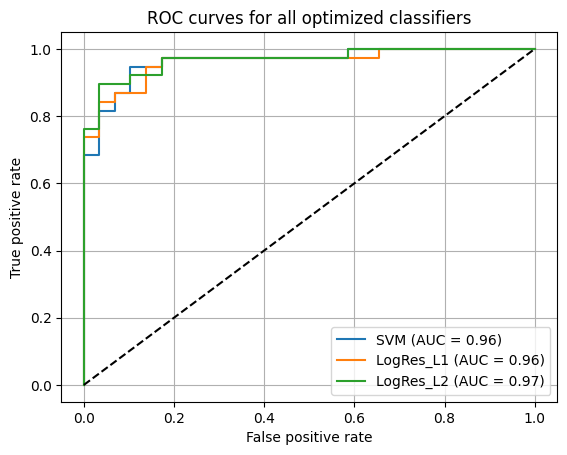

In [146]:
train_opt_cluster = {}

for name, model in models_opt.items():
    train_opt_cluster[name] = te.train(eleven_genes, model, cls="cluster", plot=True)

te.roc_in_one(train_opt_cluster)

Recall scores are comparable for L1 and L2, but SVM has a much lower for `one`, coming in at just 0.83 and 0.97 for `two`.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.96      0.83      0.89        29
         two       0.88      0.97      0.93        38

    accuracy                           0.91        67
   macro avg       0.92      0.90      0.91        67
weighted avg       0.92      0.91      0.91        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.93      0.86      0.89        29
         two       0.90      0.95      0.92        38

    accuracy                           0.91        67
   macro avg       0.91      0.90      0.91        67
weighted avg       0.91      0.91      0.91        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.96      0.83      0.89        29
         two       0.88      0.97      0.93        38

    accuracy                    

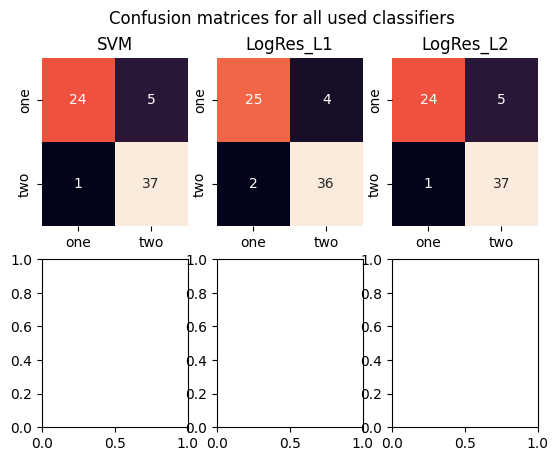

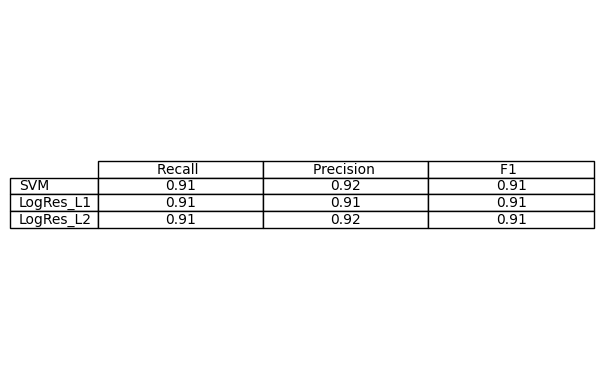

In [147]:
te.visualize_results(train_opt_cluster)

Cross-validation AUCs are fairly similar across all models and have not changed much in comparison to the non-optimized sets!

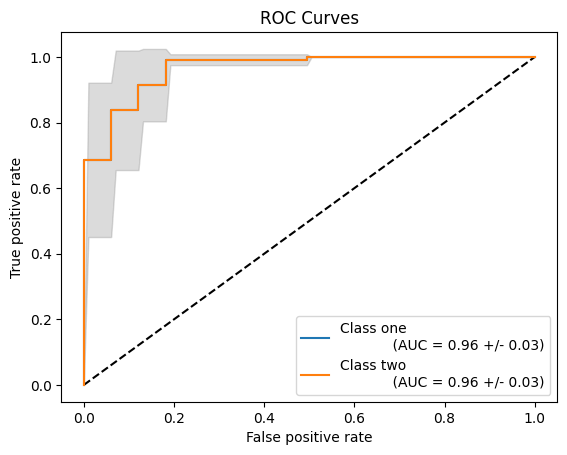

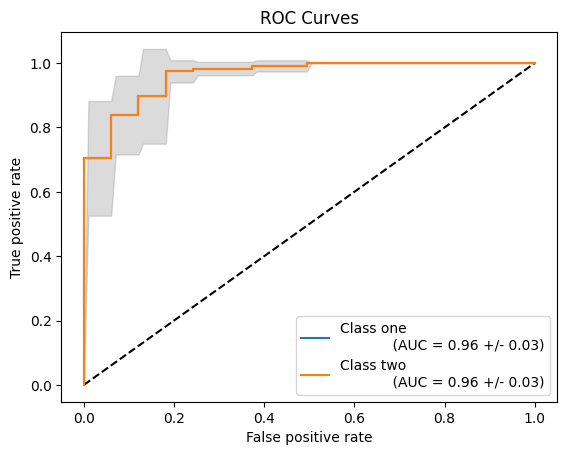

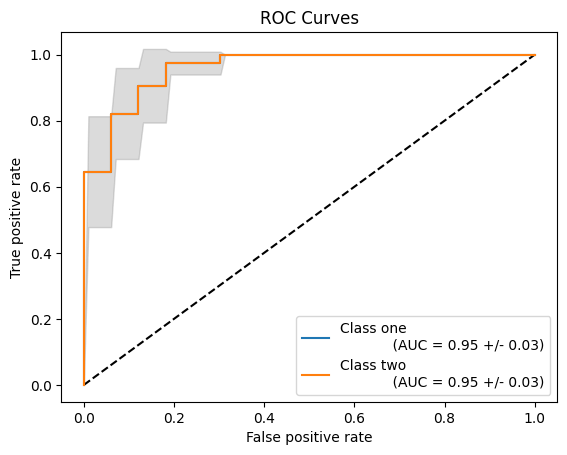

In [148]:
cross_opt_cluster = {}

for name, model in models_opt.items():
    cross_opt_cluster[name] = te.cross_val(eleven_genes, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

Cross-validation results are comparable to what we have seem on the test set, suggesting generalization capabilities.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.92      0.90      0.91        80
         two       0.93      0.95      0.94       119

    accuracy                           0.93       199
   macro avg       0.93      0.92      0.93       199
weighted avg       0.93      0.93      0.93       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.91      0.88      0.89        80
         two       0.92      0.94      0.93       119

    accuracy                           0.91       199
   macro avg       0.91      0.91      0.91       199
weighted avg       0.91      0.91      0.91       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.94      0.85      0.89        80
         two       0.91      0.97      0.93       119

    accuracy                    

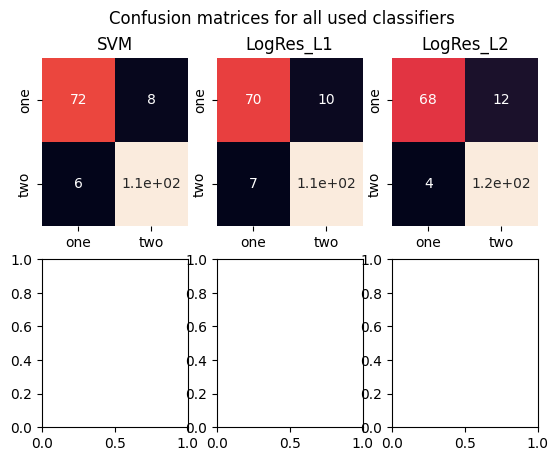

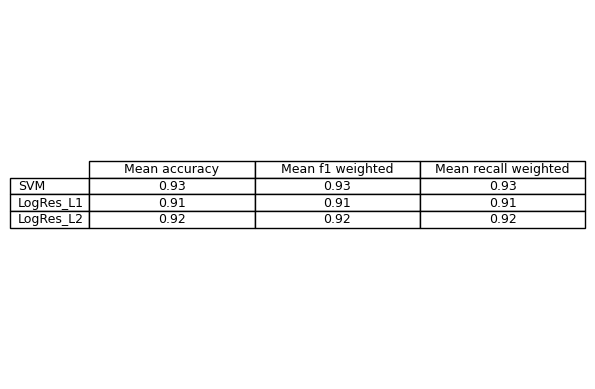

In [149]:
te.visualize_results(cross_opt_cluster)

Now, we turn to predicting the extreme phenotypes again.

The AUC scores are fairly similar to then nonoptimized models, even sometimes slightly worse than before.

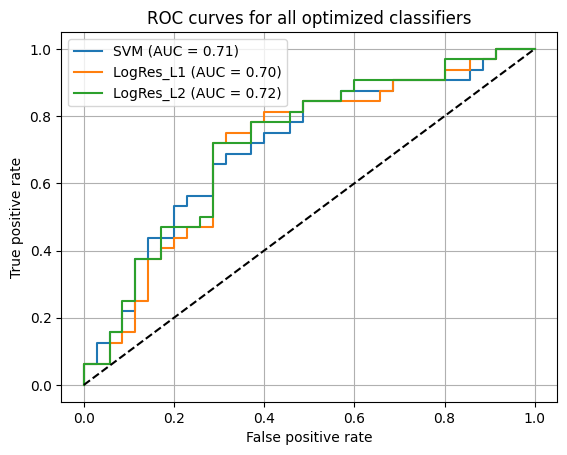

In [150]:
train_opt_pheno = {}

for name, model in models_opt.items():
    train_opt_pheno[name] = te.train(eleven_genes, model, cls="highint_low", plot=True)

te.roc_in_one(train_opt_pheno)

Recall scores stayed fairly the same. However, the SVM has a much higher recall score for High-Int than when predicting the lower class. The other models have consistent scores for both classes.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.71      0.63      0.67        35
         Low       0.64      0.72      0.68        32

    accuracy                           0.67        67
   macro avg       0.67      0.67      0.67        67
weighted avg       0.68      0.67      0.67        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.71      0.71      0.71        35
         Low       0.69      0.69      0.69        32

    accuracy                           0.70        67
   macro avg       0.70      0.70      0.70        67
weighted avg       0.70      0.70      0.70        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.68      0.71      0.69        35
         Low       0.67      0.62      0.65        32

    accuracy                    

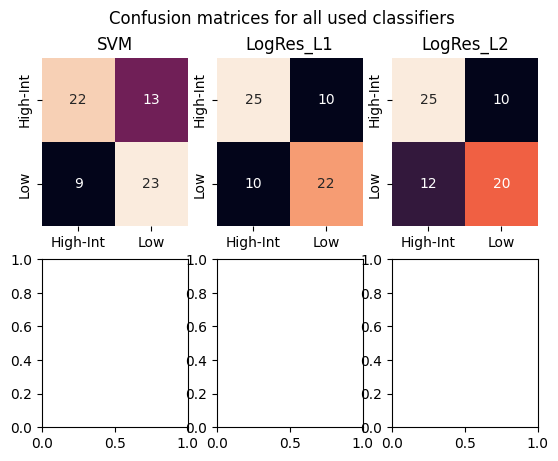

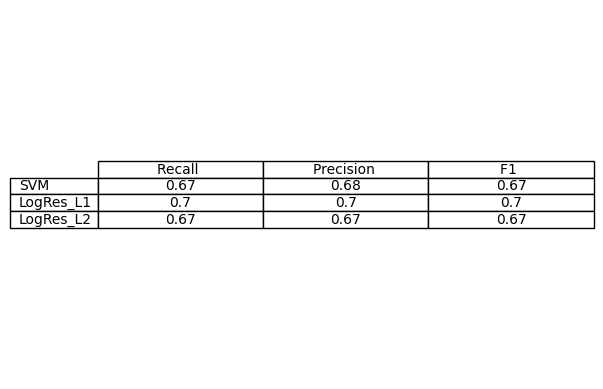

In [151]:
te.visualize_results(train_opt_pheno)

Cross-validated AUCs stayed fairly consistent between all models, and the standard deviation is smaller than when compared to non-optimized models.

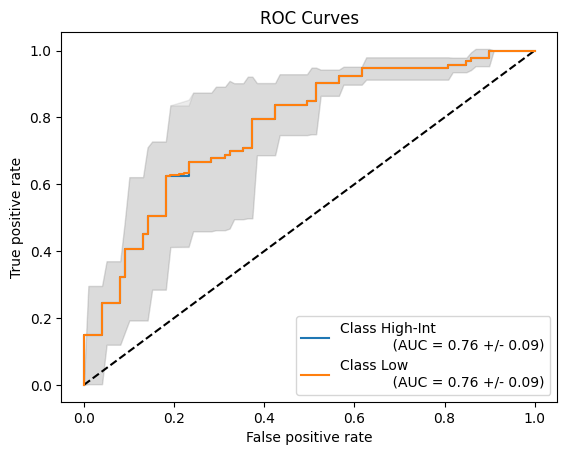

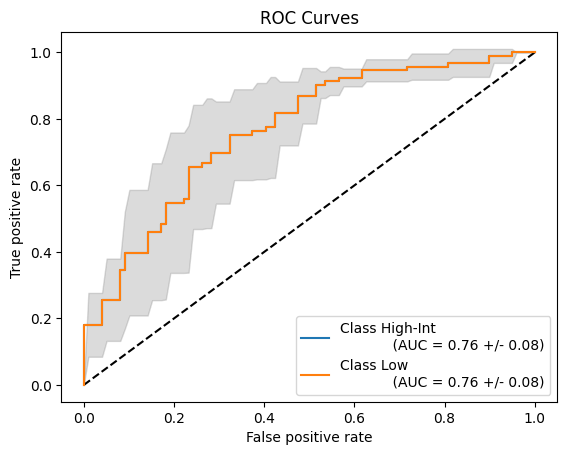

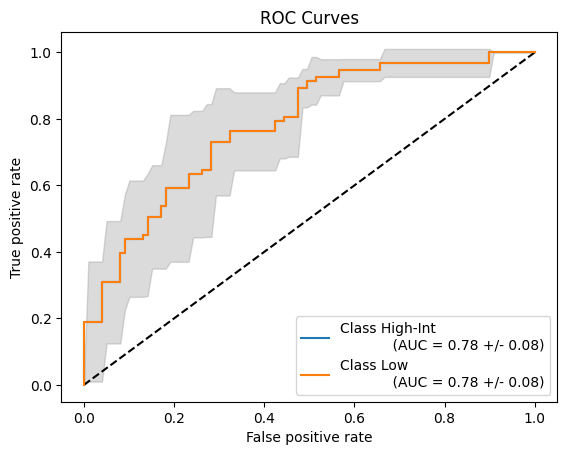

In [152]:
cross_opt_pheno = {}

for name, model in models_opt.items():
    cross_opt_pheno[name] = te.cross_val(eleven_genes, model, cls='highint_low', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

Recall scores stayed fairly consistent when cross-validating as well in comparison with non-optimized sets. For instance, L1 scores for High-Int a recall score of 0.70 (the same as here) and for Low one of 0.68.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.78      0.71      0.74       106
         Low       0.70      0.77      0.73        93

    accuracy                           0.74       199
   macro avg       0.74      0.74      0.74       199
weighted avg       0.74      0.74      0.74       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.71      0.70      0.70       106
         Low       0.66      0.68      0.67        93

    accuracy                           0.69       199
   macro avg       0.69      0.69      0.69       199
weighted avg       0.69      0.69      0.69       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.74      0.74      0.74       106
         Low       0.70      0.70      0.70        93

    accuracy                    

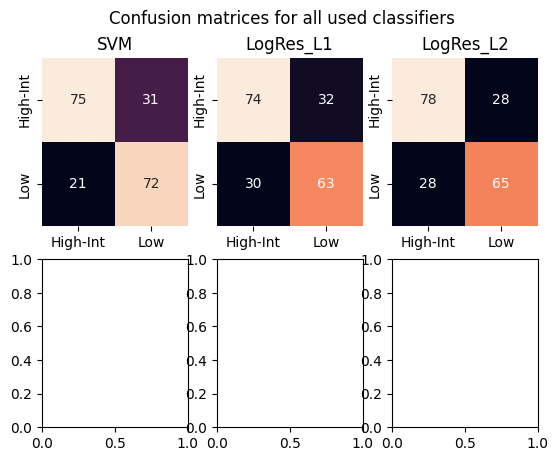

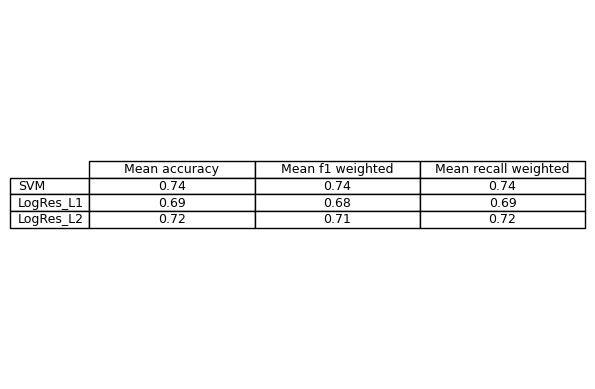

In [153]:
te.visualize_results(cross_opt_pheno)

In conclusion, the optimized sets have brought the cluster predicting per class closer to one another but are quite similar or even slightly worse in predicting severity.

## <a id='icu_validation'>Model Validation<a/>

We will have an additional validation on the ICU cohort, which exhibits more severe sepsis cases. If our model can predict here with accurate scores as well, then this proves that the model is capable of good generalization. To repeat, the ICU set also has a mild (`one`)  and severe (`two`) cluster

In [154]:
icu_meta = pd.read_csv('data/clustering/icu_clusters.csv')
icu_counts = pd.read_csv('data/degs/all_degs.csv', index_col=0).T.reset_index().rename(columns={"index":"sample_identifier"})

Below, we see the distribution of High, Intermediate, and Low cases within the two clusters. Even though the share of High severity is lower in `one` than in two, we see that the overall range (see boxplots) of the cases in `one` is higher in SOFA scores.

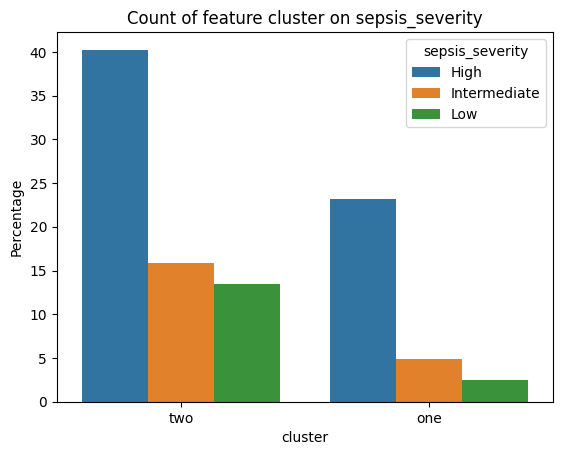

In [155]:
te.visualize_features(data=icu_meta, hue='sepsis_severity')

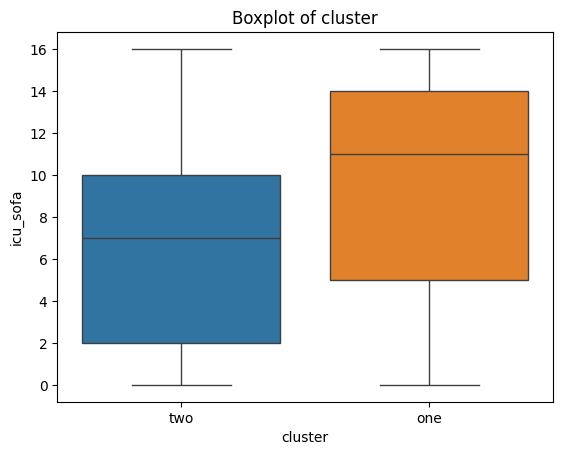

In [43]:
te.visualize_features(icu_meta, y="icu_sofa", hue="cluster", method="boxplot")

We will perform a similar procedure when we load the ER data; we first merge the ICU count and metadata and then generate the `highint_low` class variable. This, however, creates a different distribution of samples than we have seen in the ER cohort: the class imbalance is now Low instead of High. This might create some generalization issues. 

After that, we will go and _replace_ the original test set with count and labels from the ICU cohort.

In [156]:
merge_icu = pd.merge(icu_counts, icu_meta[["cluster", "sepsis_severity", "sample_identifier"]], on="sample_identifier", how='inner')
merge_icu['highint_low'] = merge_icu['sepsis_severity'].apply(lambda x: "High-Int" if x in ['High', 'Intermediate'] else "Low")

# use the original transformer trained on ER data
x_test_icu = merge_icu.drop(["cluster", "sepsis_severity", "highint_low", "sample_identifier"], axis=1)
x_test_scaled_icu = scaler.transform(x_test_icu)
x_test_icu = pd.DataFrame(x_test_scaled_icu, index=x_test_icu.index, columns=x_test_icu.columns)

# replace the original test set with information from the ICU
x_test_icu = x_test_icu[[column for column in x_test_icu.columns if column in eleven]]
t = X_train[[column for column in X_train.columns if column in eleven]]
train_test_data_icu = t, x_test_icu, y_train, merge_icu[["cluster", "sepsis_severity", "highint_low"]]

We will first cover the endotype classification. We see here that the AUCs of the optimized sets are still fairly high. All score an AUC of 0.93!

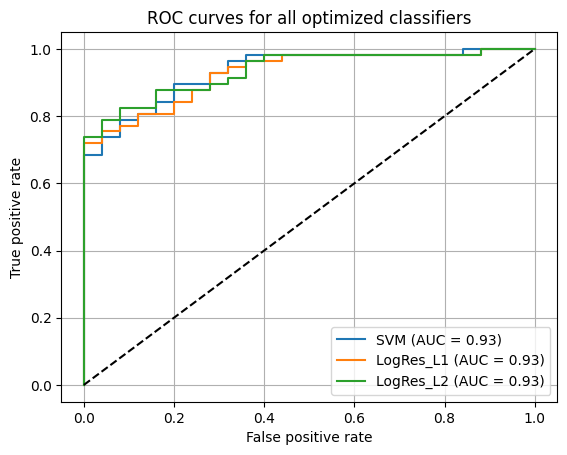

In [157]:
train_opt_cluster = {}

for name, model in models_opt.items():
    train_opt_cluster[name] = te.train(train_test_data_icu, model, cls="cluster", plot=True)

te.roc_in_one(train_opt_cluster)

When going to the recall scores again, we see that SVM has the closest recall scores between both classes and that SVM and L2, although not extremely different, do not exhibit the same scores as SVM. This observation suggests that SVM might be the best model to consider as our final model. We will not cross-validate since the training set has not changed.

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.62      0.92      0.74        25
         two       0.96      0.75      0.84        57

    accuracy                           0.80        82
   macro avg       0.79      0.84      0.79        82
weighted avg       0.85      0.80      0.81        82

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.64      0.92      0.75        25
         two       0.96      0.77      0.85        57

    accuracy                           0.82        82
   macro avg       0.80      0.85      0.80        82
weighted avg       0.86      0.82      0.82        82

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.66      0.92      0.77        25
         two       0.96      0.79      0.87        57

    accuracy                    

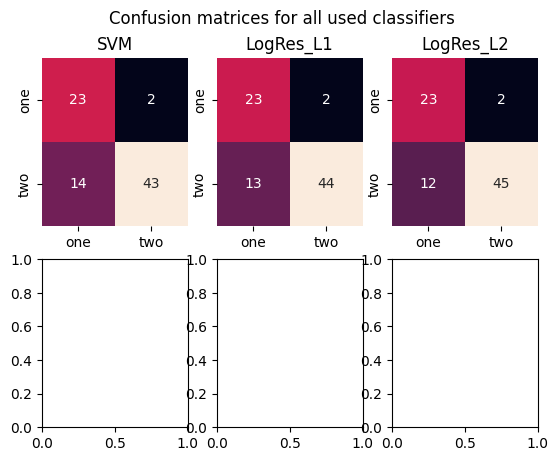

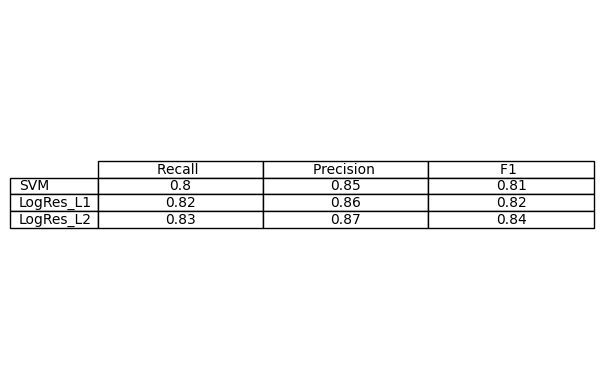

In [158]:
te.visualize_results(train_opt_cluster)

Now, we move on to predicting the severity. We see that SVM has the best-scoring AUC of 0.67 and that L1 and L2 score one of 0.66.

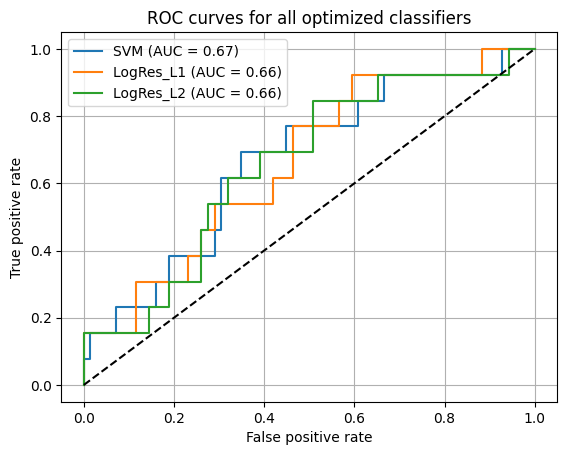

In [159]:
train_opt_pheno = {}

for name, model in models_opt.items():
    train_opt_pheno[name] = te.train(train_test_data_icu, model, cls="highint_low", plot=True)

te.roc_in_one(train_opt_pheno)

Recall scores are okay across the board. No one scores above 0.70, and L2 has the closest scores between classes: `High-Int` with 0.58 and `Low` with 0.69. The other two models predict Low better than High-Int, indicating the problem with the class balance.

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.90      0.55      0.68        69
         Low       0.23      0.69      0.34        13

    accuracy                           0.57        82
   macro avg       0.56      0.62      0.51        82
weighted avg       0.80      0.57      0.63        82

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.89      0.57      0.69        69
         Low       0.21      0.62      0.31        13

    accuracy                           0.57        82
   macro avg       0.55      0.59      0.50        82
weighted avg       0.78      0.57      0.63        82

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.91      0.58      0.71        69
         Low       0.24      0.69      0.35        13

    accuracy                    

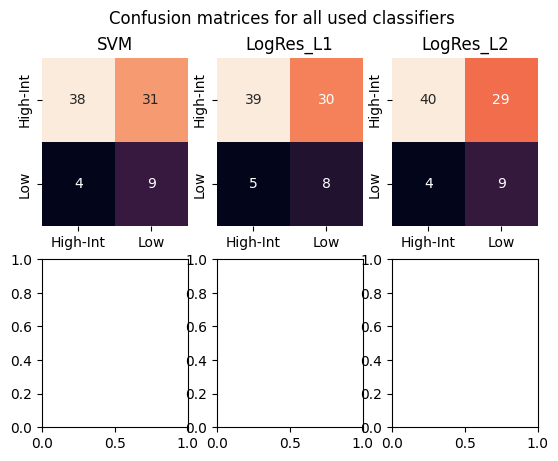

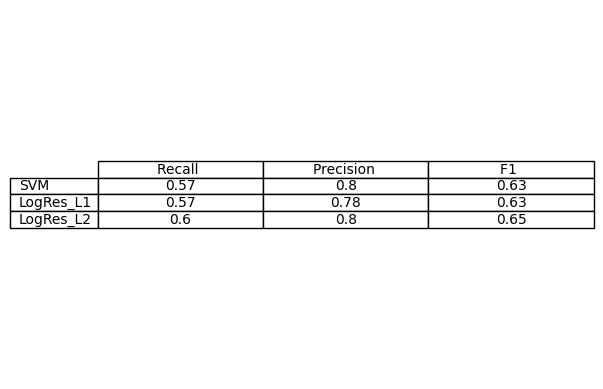

In [160]:
te.visualize_results(train_opt_pheno)

We see that the scores for endotype are fairly similar to the ER cohort, indicating good generalization. However, the prediction of severity is still difficult, which underlines the challenge of addressing the heterogeneity of sepsis. The class imbalance between High-Int and Low might disturb the model's generalization toward higher SOFA scores. However, it might also be the case that ICU patients have different patient characteristics than patients and that our model is more tailored towards the latter.

## <a id='feature_extraction'>Feature Extraction</a>

Lastly, we consider using dimension reduction to have a smaller dataset. We perform PCA on the eleven-gene set!

`determine_number_pcs` determines the number of PCs we need, and `plot_cum_pcs` plots the graph to highlight findings.

In [161]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

def determine_number_pcs(data, *, scaled=True, threshold_var=0.8):
    """"""
    if not scaled:
        scaler = StandardScaler()
        data = scaler.transform(data)

    pca = PCA()
    data_pca = pca.fit_transform(data)

    cumulative_score = np.cumsum(pca.explained_variance_ratio_)
    cutoff = np.where(cumulative_score >= threshold_var)[0][0] # get the index
    data_pca = data_pca[:, 0:cutoff+1]
    
    pca_dataframe = pd.DataFrame(data_pca, columns=[f"PC{num}" for num in range(data_pca.shape[1])], index=data.index)

    return cumulative_score, pca_dataframe

def plot_cum_pcs(data, *, threshold=0.8):
    """"""
    cutoff = np.where(data >= threshold)[0][0] # get the index
    plt.figure(figsize=(15, 8))

    plt.plot(data, marker='|')
    plt.axhline(threshold, color='red')
    plt.axvline(cutoff, color='red')
    plt.xticks([cutoff])
    
    plt.title("Cumulative PCA score")
    plt.xlabel("Number of components")
    plt.ylabel("Cumlative score")
    plt.grid(True)
    plt.show()

### <a id='red'>Feature Extraction: Eleven-gene set</a>

The eleven gene training set needs 5 PCs to explain 80% of the variance.

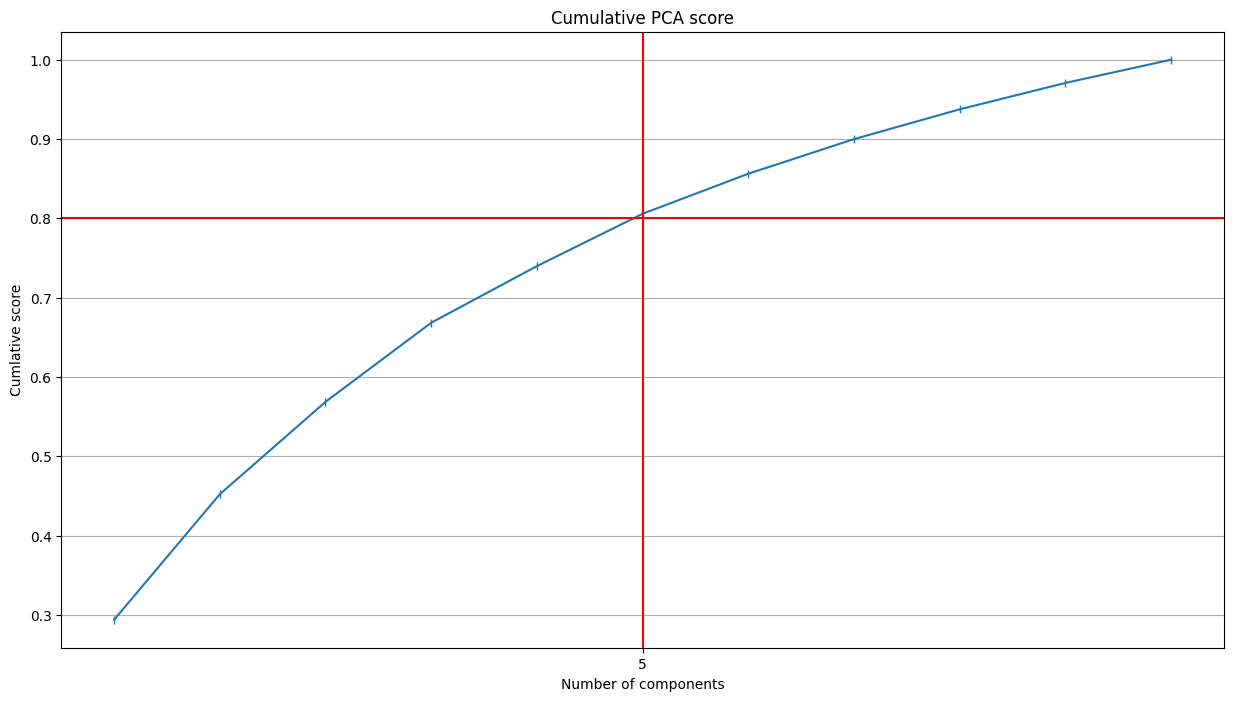

In [162]:
reduced_counts_pca_training = determine_number_pcs(eleven_genes[0])

reduced_counts_pca_training[1].head()

plot_cum_pcs(reduced_counts_pca_training[0])

We see that the eleven-gene test set needs 5 PCs to explain 80% of the total variance. We will consider both six since we need a number of features to be the same for each.

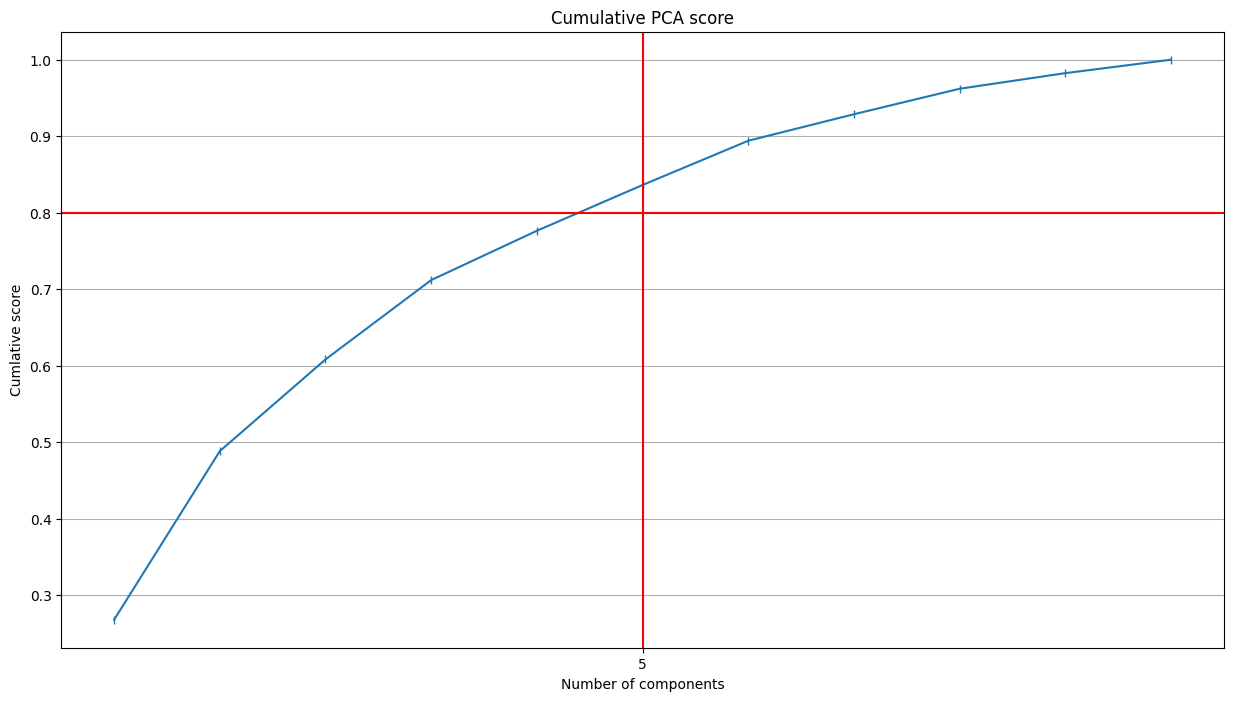

In [163]:
reduced_counts_pca_test = determine_number_pcs(eleven_genes[1])

reduced_counts_pca_test[1].head()

plot_cum_pcs(reduced_counts_pca_test[0])

We will adjust the training and test set to account for 5 PCs instead of the twelve gene expressions.

In [164]:
pca_counts_red_training = reduced_counts_pca_training[1].iloc[:, :5]
pca_counts_red_test = reduced_counts_pca_test[1].iloc[:, :5]

In [165]:
eleven_genes_pca = pca_counts_red_training, pca_counts_red_test, eleven_genes[2], eleven_genes[3]

We will take a look at the prediction of the cluster number. We see that the recall of `one` is 0.00 and `two`. This suggests that the PCS does not reflect the data distribution of our original twelve-gene set.

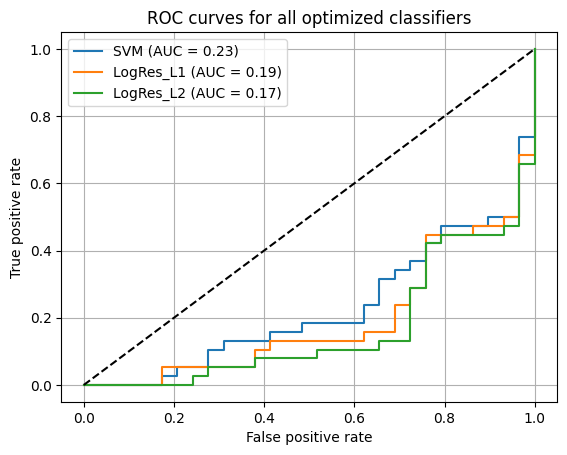

In [166]:
train_pca_cluster_twelve = {}

for name, model in models_opt.items():
    train_pca_cluster_twelve[name] = te.train(eleven_genes_pca, model, cls="cluster", plot=True)

te.roc_in_one(train_pca_cluster_twelve)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.24      0.24      0.24        29
         two       0.42      0.42      0.42        38

    accuracy                           0.34        67
   macro avg       0.33      0.33      0.33        67
weighted avg       0.34      0.34      0.34        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.22      0.21      0.21        29
         two       0.42      0.45      0.44        38

    accuracy                           0.34        67
   macro avg       0.32      0.33      0.33        67
weighted avg       0.34      0.34      0.34        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.19      0.17      0.18        29
         two       0.41      0.45      0.43        38

    accuracy                    

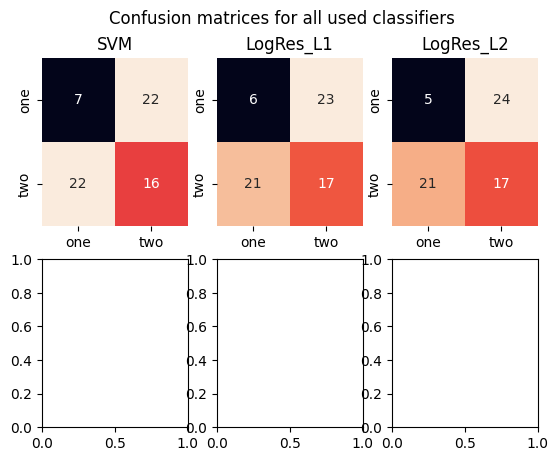

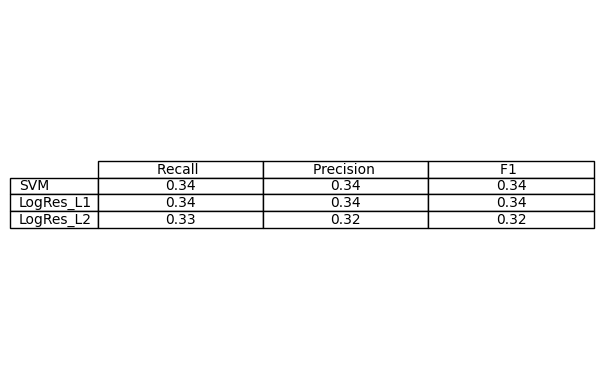

In [167]:
te.visualize_results(train_pca_cluster_twelve)

We see that the recall of `one` is 0.00 and `two`. This suggests that the PCS does not reflect the data distribution of our original twelve-gene set.

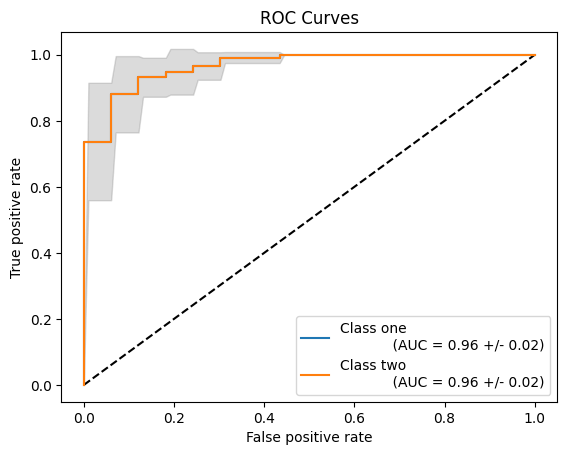

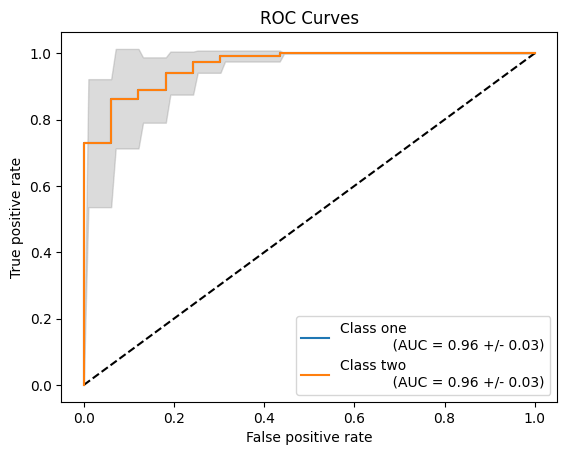

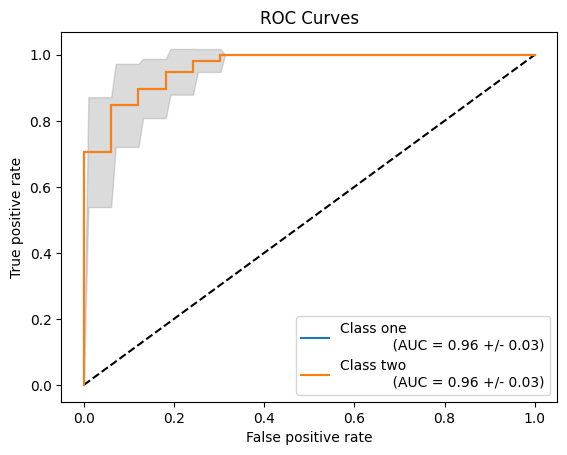

In [168]:
cross_pca_cluster_twelve = {}

for name, model in models_opt.items():
    cross_pca_cluster_twelve[name] = te.cross_val(eleven_genes_pca, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.91      0.84      0.87        80
         two       0.90      0.94      0.92       119

    accuracy                           0.90       199
   macro avg       0.90      0.89      0.89       199
weighted avg       0.90      0.90      0.90       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.91      0.85      0.88        80
         two       0.90      0.94      0.92       119

    accuracy                           0.90       199
   macro avg       0.90      0.90      0.90       199
weighted avg       0.90      0.90      0.90       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.92      0.84      0.88        80
         two       0.90      0.95      0.92       119

    accuracy                    

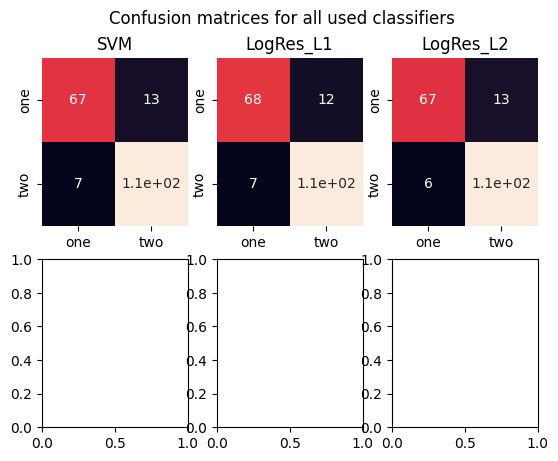

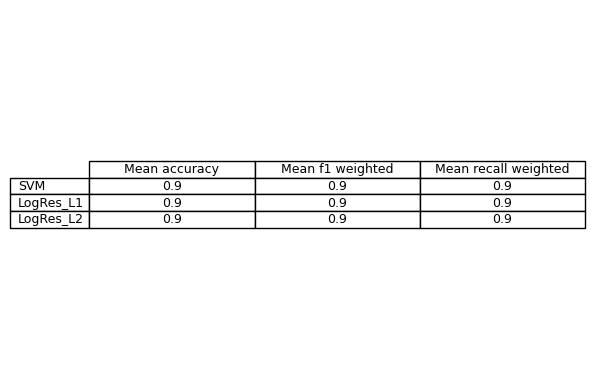

In [169]:
te.visualize_results(cross_pca_cluster_twelve)

We will take a look at the prediction of the severity number. We see that the recall of `High-Int` is 0.00 and `Low` is 1.00. This suggests that the PCS does not reflect the data distribution of our original twelve-gene set.

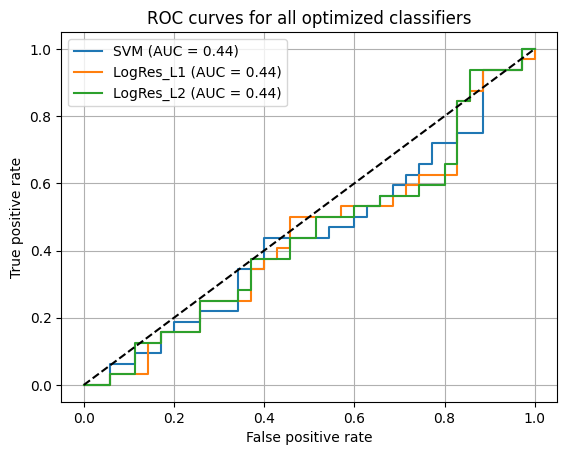

In [170]:
train_pca_pheno_twelve = {}

for name, model in models_opt.items():
    train_pca_pheno_twelve[name] = te.train(eleven_genes_pca, model, cls="highint_low", plot=True)

te.roc_in_one(train_pca_pheno_twelve)

The resulting classification report for SVM 
               precision    recall  f1-score   support

    High-Int       0.51      0.54      0.53        35
         Low       0.47      0.44      0.45        32

    accuracy                           0.49        67
   macro avg       0.49      0.49      0.49        67
weighted avg       0.49      0.49      0.49        67

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

    High-Int       0.51      0.57      0.54        35
         Low       0.46      0.41      0.43        32

    accuracy                           0.49        67
   macro avg       0.49      0.49      0.49        67
weighted avg       0.49      0.49      0.49        67

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

    High-Int       0.49      0.54      0.51        35
         Low       0.43      0.38      0.40        32

    accuracy                    

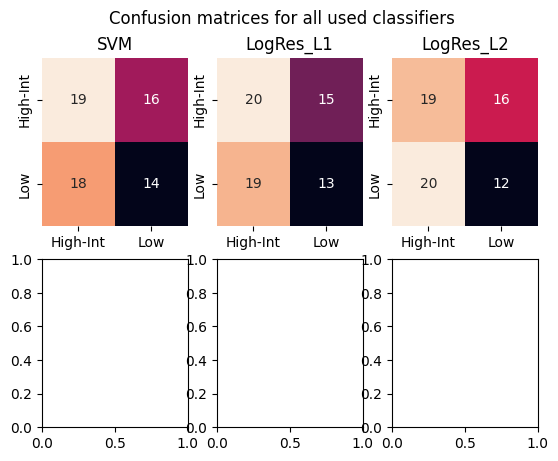

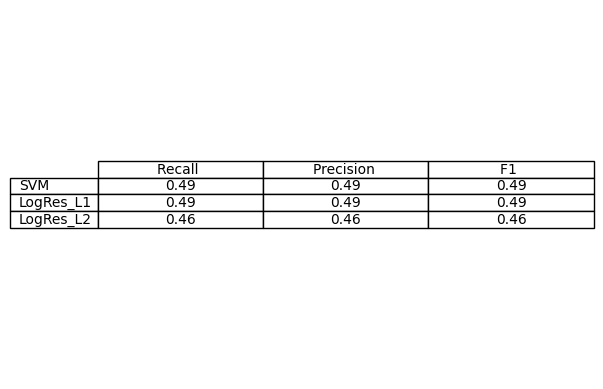

In [171]:
te.visualize_results(train_pca_pheno_twelve)


We will take a look at the prediction of the cluster number. We see that the recall of `one` is 0.00 and `two`. This suggests that the PCS does not reflect the data distribution of our original twelve-gene setions

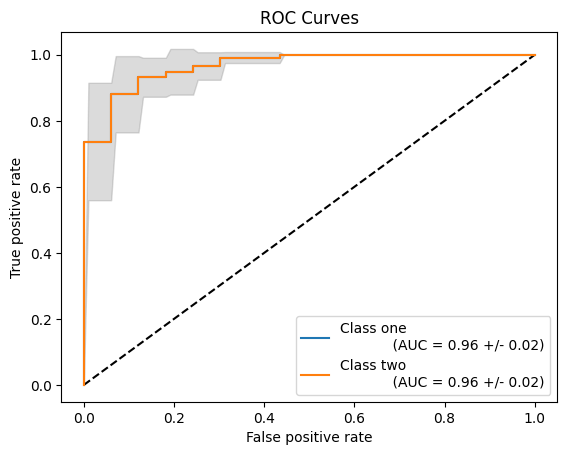

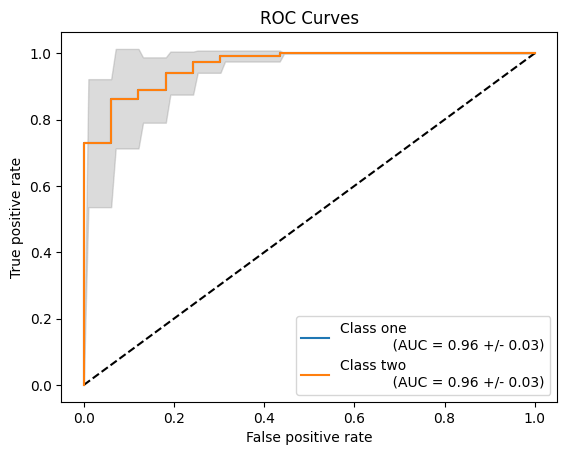

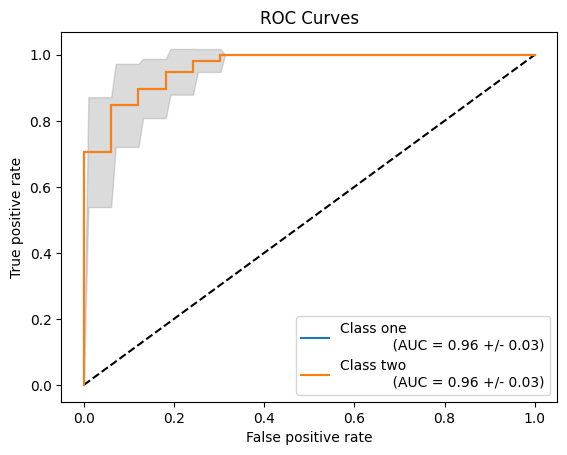

In [172]:
cross_pca_pheno_twelve = {}

for name, model in models_opt.items():
    cross_pca_pheno_twelve[name] = te.cross_val(eleven_genes_pca, model, cls='cluster', 
                                        scoring=['accuracy','f1_weighted', 'precision', 'recall_weighted'], plot=True)

The resulting classification report for SVM 
               precision    recall  f1-score   support

         one       0.91      0.84      0.87        80
         two       0.90      0.94      0.92       119

    accuracy                           0.90       199
   macro avg       0.90      0.89      0.89       199
weighted avg       0.90      0.90      0.90       199

The resulting classification report for LogRes_L1 
               precision    recall  f1-score   support

         one       0.91      0.85      0.88        80
         two       0.90      0.94      0.92       119

    accuracy                           0.90       199
   macro avg       0.90      0.90      0.90       199
weighted avg       0.90      0.90      0.90       199

The resulting classification report for LogRes_L2 
               precision    recall  f1-score   support

         one       0.92      0.84      0.88        80
         two       0.90      0.95      0.92       119

    accuracy                    

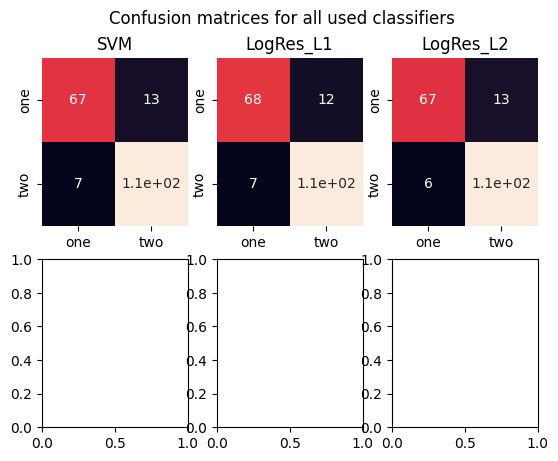

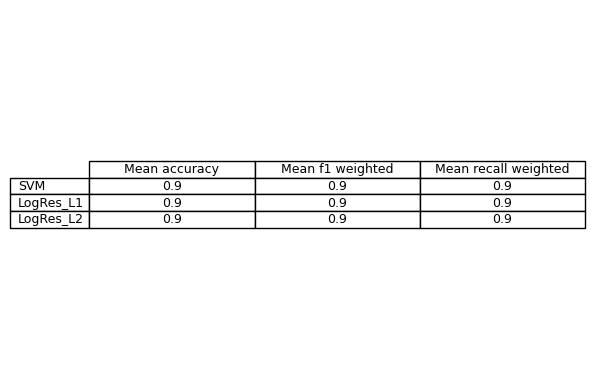

In [173]:
te.visualize_results(cross_pca_pheno_twelve)

The results of prediction on PCA suggest that, unfortunately, the PC does not reflect the data distribution of the twelve gene set for SVM. This might be because of the differences in components. However, it still performs really well for predicting the cross-validation and not so much on the test set. Therefore, we will not consider the PCA variant as an alternative.